In [303]:
import numpy as np
import pandas as pd
from astropy.coordinates import SkyCoord
import astropy.units as units

from BASE9Analysis import readGaiaData
from BASE9Analysis import findSeparation
from scipy.stats import ks_2samp

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from matplotlib import font_manager
#point to font directory and find files within it
font_dirs = ['/Library/Fonts/']
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)
#add fonts
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
# set font
plt.rcParams['font.family'] = 'Noto Sans JP'

%matplotlib inline

In [304]:
# %load_ext autoreload
# %autoreload 2
# from getGaiaData import GaiaClusterMembers

In [305]:
# cluster = GaiaClusterMembers(295.3250, 40.19, 1)
# cluster.verbose = 1
# cluster.getData()

In [306]:
# cluster.saveDataToFile('clusterGaiaData.ecsv')

In [307]:
#read data from ecsv and round to 4 decimals
originalGaia=readGaiaData('M67data.ecsv')
originalGaia=originalGaia.round(4)

In [308]:
#define filepaths for samplemasses, memberships, and photometry
sm = "/Users/Claire/Documents/Code/current/ANNACRNN/plotting/run21_int_19co_ov/result/cluster.massSamples"
mem = "/Users/Claire/Documents/Code/current/ANNACRNN/plotting/run21_int_19co_ov/result/cluster.membership"
ph = "/Users/Claire/Documents/Code/current/ANNACRNN/plotting/run21_int_19co_ov/NGC6819.phot"

In [309]:
#create dataframe for photometry, and define analysis columns
phot = pd.read_csv(ph, sep='\s+')
phot['m1Mean'] = -1
phot['m1Std'] = -2
phot['m2Mean'] = -3
phot['m2Std'] = -4
phot['qMean'] = -5
phot['qStd'] = -6
phot['memMean'] = -7
phot['memStd'] = -8
phot['member'] = False
phot['binary'] = False
phot

id        G     G_BP     G_RP     g_ps     r_ps     i_ps  \
0     10010400015   9.9643  11.6368   8.7188  12.0640  11.9650  10.1610   
1     10618000016  10.0908  11.4559   8.9425  13.2814  10.9032   9.0598   
2     10719500017  10.1428  11.4292   9.0287  99.9000  99.9000  99.9000   
3     11321600029  10.9064  11.7692  10.0000  99.9000  99.9000  99.9000   
4     10007800034  11.0790  11.9665  10.1455  99.9000  99.9000  99.9000   
...           ...      ...      ...      ...      ...      ...      ...   
1905  10639026771  20.4824  99.9000  99.9000  99.9000  99.9000  99.9000   
1906  10095627116  20.5168  99.9000  99.9000  21.0998  99.9000  20.2313   
1907  10130227255  20.5313  99.9000  99.9000  99.9000  20.5410  20.3388   
1908  10572927462  20.5560  99.9000  99.9000  99.9000  99.9000  99.9000   
1909  10000728211  99.9000  99.9000  15.3227  17.9458  17.3214  17.0324   

         z_ps     y_ps    J_2M  ...  m1Mean  m1Std  m2Mean  m2Std  qMean  \
0      9.0880   8.5260   6.758  ...      -1     -2      -3     -4     -5   
1      8.5864   8.8477   7.240  ...      -1     -2      -3     -4     -5   
2     99.9000  99.9000   7.356  ...      -1     -2      -3     -4     -5   
3     99.9000  99.9000   8.723  ...      -1     -2      -3     -4     -5   
4     99.9000  99.9000   8.819  ...      -1     -2      -3     -4     -5   
...       ...      ...     ...  ...     ...    ...     ...    ...    ...   
1905  99.9000  99.9000  99.900  ...      -1     -2      -3     -4     -5   
1906  99.9000  99.9000  99.900  ...      -1     -2      -3     -4     -5   
1907  99.9000  99.9000  99.900  ...      -1     -2      -3     -4     -5   
1908  99.9000  99.9000  16.851  ...      -1     -2      -3     -4     -5   
1909  17.4356  16.7676  99.900  ...      -1     -2      -3     -4     -5   

      qStd  memMean  memStd  member  binary  
0       -6       -7      -8   False   False  
1       -6       -7      -8   False   False  
2       -6       -7      -8   False   False  
3       -6       -7      -8   False   False  
4       -6       -7      -8   False   False  
...    ...      ...     ...     ...     ...  
1905    -6       -7      -8   False   False  
1906    -6       -7      -8   False   False  
1907    -6       -7      -8   False   False  
1908    -6       -7      -8   False   False  
1909    -6       -7      -8   False   False  

[1910 rows x 38 columns]

In [310]:
# get the IDs for the samplemasses
massIDs = np.loadtxt(sm,max_rows = 1, dtype=str)
massIDs = np.char.replace(massIDs,'mass','')
massIDs = np.char.replace(massIDs,'ratio','')
massIDs = np.char.replace(massIDs,'"','')
massIDs = (massIDs[massIDs != '']) 
massIDs

array(['10010400015', '10010400015', '10618000016', ..., '10130227255',
       '10572927462', '10572927462'], dtype='<U11')

In [311]:
samplemassWithoutHeader = np.loadtxt(sm, skiprows=1)
samplemassWithoutHeader = np.savetxt("smNoHeader.txt", samplemassWithoutHeader)

In [312]:
tempmasses = np.loadtxt(sm, max_rows=1,dtype=str, delimiter='"')
#tempmasses = np.char.replace(tempmasses,'"','')
#tempmasses = np.char.replace(tempmasses,"mass", "mass")
tempmasses= np.delete(tempmasses, 0)
# print(tmasses)
# print(tempmasses)
tempmasseslist = tempmasses.tolist()
#print(tempmasseslist)
pdmasses = pd.read_csv(r"/Users/Claire/Documents/Code/current/ANNACRNN/getGaiaData/smNoHeader.txt", sep='\s+', header=None, names=tempmasseslist)
#pdmasses = pdmasses.drop(index=0)
#pdmasses.rename(tempmasseslist)
pdmasses

10010400015 mass  10010400015 ratio  10618000016 mass  \
0             1.574868           0.020599          1.574715   
1             1.574873           0.051145          1.603571   
2             1.574871           0.102229          1.574714   
3             1.574867           0.040008          1.603573   
4             1.574878           0.023781          1.603572   
...                ...                ...               ...   
9336          1.575326           0.008638          1.575190   
9337          1.575332           0.027078          1.604037   
9338          1.575338           0.007795          1.575173   
9339          1.575336           0.000763          1.575184   
9340          1.575334           0.026482          1.575180   

      10618000016 ratio  10719500017 mass  10719500017 ratio  \
0              0.029794          1.603483           0.016536   
1              0.026631          1.574496           0.069956   
2              0.080724          1.603479           0.011167   
3              0.021900          1.574494           0.019001   
4              0.025756          1.574509           0.118626   
...                 ...               ...                ...   
9336           0.020791          1.574969           0.002490   
9337           0.030817          1.574970           0.092763   
9338           0.036414          1.603946           0.011933   
9339           0.023837          1.603947           0.000168   
9340           0.061733          1.574981           0.025745   

      11321600029 mass  11321600029 ratio  10007800034 mass  \
0             1.602885           0.011170          1.572956   
1             1.602894           0.013303          1.572939   
2             1.602883           0.012555          1.572963   
3             1.602900           0.021936          1.572953   
4             1.602882           0.004683          1.572946   
...                ...                ...               ...   
9336          1.603352           0.012972          1.573419   
9337          1.603355           0.026058          1.573416   
9338          1.603371           0.002955          1.573425   
9339          1.603355           0.016358          1.573427   
9340          1.603363           0.057677          1.573430   

      10007800034 ratio  ...  10032126671 mass  10032126671 ratio  \
0              0.001209  ...          0.527695           0.969877   
1              0.011842  ...          0.571135           0.741391   
2              0.004613  ...          0.566511           0.767119   
3              0.167523  ...          0.526926           0.965502   
4              0.039430  ...          0.523081           0.991467   
...                 ...  ...               ...                ...   
9336           0.140813  ...          0.595236           0.093770   
9337           0.025080  ...          0.560277           0.784462   
9338           0.129995  ...          0.521004           0.997775   
9339           0.041237  ...          0.523577           0.999153   
9340           0.019954  ...          0.535888           0.947747   

      10639026771 mass  10639026771 ratio  10095627116 mass  \
0             0.518755           0.998912          0.612674   
1             0.525578           0.966832          0.613024   
2             0.581821           0.532182          0.610889   
3             0.591206           0.193431          0.612917   
4             0.586764           0.447200          0.611353   
...                ...                ...               ...   
9336          0.545475           0.891631          0.612705   
9337          0.589911           0.134081          0.613161   
9338          0.540074           0.907238          0.611897   
9339          0.550172           0.861265          0.614893   
9340          0.516602           0.993160          0.612261   

      10095627116 ratio  10130227255 mass  10130227255 ratio  \
0              0.187824          0.585406           0.010039   
1        

11519200988 mass
1.4258589750000001


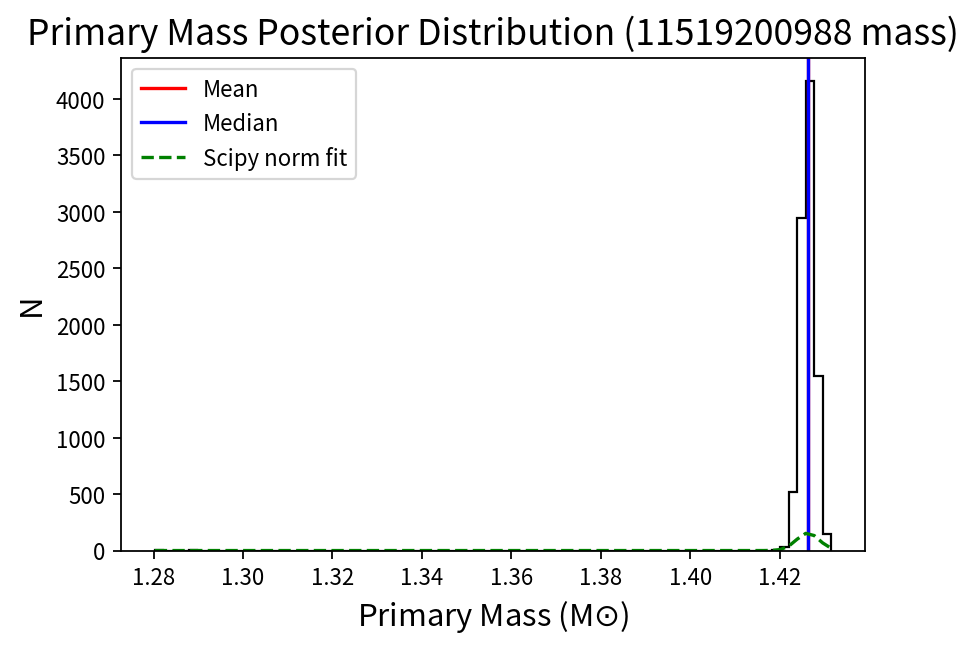

In [313]:
from astropy.modeling import models, fitting
from scipy.stats import norm
import matplotlib.mlab as mlab
import random

f,ax = plt.subplots(figsize=(6,4), facecolor='w', dpi=160)

y=pdmasses.iloc[:, ::2]
y.columns[90]

maxcol = y.shape[1]
randomStar= random.randint(0,maxcol)
randomStarName= y.columns[randomStar]

print(randomStarName)



n, bins, patches= plt.hist(pdmasses[randomStarName], bins=80, color='black', histtype = "step")
#print(n,bins)

plt.axvline(np.mean(pdmasses[randomStarName]), color="r", label='Mean')
plt.axvline(np.median(pdmasses[randomStarName]), color="b", label='Median')
plt.title(f"Primary Mass Posterior Distribution ({randomStarName})", fontsize=16)
plt.xlabel("Primary Mass (M$\odot$)", fontsize=14)
plt.ylabel("N", fontsize=14)

#fit
RVguess = bins[np.argmax(n)]
p_init = models.Gaussian1D(np.max(n), RVguess, 1)
fit_p = fitting.LevMarLSQFitter()
rvG1D = fit_p(p_init, bins[:-1], n)

mu, std = norm.fit(pdmasses[randomStarName])

best_fit_line = norm.pdf(bins, mu, std)
#print(best_fit_line)
# print(p_init)
# print(rvG1D)
plt.plot(bins, best_fit_line, 'g--', label='Scipy norm fit')
plt.legend()

print(bins[np.argmax(n)])


      10010400015 ratio  10618000016 ratio  10719500017 ratio  \
0              0.020599           0.029794           0.016536   
1              0.051145           0.026631           0.069956   
2              0.102229           0.080724           0.011167   
3              0.040008           0.021900           0.019001   
4              0.023781           0.025756           0.118626   
...                 ...                ...                ...   
9336           0.008638           0.020791           0.002490   
9337           0.027078           0.030817           0.092763   
9338           0.007795           0.036414           0.011933   
9339           0.000763           0.023837           0.000168   
9340           0.026482           0.061733           0.025745   

      11321600029 ratio  10007800034 ratio  10556700036 ratio  \
0              0.011170           0.001209           0.012238   
1              0.013303           0.011842           0.003919   
2              0.012555 

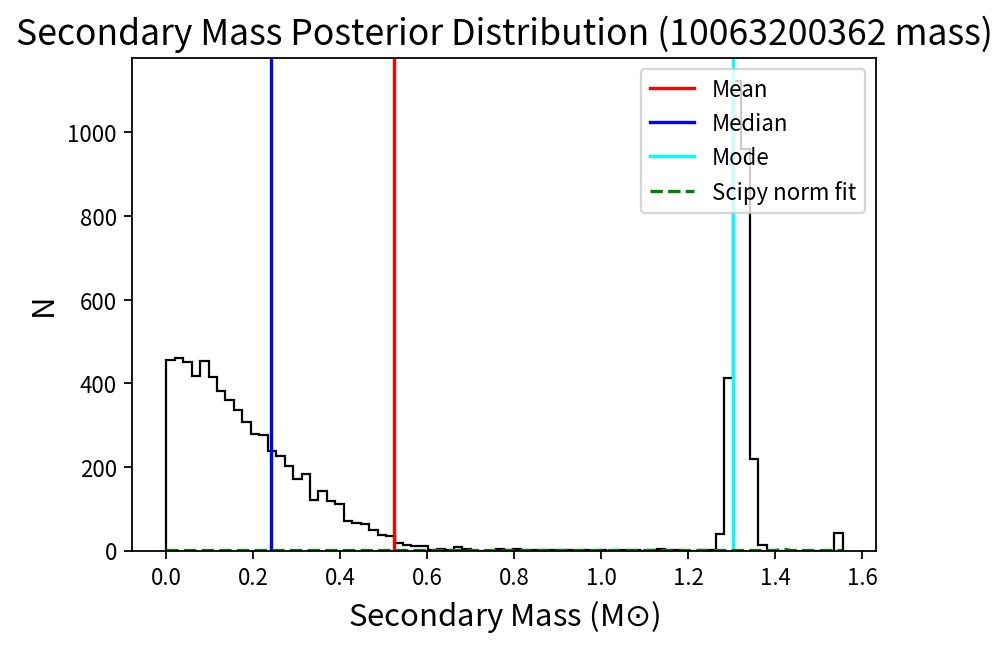

In [314]:
from astropy.modeling import models, fitting
from scipy.stats import norm
import matplotlib.mlab as mlab
import random

f,ax = plt.subplots(figsize=(6,4), facecolor='w', dpi=160) #change dpi and size later

ratios=pdmasses.iloc[:, 1::2]
primarymasses = pdmasses.iloc[:, ::2]
print(ratios)
#print(primarymass)
#print("test:",ratios.columns[90])
maxcol1 = primarymasses.shape[1]
maxcol2 = ratios.shape[1]
print(maxcol1,maxcol2)

randomStar= random.randint(0,maxcol)
randomStarNameForRatios= ratios.columns[randomStar]
randomStarNameForPrimaryMasses = primarymasses.columns[randomStar]

print(randomStarNameForRatios,randomStarNameForPrimaryMasses)

secondarymass = primarymasses[randomStarNameForPrimaryMasses]*ratios[randomStarNameForRatios]

n, bins, patches= plt.hist(secondarymass, bins=80, color='black', histtype = "step")
#print(n,bins)

plt.axvline(np.mean(secondarymass), c="r", label='Mean')
plt.axvline(np.median(secondarymass), c="b", label='Median')
plt.axvline(bins[np.argmax(n)], c='cyan', label='Mode')
plt.title(f"Secondary Mass Posterior Distribution ({randomStarNameForPrimaryMasses})", fontsize=16)
plt.xlabel("Secondary Mass (M$\odot$)", fontsize=14)
plt.ylabel("N", fontsize=14)

#fit
RVguess = bins[np.argmax(n)]
p_init = models.Gaussian1D(np.max(n), RVguess, 1)
fit_p = fitting.LevMarLSQFitter()
rvG1D = fit_p(p_init, bins[:-1], n)

mu, std = norm.fit(pdmasses[randomStarName])

best_fit_line = norm.pdf(bins, mu, std)
#print(best_fit_line)
# print(p_init)
# print(rvG1D)
plt.plot(bins, best_fit_line, 'g--', label='Scipy norm fit')
plt.legend()

print(bins[np.argmax(n)])


0       1.426109
1       1.426257
2       1.426056
3       1.425727
4       1.424101
          ...   
9336    1.427398
9337    1.426885
9338    1.428086
9339    1.425000
9340    1.426215
Name: 11519200988 mass, Length: 9341, dtype: float64


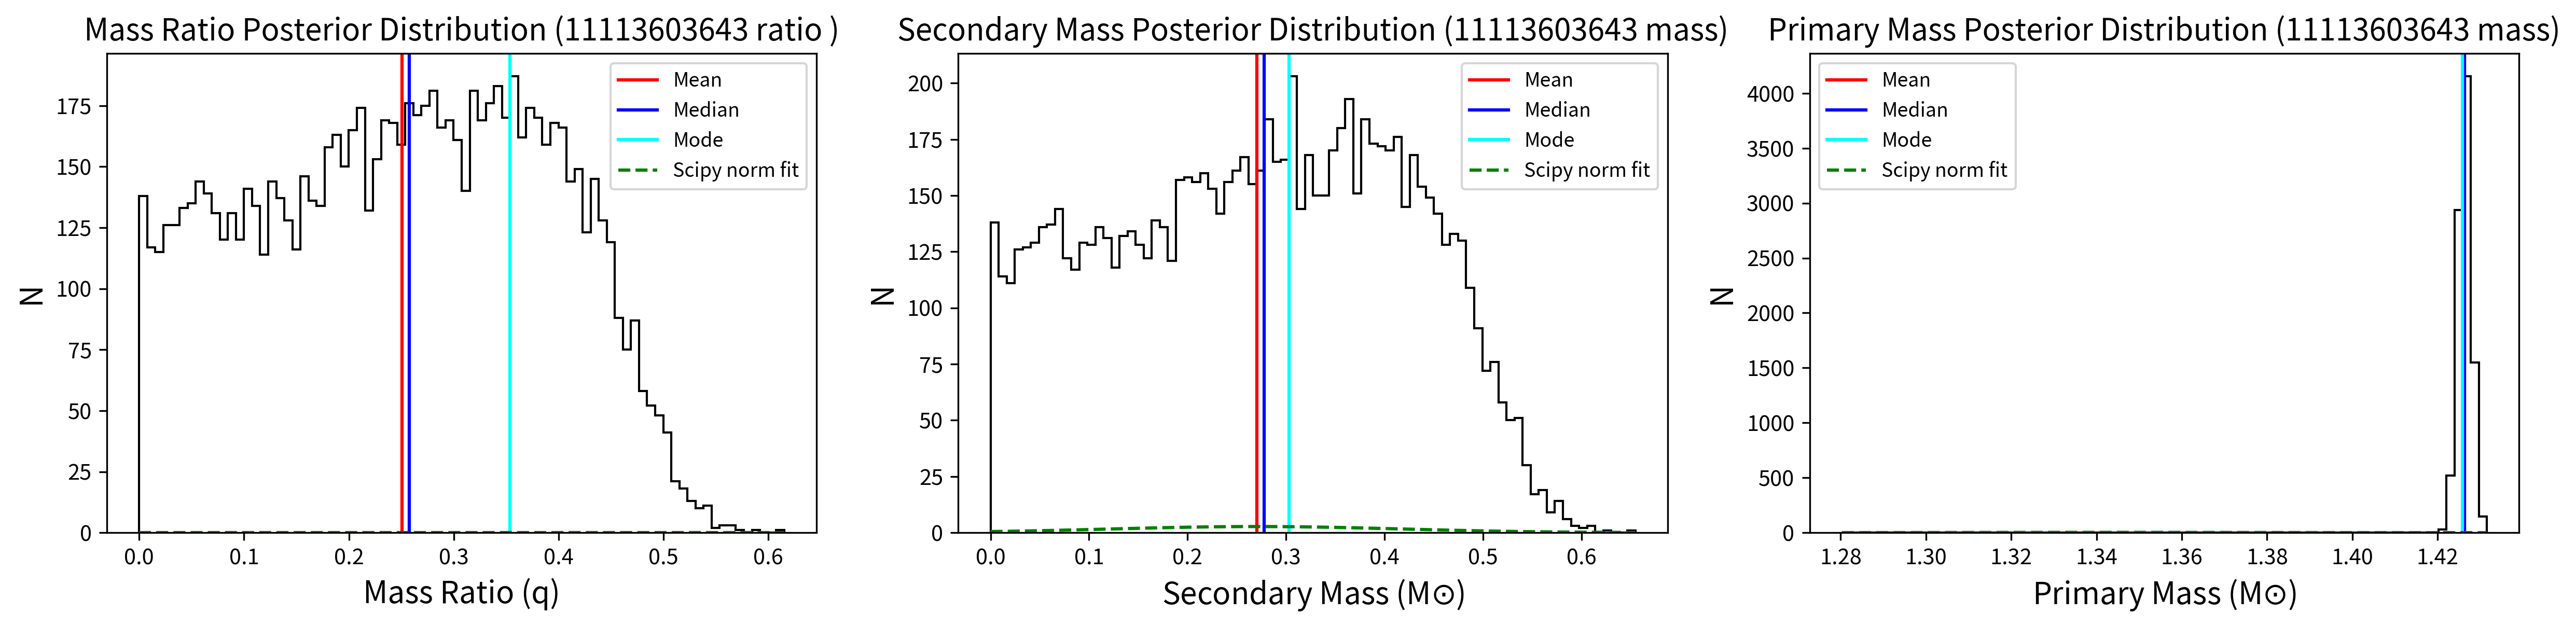

In [315]:
#mass ratio plot
from astropy.modeling import models, fitting
from scipy.stats import norm
import matplotlib.mlab as mlab
import random

f,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,4), facecolor='w', dpi=300) #change dpi and size later

ratios=pdmasses.iloc[:, 1::2]
primarymasses = pdmasses.iloc[:, ::2]
#print(ratios)
#print(primarymasses)
#print("test:",ratios.columns[90])
maxcol1 = primarymasses.shape[1]
maxcol2 = ratios.shape[1]
#print(maxcol1,maxcol2)

randomStar= random.randint(0,maxcol)
randomStarNameForRatios= ratios.columns[randomStar]
randomStarNameForPrimaryMasses = primarymasses.columns[randomStar]

#print(randomStarNameForRatios,randomStarNameForPrimaryMasses)
massratio = ratios[randomStarNameForRatios]
primarymass = pdmasses[randomStarName]
secondarymass = primarymasses[randomStarNameForPrimaryMasses]*ratios[randomStarNameForRatios]

n, bins, patches = ax1.hist(massratio, bins=80, color='black', histtype = "step")
n2, bins2, patches2 = ax2.hist(secondarymass, bins=80, color='black', histtype = "step")
n3, bins3, patches3 = ax3.hist(primarymass, bins=80, color='black', histtype = "step")


ax1.axvline(np.mean(massratio), c="r", label='Mean')
ax1.axvline(np.median(massratio), c="b", label='Median')
ax1.axvline(bins[np.argmax(n)], c='cyan', label='Mode')
ax1.set_title(f"Mass Ratio Posterior Distribution ({randomStarNameForRatios})", fontsize=14)
ax1.set_xlabel("Mass Ratio (q)", fontsize=14)
ax1.set_ylabel("N", fontsize=14)

ax2.axvline(np.mean(secondarymass), c="r", label='Mean')
ax2.axvline(np.median(secondarymass), c="b", label='Median')
ax2.axvline(bins2[np.argmax(n2)], c='cyan', label='Mode')
ax2.set_title(f"Secondary Mass Posterior Distribution ({randomStarNameForPrimaryMasses})", fontsize=14)
ax2.set_xlabel("Secondary Mass (M$\odot$)", fontsize=14)
ax2.set_ylabel("N", fontsize=14)

ax3.axvline(np.mean(primarymass), c="r", label='Mean')
ax3.axvline(np.median(primarymass), c="b", label='Median')
ax3.axvline(bins3[np.argmax(n3)], c='cyan', label='Mode')
ax3.set_title(f"Primary Mass Posterior Distribution ({randomStarNameForPrimaryMasses})", fontsize=14)
ax3.set_xlabel("Primary Mass (M$\odot$)", fontsize=14)
ax3.set_ylabel("N", fontsize=14)

#fits
# RVguess = bins[np.argmax(n)]
# p_init = models.Gaussian1D(np.max(n), RVguess, 1)
# fit_p = fitting.LevMarLSQFitter()
# rvG1D = fit_p(p_init, bins[:-1], n)
print(pdmasses[randomStarName])

mu, std = norm.fit(primarymass)
mu2, std2 = norm.fit(secondarymass)
mu3, std3 = norm.fit(massratio)

best_fit_line = norm.pdf(bins, mu, std)
best_fit_line2 = norm.pdf(bins2, mu2, std2)
best_fit_line3 = norm.pdf(bins3, mu3, std3)
#print(best_fit_line)
# print(p_init)
# print(rvG1D)
ax1.plot(bins, best_fit_line, 'g--', label='Scipy norm fit')
ax2.plot(bins2, best_fit_line2, 'g--', label='Scipy norm fit')
ax3.plot(bins3, best_fit_line2, 'g--', label='Scipy norm fit')
ax1.legend(fontsize=9)
ax2.legend(fontsize=9)
ax3.legend(fontsize=9)

#print(bins[np.argmax(n)])


(array([  1.,   0.,   0.,   0.,   1.,   1.,   2.,   2.,   6.,   2.,   6.,
          6.,   4.,   9.,  10.,  17.,  17.,  20.,  26.,  48.,  64.,  87.,
        136., 168., 200., 247., 307., 362., 472., 492., 525., 563., 583.,
        525., 585., 623., 630., 552., 471., 451., 363., 270., 198., 124.,
         81.,  42.,  24.,  14.,   3.,   1.]),
 array([0.20278858, 0.20850276, 0.21421694, 0.21993111, 0.22564529,
        0.23135947, 0.23707364, 0.24278782, 0.248502  , 0.25421617,
        0.25993035, 0.26564453, 0.2713587 , 0.27707288, 0.28278706,
        0.28850124, 0.29421541, 0.29992959, 0.30564377, 0.31135794,
        0.31707212, 0.3227863 , 0.32850047, 0.33421465, 0.33992883,
        0.345643  , 0.35135718, 0.35707136, 0.36278554, 0.36849971,
        0.37421389, 0.37992807, 0.38564224, 0.39135642, 0.3970706 ,
        0.40278477, 0.40849895, 0.41421313, 0.4199273 , 0.42564148,
        0.43135566, 0.43706984, 0.44278401, 0.44849819, 0.45421237,
        0.45992654, 0.46564072, 0.4713549 , 0.

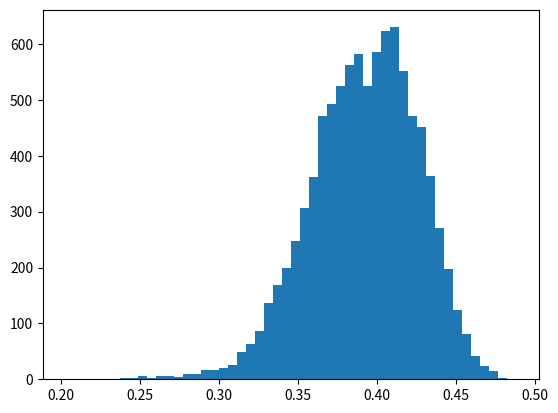

In [316]:
plt.hist(pdmasses['10000513054 mass']*pdmasses['10000513054 ratio '], bins=50)

In [317]:
# test = y.sample(axis="columns")

# print(test)
# plt.hist(test, bins=50)
# plt.axvline(np.mean(test), color="r")
# plt.axvline(np.median(test), color="g")

      11610400971 mass
0             1.431790
1             1.431992
2             1.428563
3             1.436123
4             1.435119
...                ...
9336          1.434625
9337          1.433220
9338          1.434548
9339          1.429962
9340          1.433186

[9341 rows x 1 columns]


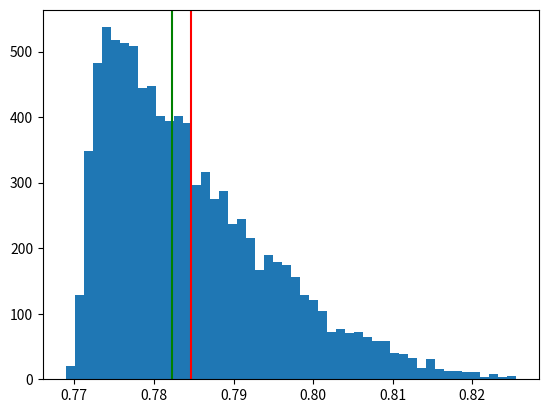

In [318]:
star = pdmasses['10053507799 mass']
test = pdmasses.sample(axis="columns")
print(test)
plt.hist(star, bins=50)
plt.axvline(np.mean(star), color="r")
plt.axvline(np.median(star), color="g")

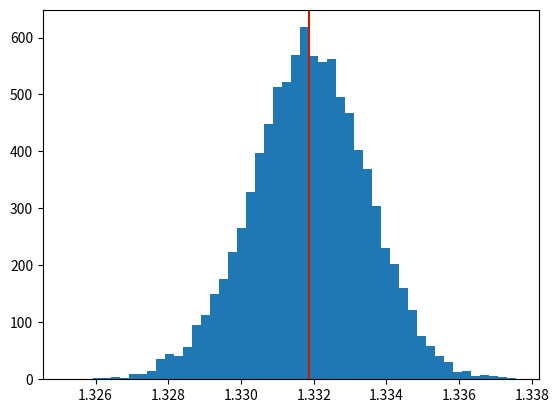

In [319]:
plt.hist(pdmasses['10004101495 mass'], bins=50)
plt.axvline(np.mean(pdmasses['10004101495 mass']), color="r")
plt.axvline(np.median(pdmasses['10004101495 mass']), color="g", alpha=0.2)

(1.42, 1.46)

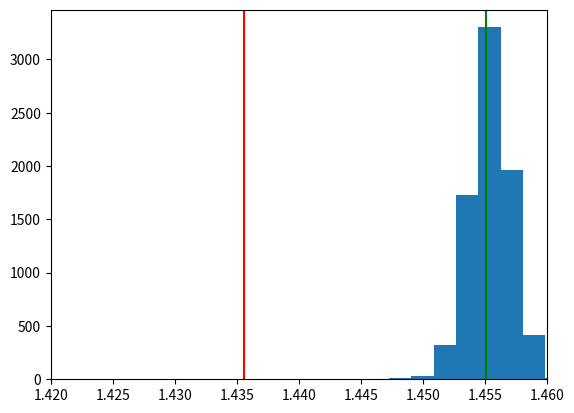

In [320]:
plt.hist(pdmasses['10029900896 mass'], bins=100)
plt.axvline(np.mean(pdmasses['10029900896 mass']), color="r")
plt.axvline(np.median(pdmasses['10029900896 mass']), color="g")
plt.xlim(1.42, 1.46)

In [321]:
# get the masses
masses = np.loadtxt(sm,skiprows=1)
print(masses.shape)
print(masses.shape[1]/2.)
print(type(masses))
masses

(9341, 3818)
1909.0
<class 'numpy.ndarray'>


array([[1.574868e+00, 2.059900e-02, 1.574715e+00, ..., 1.003900e-02,
        5.256840e-01, 9.696730e-01],
       [1.574873e+00, 5.114500e-02, 1.603571e+00, ..., 1.101270e-01,
        5.232380e-01, 9.757420e-01],
       [1.574871e+00, 1.022290e-01, 1.574714e+00, ..., 1.023070e-01,
        5.177560e-01, 9.911330e-01],
       ...,
       [1.575338e+00, 7.795000e-03, 1.575173e+00, ..., 1.105910e-01,
        5.420270e-01, 8.871600e-01],
       [1.575336e+00, 7.630000e-04, 1.575184e+00, ..., 5.834500e-02,
        5.229460e-01, 9.685820e-01],
       [1.575334e+00, 2.648200e-02, 1.575180e+00, ..., 2.437940e-01,
        5.207020e-01, 9.599510e-01]])

In [322]:
# get the memberships 
membership = np.loadtxt(mem)
print(membership.shape)

(9341, 1909)


In [323]:
#calculate the binary fraction
from scipy import stats
nBinary = 0
nCluster = 0
count = 0
# m1ArrTot = []
for i in range(0,masses.shape[1],2):
    # get the row in the phot file
    iden = int(massIDs[i])
    row = phot.loc[(phot['id'] == iden)]
    #print(row['id'])
    
    # get the column in the membership file
    
    imem = int((i/2))
    memArr = membership[:,imem]
    memMean = np.mean(memArr)
    memStd = np.std(memArr)
    
     #add to the phot df
    phot.at[row.index[0], 'memMean'] = memMean
    phot.at[row.index[0], 'memStd'] = memStd
    
    if (memMean - 3*memStd > 0):
        phot.at[row.index[0], 'member'] = True

        nCluster += 1
        
        # get the masses
        m1Arr = masses[:,i]
        #print(m1Arr)
        # m1ArrTot.append(m1Arr)
        qArr = masses[:,(i + 1)]
        m2Arr = m1Arr*qArr
        m2Mean = np.mean(m2Arr)
        m1Mean = np.mean(m1Arr)
        m2Std = np.std(m2Arr)
        qMean = np.mean(qArr)
        qStd = np.std(qArr)

        # add to the phot df masses (to do)
        phot.at[row.index[0], 'qMean'] = qMean
        phot.at[row.index[0], 'qStd'] = qStd
        phot.at[row.index[0], 'm1Mean'] = m1Mean
        phot.at[row.index[0], 'm2Mean'] = m2Mean
    #print(stats.percentileofscore(m2Arr, 0))
        #if (stats.percentileofscore(m2Arr, 0) > 0.2): #3sigma below median (49.8%)
        if (m2Mean - 3*m2Std > 0): #if there is a greater than 3sig difference from mean, include as binary
            nBinary += 1
            phot.at[row.index[0], 'binary'] = True
            
        if (qMean>=0.5): #exclude mass ratios < .5 
            count += 1
            
    #print(m1Arr)   
print("# Binaries:", nBinary, "\n# Cluster objects:", nCluster, \
 "\nBinary Fraction:", nBinary/nCluster, "\nStd:", np.sqrt(nBinary)/nCluster, \
  "\nq>=0.5 Binaries:", count, "\nq>=0.5 binary fraction:", count/nCluster, \
    "\nq>=0.5 std:", np.sqrt(count)/nCluster)

# Binaries: 471 
# Cluster objects: 1726 
Binary Fraction: 0.2728852838933951 
Std: 0.01257389015887063 
q>=0.5 Binaries: 409 
q>=0.5 binary fraction: 0.2369640787949015 
q>=0.5 std: 0.011717119592211288


In [324]:
# plt.hist(m1ArrTot)
# plt.xlim(0,10)

In [325]:
#include only cluster members and nonbinary stars
singlePhot = phot.loc[(phot['member']) & (phot['binary']== False)]
singlePhot['binary'].unique() #check all binary columns are false
# singlePhot

array([False])

In [326]:
#include only binary stars
binaryPhot = phot.loc[phot['binary']]
binaryPhot['binary'].unique() #check all binary columns are true
#photBinary

array([ True])

In [327]:
#select photometry between magnitudes for single and binary stars
topmag=15
bottommag=18.5
cutSinglePhot = singlePhot.loc[(singlePhot['G']  > topmag) & (singlePhot['G']  < bottommag)]
cutBinaryPhot = binaryPhot.loc[(binaryPhot['G']  > topmag) & (binaryPhot['G']  < bottommag)]
# cutSinglePhot
# cutBinaryPhot

In [328]:
binaryPhot

id        G     G_BP     G_RP     g_ps     r_ps     i_ps  \
18    10079200118  12.5085  13.0806  11.7925  99.9000  99.9000  99.9000   
19    10014000119  12.5173  13.1115  11.7863  13.3066  12.6870  12.2810   
20    10291800122  12.5621  13.1809  11.8130  13.3745  12.7150  12.3100   
21    10320700125  12.5894  13.1961  11.8481  13.3969  12.7100  12.3140   
22    10276600132  12.6390  13.2478  11.8866  13.3457  13.0830  12.5690   
...           ...      ...      ...      ...      ...      ...      ...   
1877  10588715865  19.2640  19.9550  18.4009  20.2450  19.1709  18.7523   
1879  11196416068  19.2877  99.9000  99.9000  99.9000  99.9000  99.9000   
1880  10006017074  19.4167  99.9000  99.9000  99.9000  99.9000  18.6213   
1883  11717518632  19.6066  99.9000  99.9000  99.9000  19.6921  18.1839   
1887  10845519896  19.7562  99.9000  99.9000  21.2210  19.8649  19.2195   

         z_ps     y_ps    J_2M  ...    m1Mean  m1Std    m2Mean  m2Std  \
18    99.9000  99.9000  10.843  ...  1.587656     -2  1.543199     -4   
19    12.0270  11.9090  10.790  ...  1.595815     -2  1.452335     -4   
20    12.0640  11.9320  10.804  ...  1.598595     -2  1.277282     -4   
21    12.0760  11.9540  10.844  ...  1.594874     -2  1.401906     -4   
22    12.2340  12.0017  10.867  ...  1.597176     -2  1.316464     -4   
...       ...      ...     ...  ...       ...    ...       ...    ...   
1877  99.9000  18.1414  99.900  ...  0.705049     -2  0.343375     -4   
1879  99.9000  99.9000  16.319  ...  0.641565     -2  0.624274     -4   
1880  99.9000  99.9000  99.900  ...  0.635973     -2  0.619667     -4   
1883  18.7557  18.6017  99.900  ...  0.655270     -2  0.448548     -4   
1887  18.8601  18.7397  99.900  ...  0.647034     -2  0.371122     -4   

         qMean      qStd   memMean        memStd  member  binary  
18    0.972027  0.052500  0.995932  6.365169e-02    True    True  
19    0.910220  0.182120  0.944925  2.280457e-01    True    True  
20    0.799065  0.166017  0.999998  3.616864e-05    True    True  
21    0.879090  0.047201  0.998533  3.405517e-02    True    True  
22    0.824260  0.047268  0.999882  2.579837e-03    True    True  
...        ...       ...       ...           ...     ...     ...  
1877  0.487273  0.092093  1.000000  0.000000e+00    True    True  
1879  0.973296  0.023495  0.998745  1.297811e-02    True    True  
1880  0.974574  0.021689  1.000000  0.000000e+00    True    True  
1883  0.686959  0.124208  1.000000  5.665158e-08    True    True  
1887  0.573841  0.065644  1.000000  0.000000e+00    True    True  

[471 rows x 38 columns]

In [329]:
print(binaryPhot[binaryPhot['m1Mean'] == -1]['m1Mean'])

Series([], Name: m1Mean, dtype: float64)


In [330]:
binaryGaiaData = pd.merge(originalGaia, binaryPhot, on=['G','G_BP'])
singleGaiaData = pd.merge(originalGaia, singlePhot, on=['G','G_BP'])
cutBinaryGaiaData = pd.merge(originalGaia, cutBinaryPhot, on=['G','G_BP'])
cutSingleGaiaData = pd.merge(originalGaia, cutSinglePhot, on=['G','G_BP'])

# cutBinaryGaiaData

In [331]:
cutSingleGaiaData['distance'] = findSeparation(cutSingleGaiaData)
cutBinaryGaiaData['distance'] = findSeparation(cutBinaryGaiaData)
singleGaiaData['distance'] = findSeparation(singleGaiaData)
binaryGaiaData['distance'] = findSeparation(binaryGaiaData)

In [332]:
# #massratio CDF
# f,ax = plt.subplots(figsize=(9,6), facecolor='w', dpi=300)

# single = qcutSingle['distance']
# binary = qcutBinary['distance']

# singleSample = single.shape[0]
# binarySample = binary.shape[0]

# singlehist = ax.hist(single, cumulative = True, density = True, histtype = "step", bins = 1500, color='b', label=f'Single stars (n={singleSample}) ')
# binaryhist = ax.hist(binary, cumulative = True, density = True, histtype = "step", bins = 1500,color='g', label= f'Binary stars (n={binarySample}) ')

# ks_result, twoside_pvalue = ks_2samp(single,binary)
# ks_result, less_pvalue = ks_2samp(single,binary,alternative='less')

# plt.xlabel("Angular Distance From Center (degrees)", fontsize=13)
# plt.ylabel("Percentage of Stars", fontsize=13)
# plt.title("CDF of NGC 6819 Gaia Members with q >= 0.5", fontsize=15)
# plt.grid(linestyle='--', alpha=0.3)

# #plt.text(.008, .88, 'K-S "two-sided" P-value: 0.00032\nK-S "less" P-value: 0.970\nBinary sample: 347\nSingle sample: 35',fontsize = 10, 
# #          bbox = dict(facecolor='w', boxstyle='round', edgecolor='lightgray'))
# # custom_lines = [Line2D([0], [0], color='g',alpha=1, lw=2, ls='-'),
# #                                 Line2D([0], [0], color='b',alpha=1, lw=2, ls='-'),
# #                                 Line2D([0], [0], color='b',alpha=1, lw=2, ls='-')]

# twoside= ax.plot(1, 1, alpha= 0, label=f'K-S "two-sided" P-value: {twoside_pvalue:.5f}', color=None, linestyle=None)
# less= ax.plot(1, 1, alpha= 0, label=f'K-S "two-sided" P-value: {less_pvalue:.5f}', color=None, linestyle=None)
# ax.legend(loc=2, fontsize=8)
# #leg = ax.legend(handlelength=0, handletextpad=0, fancybox=True, loc=2, fontsize=9)
# #plt.legend(custom_lines, ['Binary stars', 'Single stars'],loc=2, fontsize=10)

# #plt.annotate(text="Binary stars", color='g', xy=(.104,.81), xytext=(.104,.81), size=12)
# #plt.annotate(text="Single stars", color='b', xy=(.155,.69), xytext=(.155,.69), size=12)
# from matplotlib.ticker import PercentFormatter
# plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
# ax.yaxis.get_ticklocs(minor=True)
# ax.minorticks_on()
# ax.tick_params(which='both', direction="in")
# ax.tick_params(axis='both', pad=8)
# ax.set_xlim(0,.314)
# plt.show()

In [333]:
binaryGaiaData['m1Mean']

0      0.844400
1      1.194867
2      0.686451
3      1.328925
4      0.948358
         ...   
448    0.868141
449    0.793533
450    1.016734
451    0.761930
452    0.728307
Name: m1Mean, Length: 453, dtype: float64

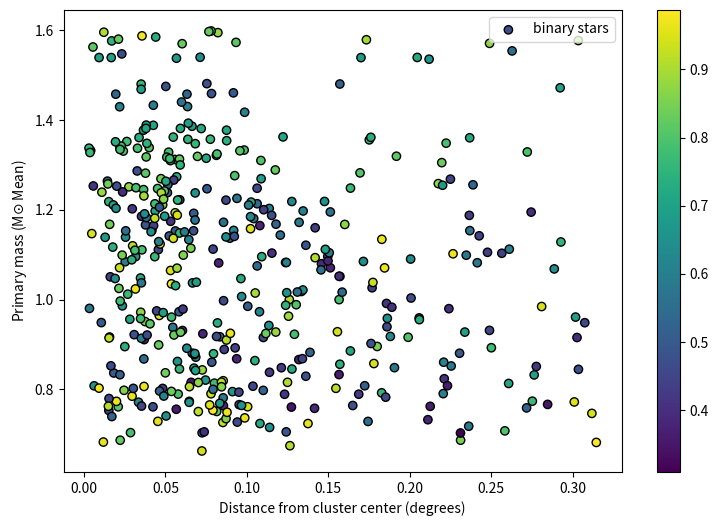

In [334]:
f,ax = plt.subplots(figsize=(9,6))
r= binaryGaiaData['qMean']
#plt.scatter(singleGaiaData['distance'], singleGaiaData['m1Mean'], color='b', label="single stars")
plt.scatter(binaryGaiaData['distance'], binaryGaiaData['m1Mean'], c=r, cmap=plt.cm.get_cmap("viridis"), edgecolor='black', label='binary stars')
plt.colorbar()
plt.xlabel("Distance from cluster center (degrees)")
plt.ylabel("Primary mass (M$\odot$ Mean)")
plt.legend()

In [335]:
print(np.max(binaryGaiaData['m1Mean']))

1.5985949163901083


0      0.844400
1      1.194867
2      0.686451
3      1.328925
4      0.948358
         ...   
448    0.868141
449    0.793533
450    1.016734
451    0.761930
452    0.728307
Name: m1Mean, Length: 453, dtype: float64

0.009989749493478087
0.01750000893223937
0.00031660508789669694


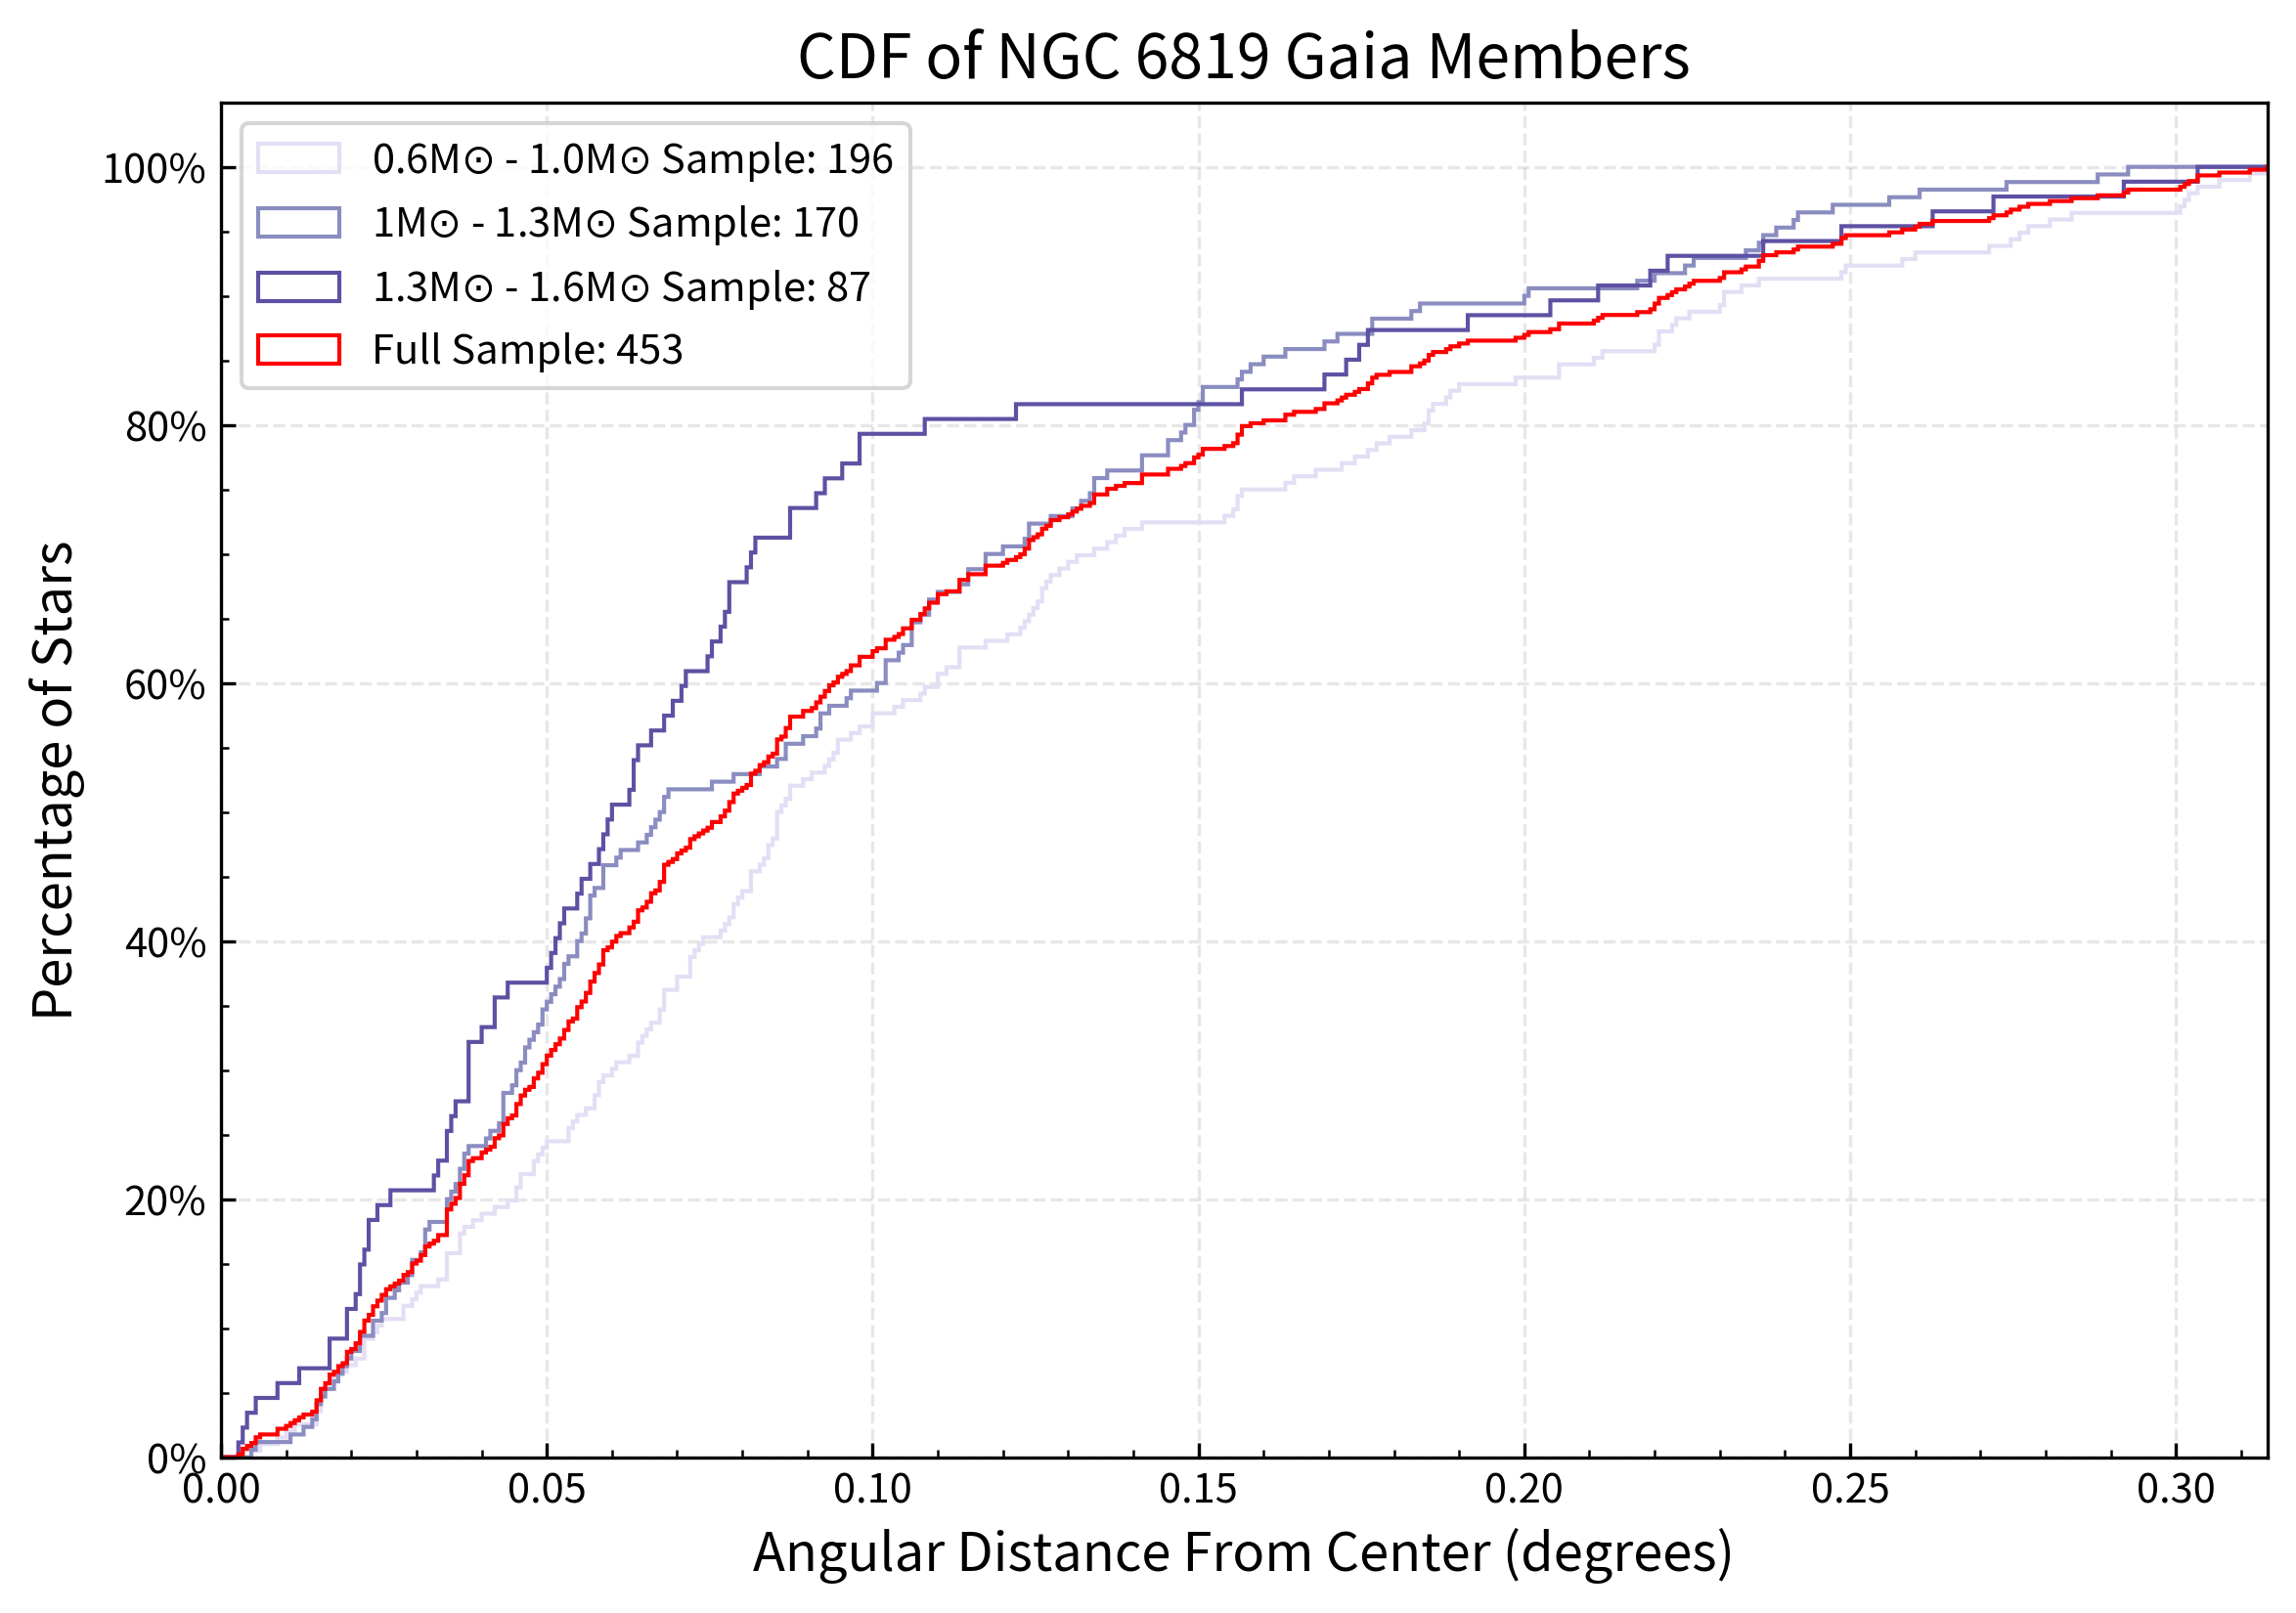

In [387]:
#mass ranges CDF
f,ax = plt.subplots(figsize=(9,6), facecolor='w', dpi=300)

binaryfilter1 = binaryGaiaData.loc[(binaryGaiaData['m1Mean']  >= np.min(binaryGaiaData['m1Mean'])) & (binaryGaiaData['m1Mean']  <= 1)]
binaryfilter2 = binaryGaiaData.loc[(binaryGaiaData['m1Mean']  > 1) & (binaryGaiaData['m1Mean']  <=  1.3)]
binaryfilter3 = binaryGaiaData.loc[(binaryGaiaData['m1Mean']  > 1.3 ) & (binaryGaiaData['m1Mean']  <=  np.max(binaryGaiaData['m1Mean']))]

#print(binaryfilter1)
#binary = binaryGaiaData.loc[(binaryGaiaData['m1Mean']  > 1) & (binaryGaiaData['m1Mean']  <  1.3)]

bin1 = binaryfilter1['distance']
bin2 = binaryfilter2['distance']
bin3 = binaryfilter3['distance']
allbinaries = binaryGaiaData['distance']

bin1Sample = bin1.shape[0]
bin2Sample = bin2.shape[0]
bin3Sample = bin3.shape[0]
allSample = binaryGaiaData.shape[0]
# print(binary)

ax.hist(bin1, cumulative = True, density = True, range=(0,1), histtype = "step", bins = 1500, color='#e4def5', label=f'0.6M$\odot$ - 1.0M$\odot$ Sample: {bin1Sample}')
ax.hist(bin2, cumulative = True, density = True, range=(0,1), histtype = "step", bins = 1500,color='#8A8DC0', label=f'1M$\odot$ - 1.3M$\odot$ Sample: {bin2Sample}')
ax.hist(bin3, cumulative = True, density = True, range=(0,1), histtype = "step", bins = 1500,color='#5D51A3', label=f'1.3M$\odot$ - 1.6M$\odot$ Sample: {bin3Sample}')
ax.hist(allbinaries, cumulative = True, density = True, range=(0,1), histtype = "step", bins = 1500,color='r', label=f'Full Sample: {allSample}')


ks_result, twoside_pvalue1 = ks_2samp(bin1,bin2)
ks_result, less_pvalue1 = ks_2samp(bin1,bin2,alternative='less')
print(twoside_pvalue1)

ks_result, twoside_pvalue2 = ks_2samp(bin2,bin3)
ks_result, less_pvalue2= ks_2samp(bin2,bin3,alternative='less')
print(twoside_pvalue2)

ks_result, twoside_pvalue3= ks_2samp(bin1,bin3)
ks_result, less_pvalue3 = ks_2samp(bin1,bin3,alternative='less')
print(twoside_pvalue3 )

plt.xlabel("Angular Distance From Center (degrees)", fontsize=13)
plt.ylabel("Percentage of Stars", fontsize=13)
plt.title("CDF of NGC 6819 Gaia Members", fontsize=15)
plt.legend(loc='upper left')
# plt.text(.008, .88, f'K-S "two-sided" P-value: {twoside_pvalue:.5f}\nK-S "less" P-value: {less_pvalue:.5f}\n1.0M$\odot$ - 1.3M$\odot$ Sample: {binarySample}\n0.6M$\odot$ - 1.0M$\odot$ Sample: {singleSample}',fontsize = 10, 
#          bbox = dict(facecolor='w', boxstyle='round', edgecolor='lightgray'))
# custom_lines = [ Line2D([0], [0], color='g',alpha=1, lw=2, ls='-'),
#                                 Line2D([0], [0], color='b',alpha=1, lw=2, ls='-'), ]
plt.grid(linestyle='--', alpha=0.3)
#plt.legend(custom_lines, ['Binary stars', 'Single stars'],loc=2, fontsize=10)
# plt.annotate(text="Binary stars", color='g', xy=(.104,.81), xytext=(.104,.81), size=12)
# plt.annotate(text="Single stars", color='b', xy=(.155,.69), xytext=(.155,.69), size=12)
from matplotlib.ticker import PercentFormatter
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

ax.yaxis.get_ticklocs(minor=True)
ax.minorticks_on()
ax.tick_params(which='both', direction="in")
ax.set_xlim(0,.314)
plt.show()

0.9545797278749781
0.3620149996078792
0.34677430632003214


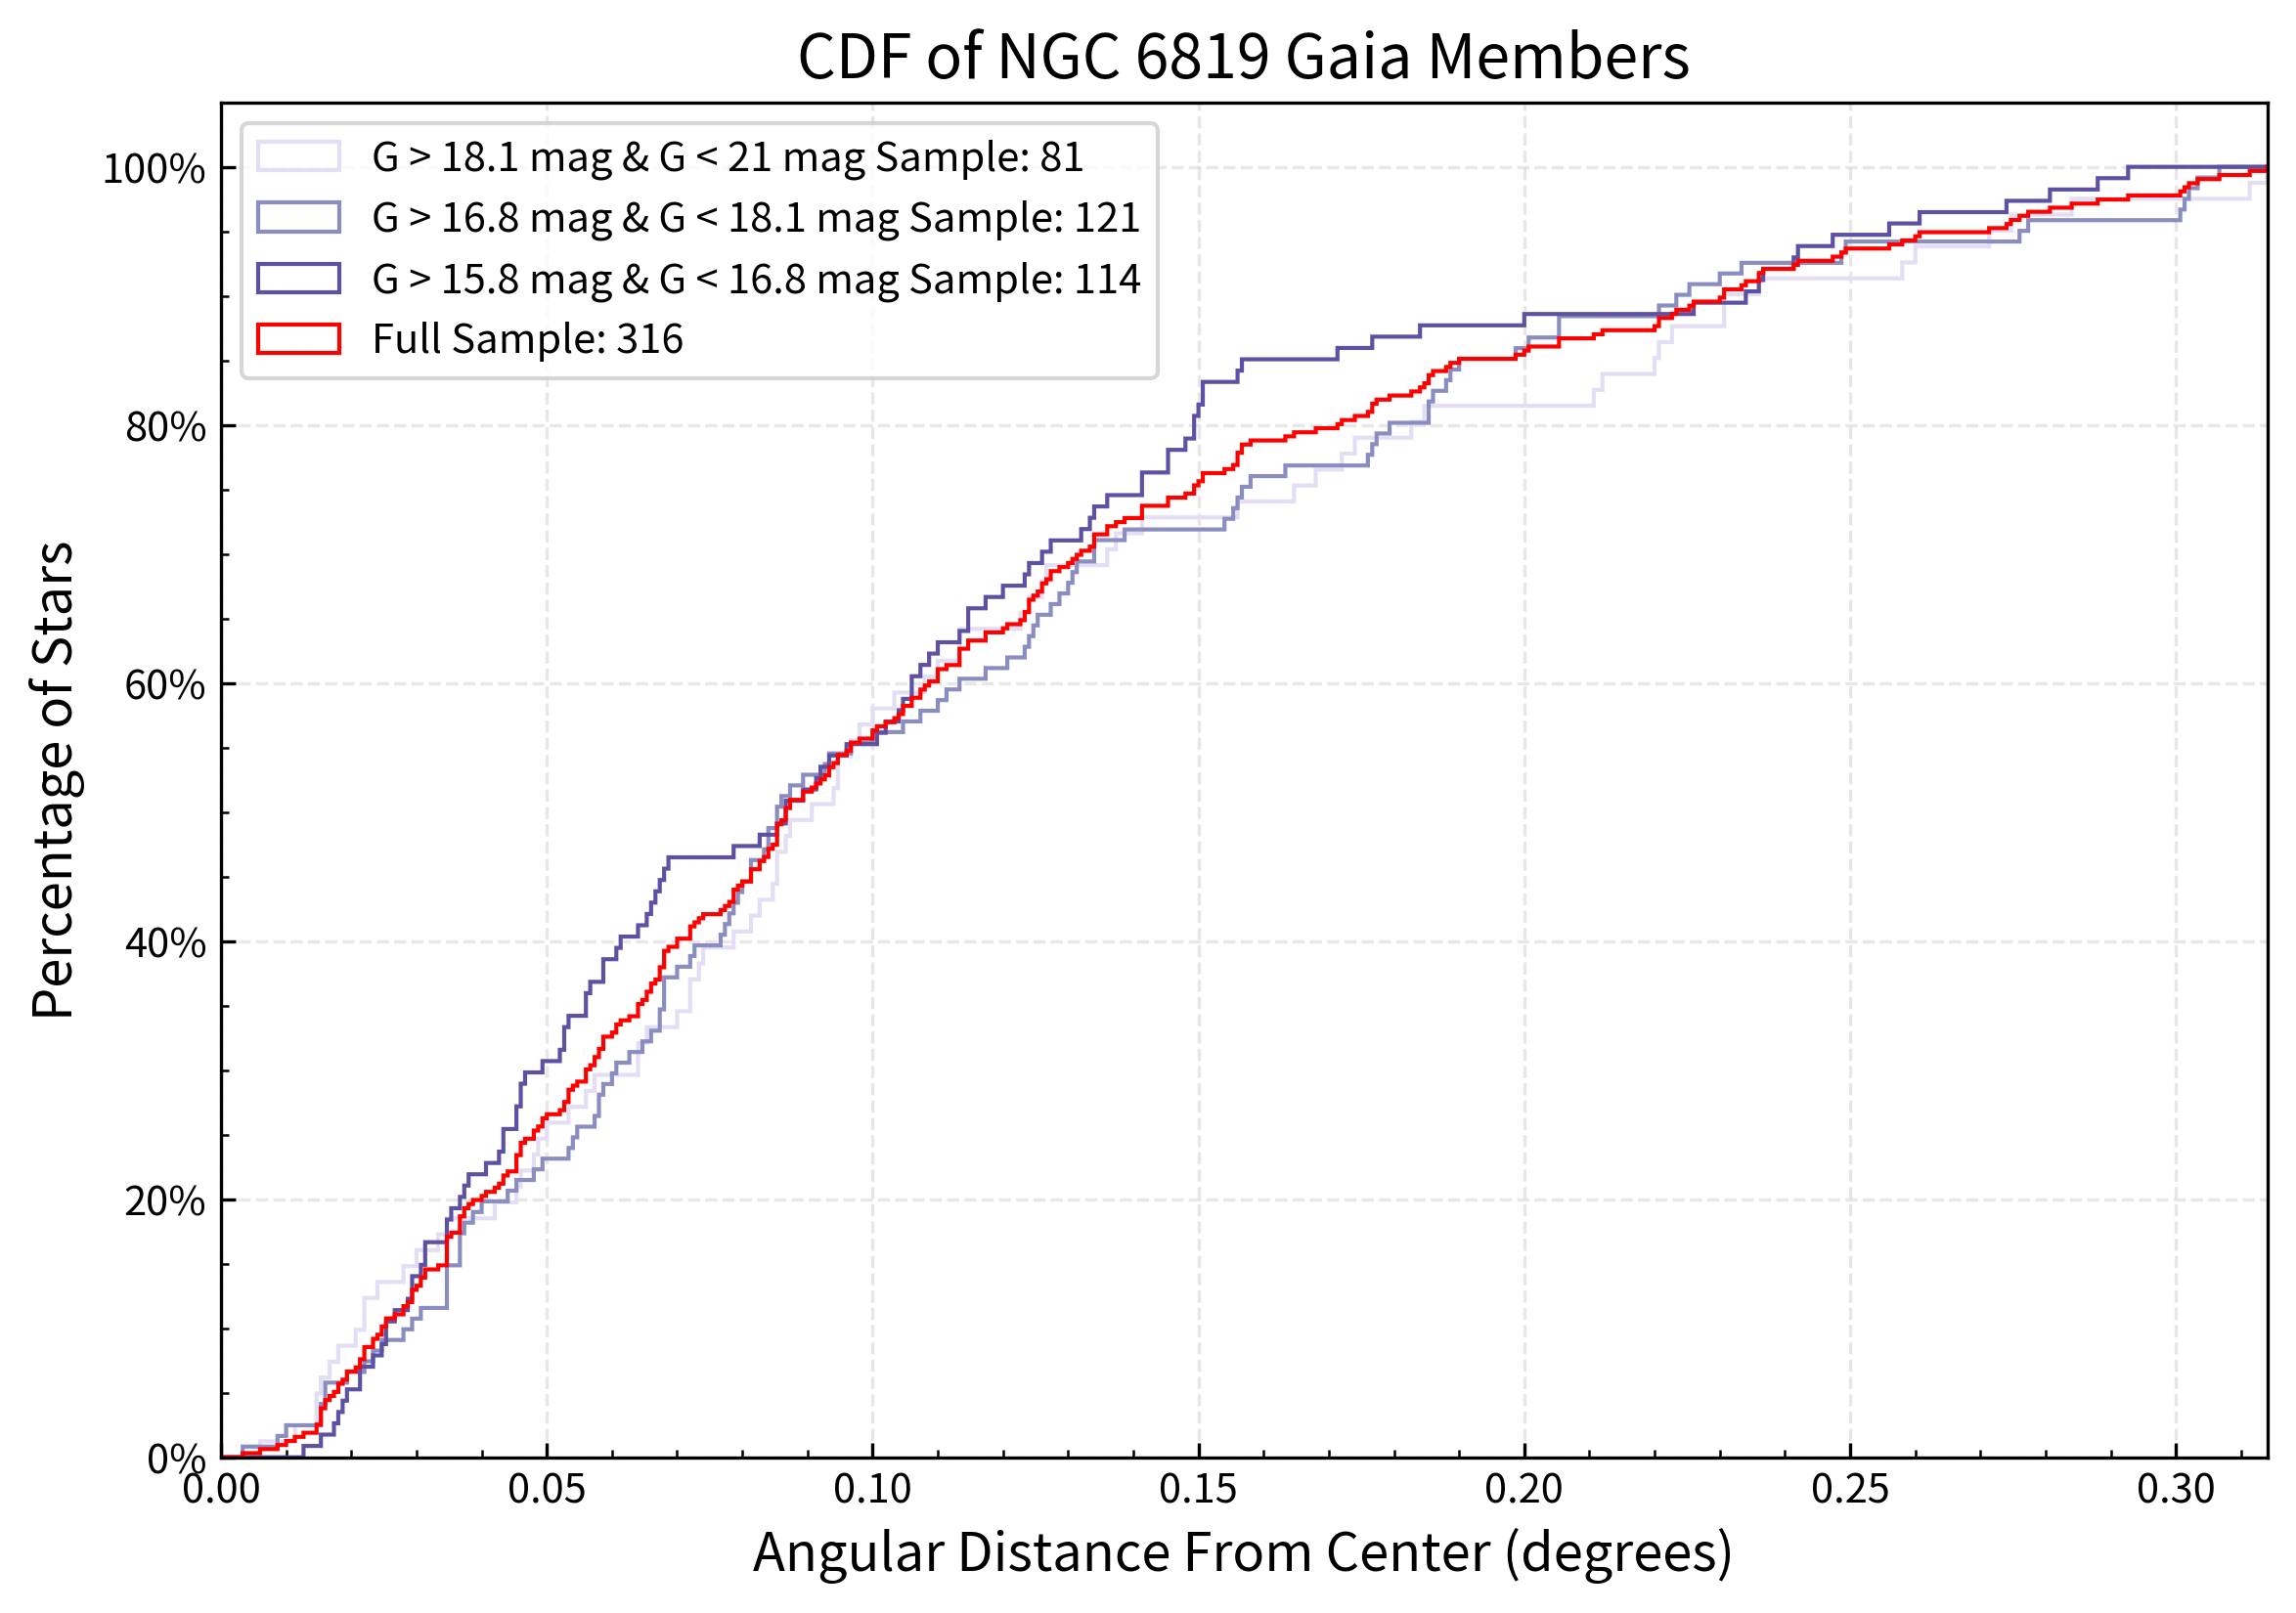

In [391]:
#G magnitude ranges CDF
f,ax = plt.subplots(figsize=(9,6), facecolor='w', dpi=300)

#filters from lowest mag to highest mag
binaryfilter1 = binaryGaiaData.loc[(binaryGaiaData['G']  >= 18.1) & (binaryGaiaData['G']  <= 21)]
binaryfilter2 = binaryGaiaData.loc[(binaryGaiaData['G']  > 16.8) & (binaryGaiaData['G']  <=  18.1)]
binaryfilter3 = binaryGaiaData.loc[(binaryGaiaData['G']  > 15.8 ) & (binaryGaiaData['G']  <=  16.8)]
binaryfilterAll = binaryGaiaData.loc[(binaryGaiaData['G']  <= 21) & (binaryGaiaData['G']  > 15.8 )]
#print(binaryfilter1)
#binary = binaryGaiaData.loc[(binaryGaiaData['m1Mean']  > 1) & (binaryGaiaData['m1Mean']  <  1.3)]

bin1 = binaryfilter1['distance']
bin2 = binaryfilter2['distance']
bin3 = binaryfilter3['distance']
allbinaries = binaryfilterAll['distance']
#print(binaryfilter1)

bin1Sample = bin1.shape[0]
bin2Sample = bin2.shape[0]
bin3Sample = bin3.shape[0]
allSample = bin1Sample + bin2Sample + bin3Sample
# print(binary)

ax.hist(bin1, cumulative = True, density = True, range=(0,1), histtype = "step", bins = 1500, color='#e4def5', label=f'G > 18.1 mag & G < 21 mag Sample: {bin1Sample}')
ax.hist(bin2, cumulative = True, density = True, range=(0,1), histtype = "step", bins = 1500,color='#8A8DC0', label=f'G > 16.8 mag & G < 18.1 mag Sample: {bin2Sample}')
ax.hist(bin3, cumulative = True, density = True, range=(0,1), histtype = "step", bins = 1500,color='#5D51A3', label=f'G > 15.8 mag & G < 16.8 mag Sample: {bin3Sample}')
ax.hist(allbinaries, cumulative = True, density = True, range=(0,1), histtype = "step", bins = 1500,color='r', label=f'Full Sample: {allSample}')


ks_result, twoside_pvalue1 = ks_2samp(bin1,bin2)
ks_result, less_pvalue1 = ks_2samp(bin1,bin2,alternative='less')
print(twoside_pvalue1)

ks_result, twoside_pvalue2 = ks_2samp(bin2,bin3)
ks_result, less_pvalue2= ks_2samp(bin2,bin3,alternative='less')
print(twoside_pvalue2)

ks_result, twoside_pvalue3= ks_2samp(bin1,bin3)
ks_result, less_pvalue3 = ks_2samp(bin1,bin3,alternative='less')
print(twoside_pvalue3 )

plt.xlabel("Angular Distance From Center (degrees)", fontsize=13)
plt.ylabel("Percentage of Stars", fontsize=13)
plt.title("CDF of NGC 6819 Gaia Members", fontsize=15)
plt.legend(loc='upper left')
# plt.text(.008, .88, f'K-S "two-sided" P-value: {twoside_pvalue:.5f}\nK-S "less" P-value: {less_pvalue:.5f}\n1.0M$\odot$ - 1.3M$\odot$ Sample: {binarySample}\n0.6M$\odot$ - 1.0M$\odot$ Sample: {singleSample}',fontsize = 10, 
#          bbox = dict(facecolor='w', boxstyle='round', edgecolor='lightgray'))
# custom_lines = [ Line2D([0], [0], color='g',alpha=1, lw=2, ls='-'),
#                                 Line2D([0], [0], color='b',alpha=1, lw=2, ls='-'), ]
plt.grid(linestyle='--', alpha=0.3)
#plt.legend(custom_lines, ['Binary stars', 'Single stars'],loc=2, fontsize=10)
# plt.annotate(text="Binary stars", color='g', xy=(.104,.81), xytext=(.104,.81), size=12)
# plt.annotate(text="Single stars", color='b', xy=(.155,.69), xytext=(.155,.69), size=12)
from matplotlib.ticker import PercentFormatter
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

ax.yaxis.get_ticklocs(minor=True)
ax.minorticks_on()
ax.tick_params(which='both', direction="in")
ax.set_xlim(0,.314)
plt.show()

0.004447343448980906


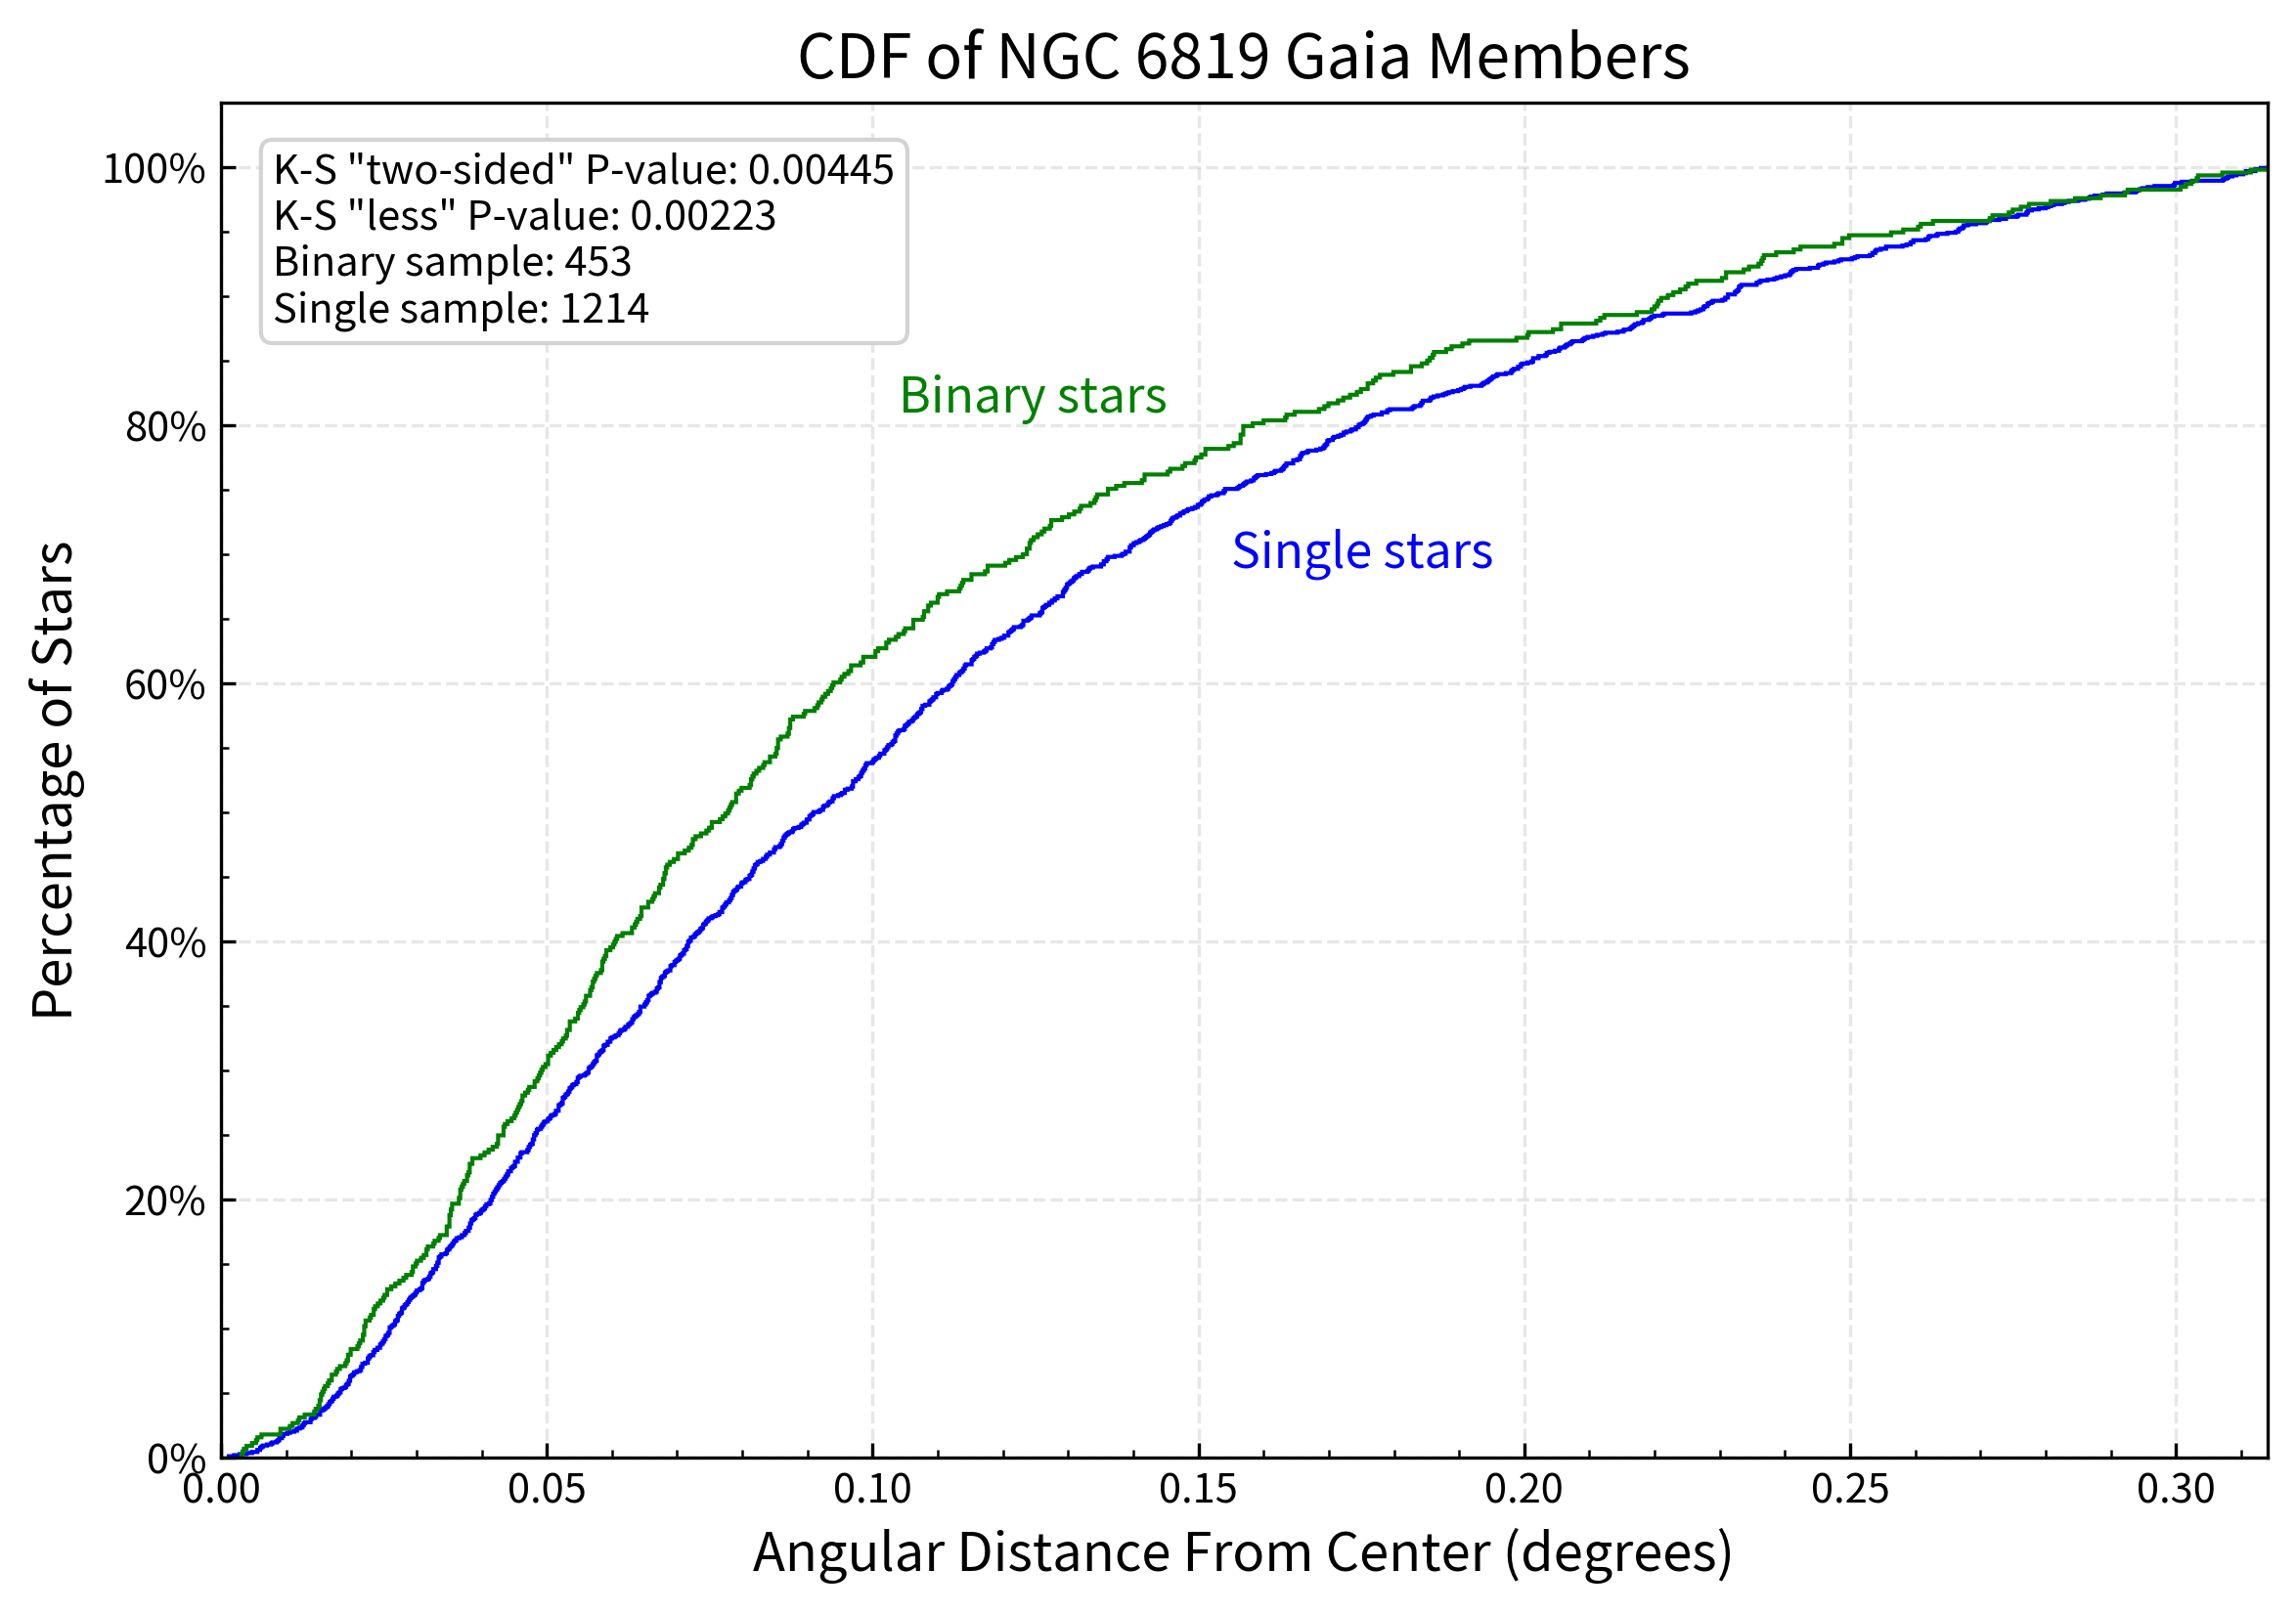

In [338]:
#full sample CDF
f,ax = plt.subplots(figsize=(9,6), facecolor='w', dpi=300)

single = singleGaiaData['distance']
binary = binaryGaiaData['distance']

singleSample = single.shape[0]
binarySample = binary.shape[0]

ax.hist(single, cumulative = True, density = True, histtype = "step", bins = 1500, color='b')
ax.hist(binary, cumulative = True, density = True, histtype = "step", bins = 1500,color='g')

ks_result, twoside_pvalue = ks_2samp(single,binary)
ks_result, less_pvalue = ks_2samp(single,binary,alternative='less')
print(twoside_pvalue)

plt.xlabel("Angular Distance From Center (degrees)", fontsize=13)
plt.ylabel("Percentage of Stars", fontsize=13)
plt.title("CDF of NGC 6819 Gaia Members", fontsize=15)
plt.text(.008, .88, f'K-S "two-sided" P-value: {twoside_pvalue:.5f}\nK-S "less" P-value: {less_pvalue:.5f}\nBinary sample: {binarySample}\nSingle sample: {singleSample}',fontsize = 10, 
         bbox = dict(facecolor='w', boxstyle='round', edgecolor='lightgray'))
custom_lines = [ Line2D([0], [0], color='g',alpha=1, lw=2, ls='-'),
                                Line2D([0], [0], color='b',alpha=1, lw=2, ls='-'), ]
plt.grid(linestyle='--', alpha=0.3)
#plt.legend(custom_lines, ['Binary stars', 'Single stars'],loc=2, fontsize=10)
plt.annotate(text="Binary stars", color='g', xy=(.104,.81), xytext=(.104,.81), size=12)
plt.annotate(text="Single stars", color='b', xy=(.155,.69), xytext=(.155,.69), size=12)
from matplotlib.ticker import PercentFormatter
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
ax.yaxis.get_ticklocs(minor=True)
ax.minorticks_on()
ax.tick_params(which='both', direction="in")
ax.set_xlim(0,.314)
plt.show()

0.0837712718470728


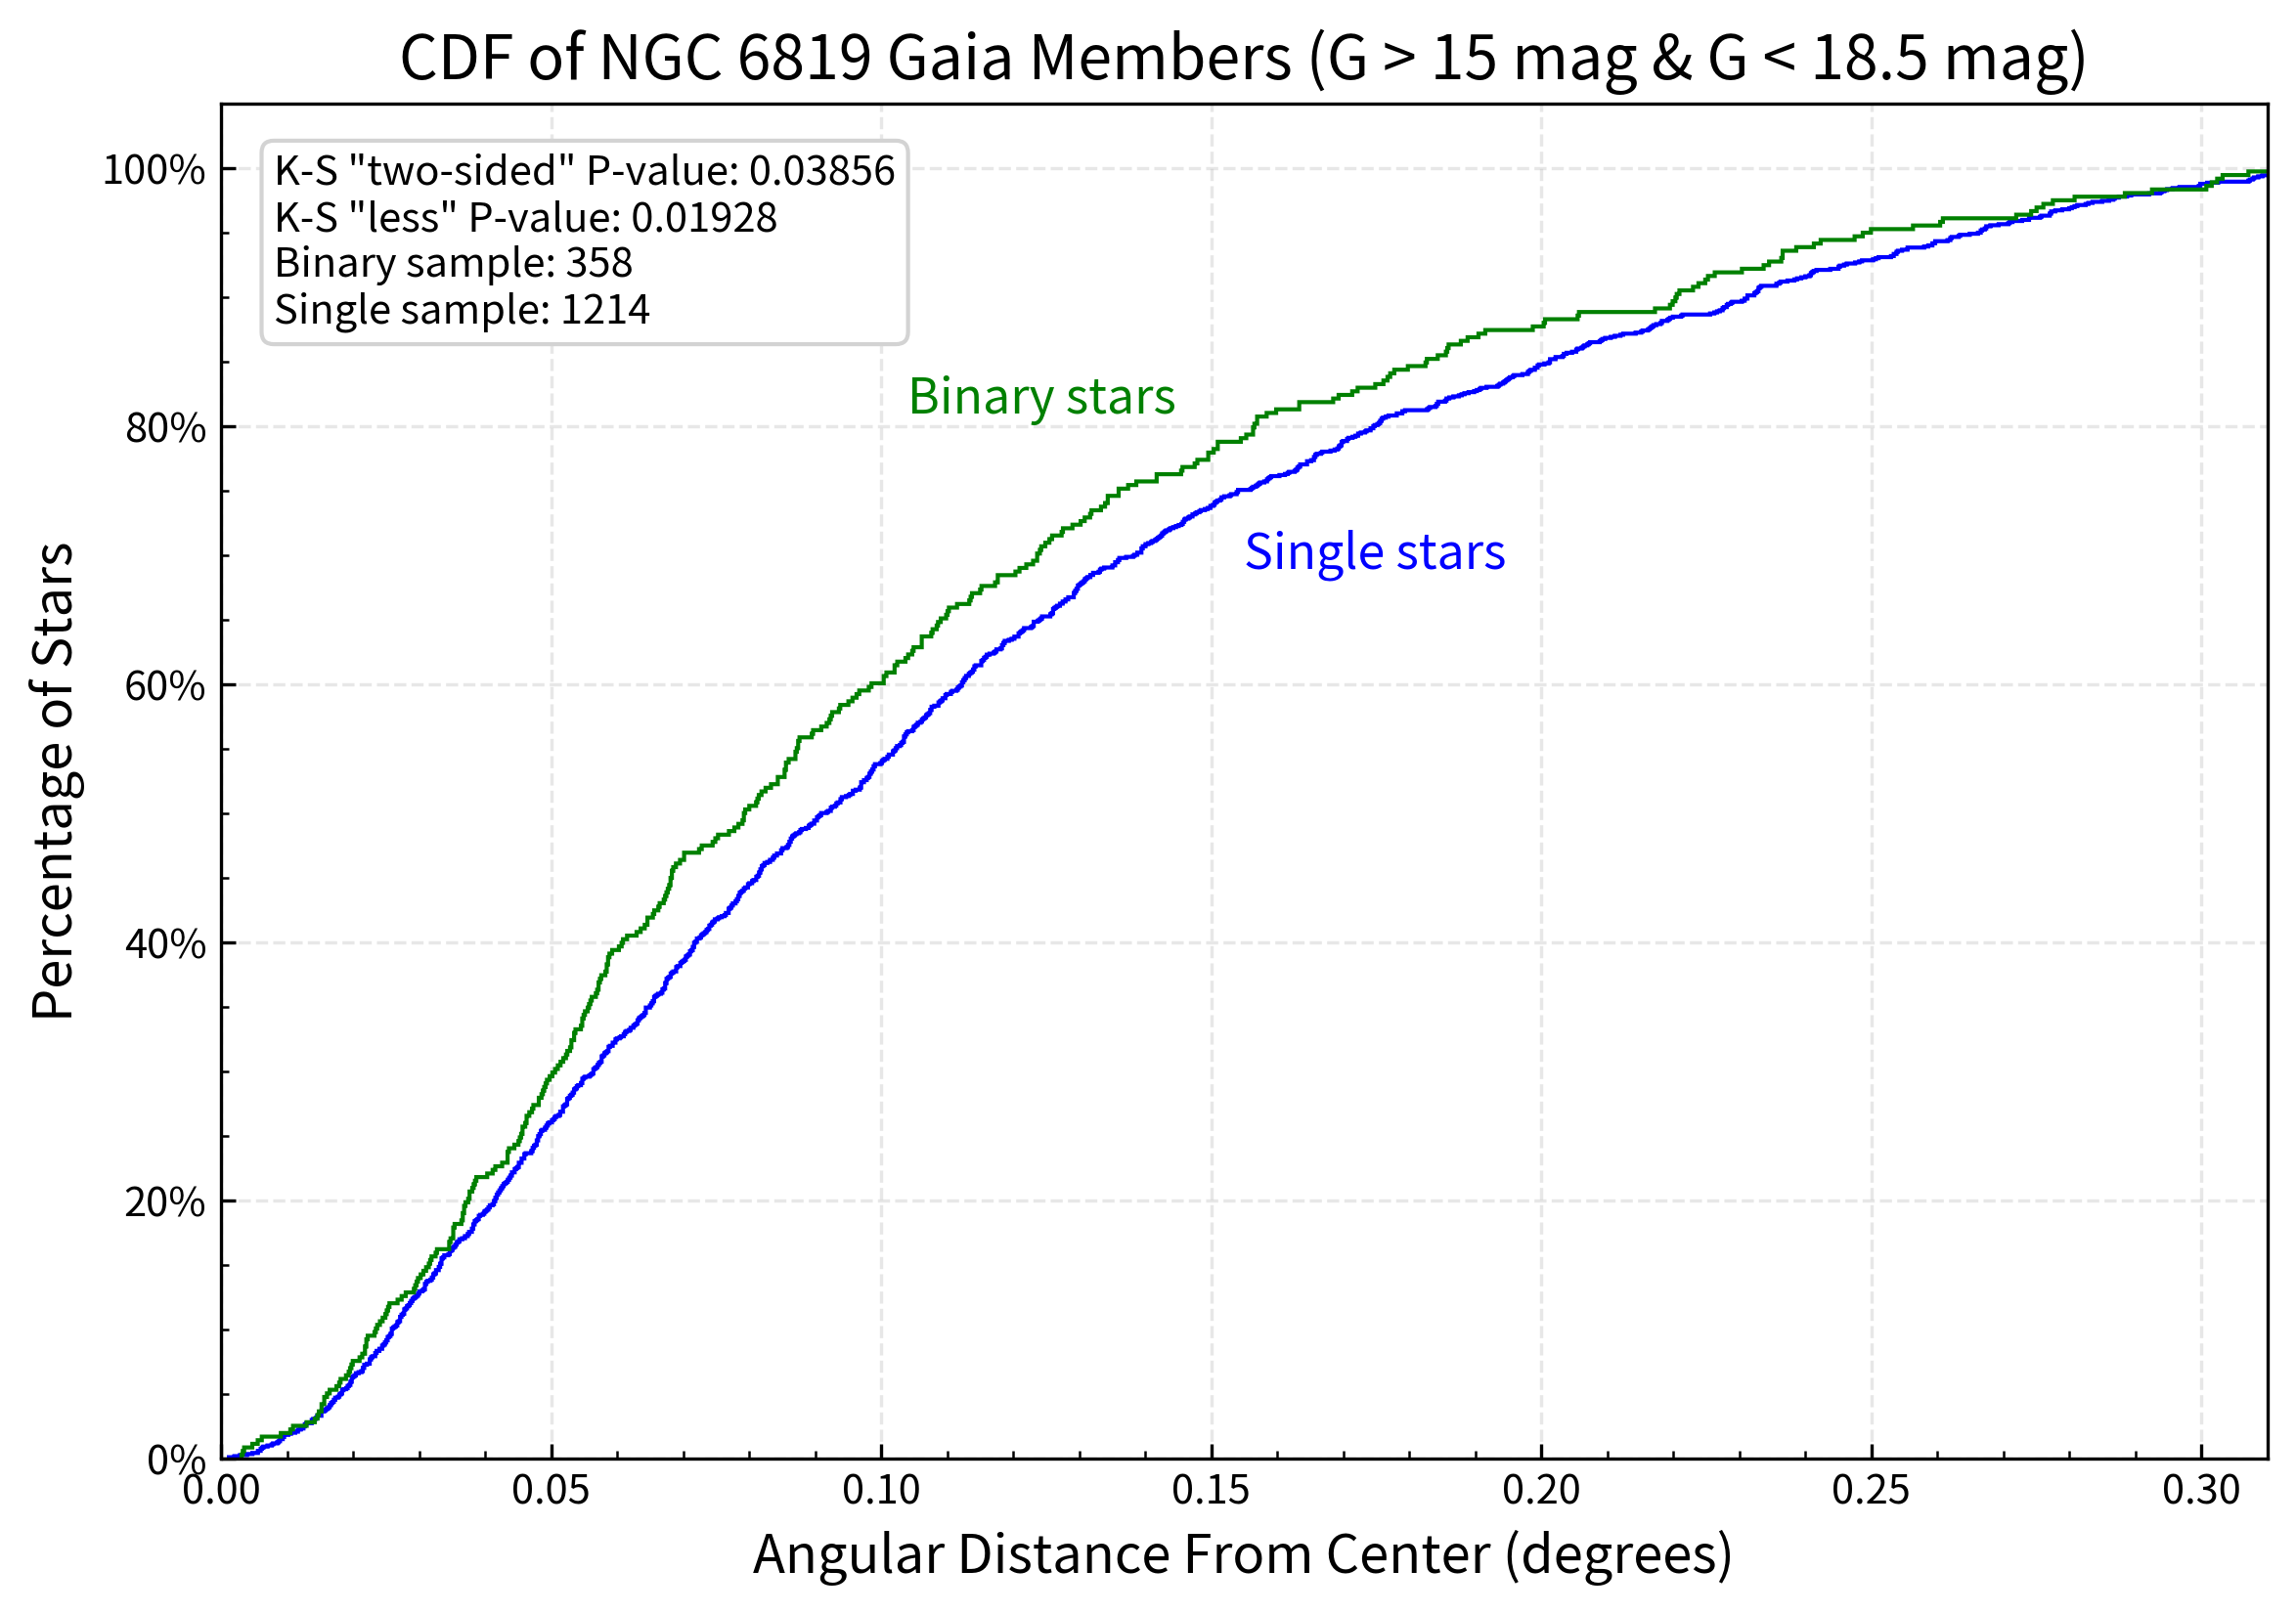

In [339]:
#topmag and bottommag CDF
f,ax = plt.subplots(figsize=(9,6), facecolor='w', dpi=300)

single = singleGaiaData['distance']
binary = cutBinaryGaiaData['distance']

singleSample = single.shape[0]
binarySample = binary.shape[0]

ax.hist(single, cumulative = True, density = True, histtype = "step", bins = 1500, color='b')
ax.hist(binary, cumulative = True, density = True, histtype = "step", bins = 1500,color='g')

ks_result, twoside_pvalue = ks_2samp(single,binary)
ks_result, less_pvalue = ks_2samp(single,binary,alternative='less')
print(ks_result)

plt.xlabel("Angular Distance From Center (degrees)", fontsize=13)
plt.ylabel("Percentage of Stars", fontsize=13)
plt.title("CDF of NGC 6819 Gaia Members (G > 15 mag & G < 18.5 mag)", fontsize=15)
plt.text(.008, .88, f'K-S "two-sided" P-value: {twoside_pvalue:.5f}\nK-S "less" P-value: {less_pvalue:.5f}\nBinary sample: {binarySample}\nSingle sample: {singleSample}',fontsize = 10, 
         bbox = dict(facecolor='w', boxstyle='round', edgecolor='lightgray'))
custom_lines = [ Line2D([0], [0], color='g',alpha=1, lw=2, ls='-'),
                                Line2D([0], [0], color='b',alpha=1, lw=2, ls='-')]
plt.grid(linestyle='--', alpha=0.3)
#plt.legend(custom_lines, ['Binary stars', 'Single stars'],loc=2, fontsize=10)
plt.annotate(text="Binary stars", color='g', xy=(.104,.81), xytext=(.104,.81), size=12)
plt.annotate(text="Single stars", color='b', xy=(.155,.69), xytext=(.155,.69), size=12)
from matplotlib.ticker import PercentFormatter
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
ax.yaxis.get_ticklocs(minor=True)
ax.minorticks_on()
ax.tick_params(which='both', direction="in")
ax.set_xlim(0,.31)
plt.show()

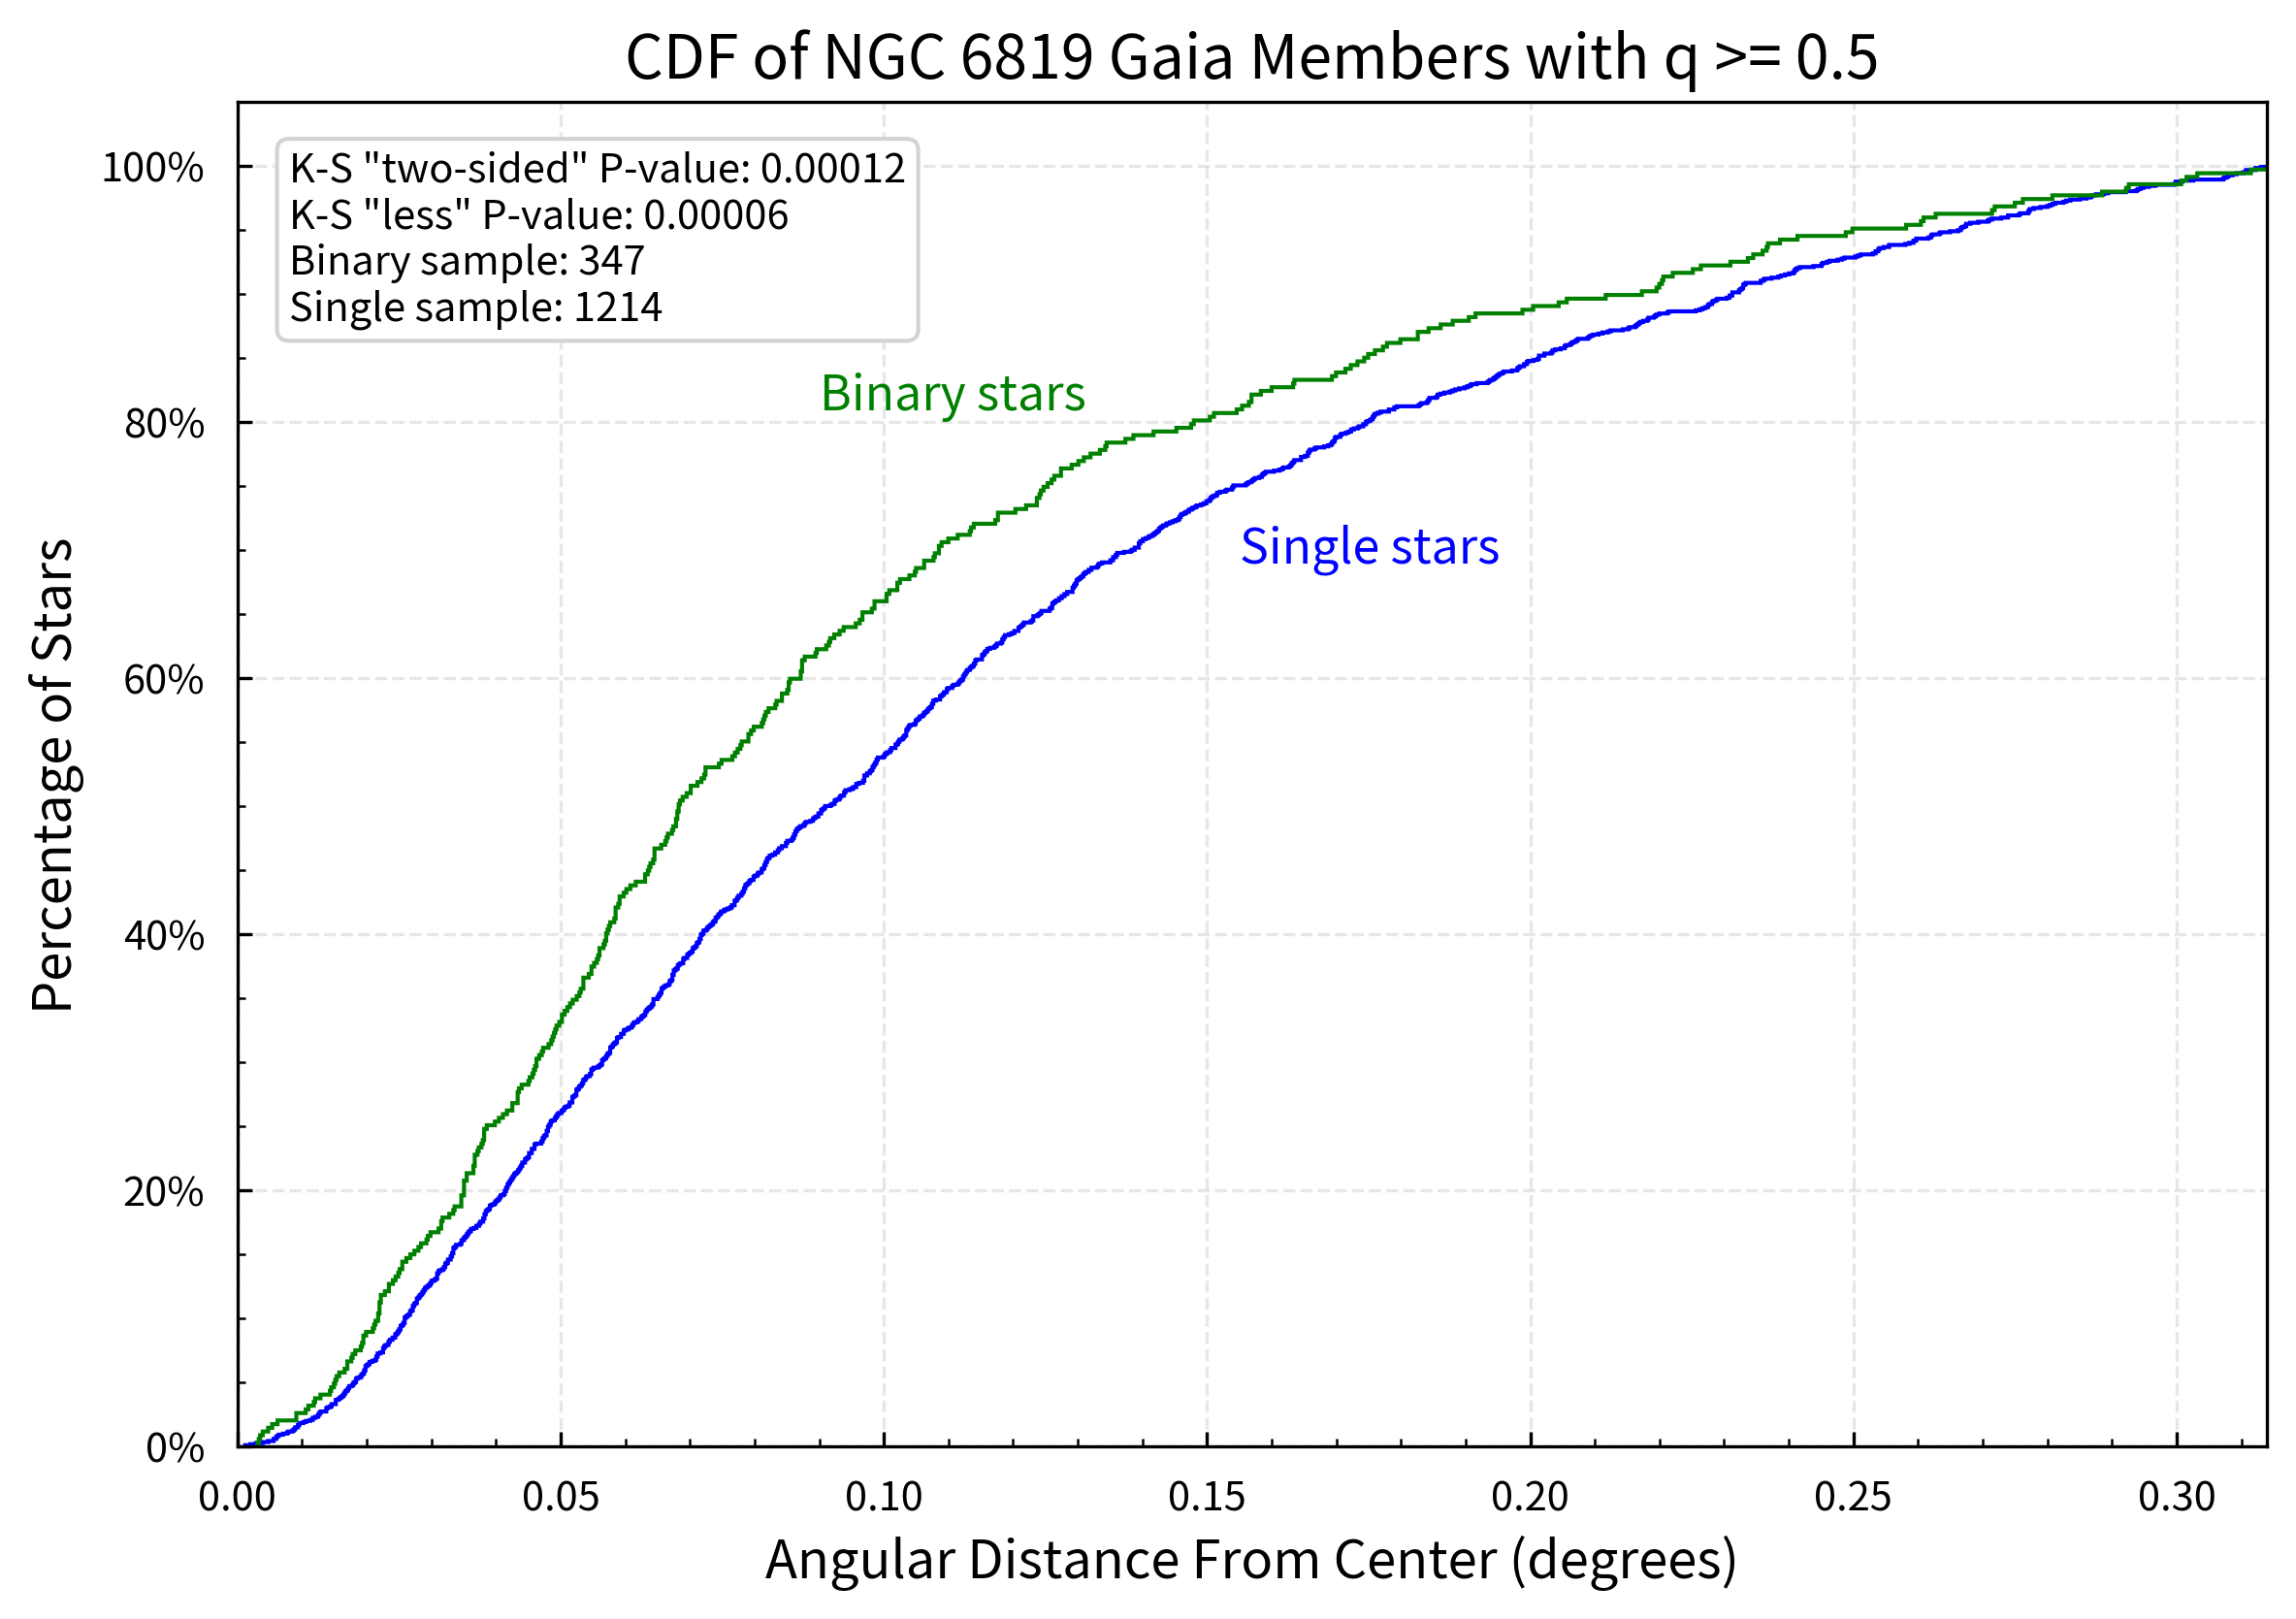

In [340]:
#massratio CDF
# Select rows where qMean is greater than or equal to 0.5
qcutSingle = singleGaiaData[singleGaiaData['qMean'] >= 0.00000000001]
qcutBinary = binaryGaiaData[binaryGaiaData['qMean'] >= 0.5]

f,ax = plt.subplots(figsize=(9,6), facecolor='w', dpi=300)

single = qcutSingle['distance']
binary = qcutBinary['distance']

singleSample = single.shape[0]
binarySample = binary.shape[0]

singlehist = ax.hist(single, cumulative = True, density = True, histtype = "step", bins = 1500, color='b', label=f'Single stars (n={singleSample}) ')
binaryhist = ax.hist(binary, cumulative = True, density = True, histtype = "step", bins = 1500,color='g', label= f'Binary stars (n={binarySample}) ')

ks_result, twoside_pvalue = ks_2samp(single,binary)
ks_result, less_pvalue = ks_2samp(single,binary,alternative='less')

plt.xlabel("Angular Distance From Center (degrees)", fontsize=13)
plt.ylabel("Percentage of Stars", fontsize=13)
plt.title("CDF of NGC 6819 Gaia Members with q >= 0.5", fontsize=15)
plt.grid(linestyle='--', alpha=0.3)

plt.text(.008, .88, f'K-S "two-sided" P-value: {twoside_pvalue:.5f}\nK-S "less" P-value: {less_pvalue:.5f}\nBinary sample: {binarySample}\nSingle sample: {singleSample}',fontsize = 10, 
         bbox = dict(facecolor='w', boxstyle='round', edgecolor='lightgray'))
custom_lines = [Line2D([0], [0], color='g',alpha=1, lw=2, ls='-'),
                                Line2D([0], [0], color='b',alpha=1, lw=2, ls='-'),]

# twoside= ax.plot(1, 1, alpha= 0, label=f'K-S "two-sided" P-value: {twoside_pvalue:.5f}', color=None, linestyle=None)
# less= ax.plot(1, 1, alpha= 0, label=f'K-S "two-sided" P-value: {less_pvalue:.5f}', color=None, linestyle=None)
#ax.legend(loc=2, fontsize=8)
#leg = ax.legend(handlelength=0, handletextpad=0, fancybox=True, loc=2, fontsize=9)
#plt.legend(custom_lines, ['Binary stars', 'Single stars'],loc=2, fontsize=10)

plt.annotate(text="Binary stars", color='g', xy=(.09,.81), xytext=(.09,.81), size=12)
plt.annotate(text="Single stars", color='b', xy=(.155,.69), xytext=(.155,.69), size=12)
from matplotlib.ticker import PercentFormatter
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
ax.yaxis.get_ticklocs(minor=True)
ax.minorticks_on()
ax.tick_params(which='both', direction="in")
ax.tick_params(axis='both', pad=8)
ax.set_xlim(0,.314)
plt.show()

In [341]:
Nbins= np.linspace(1, 1.4, 6)
print(Nbins)

[1.   1.08 1.16 1.24 1.32 1.4 ]


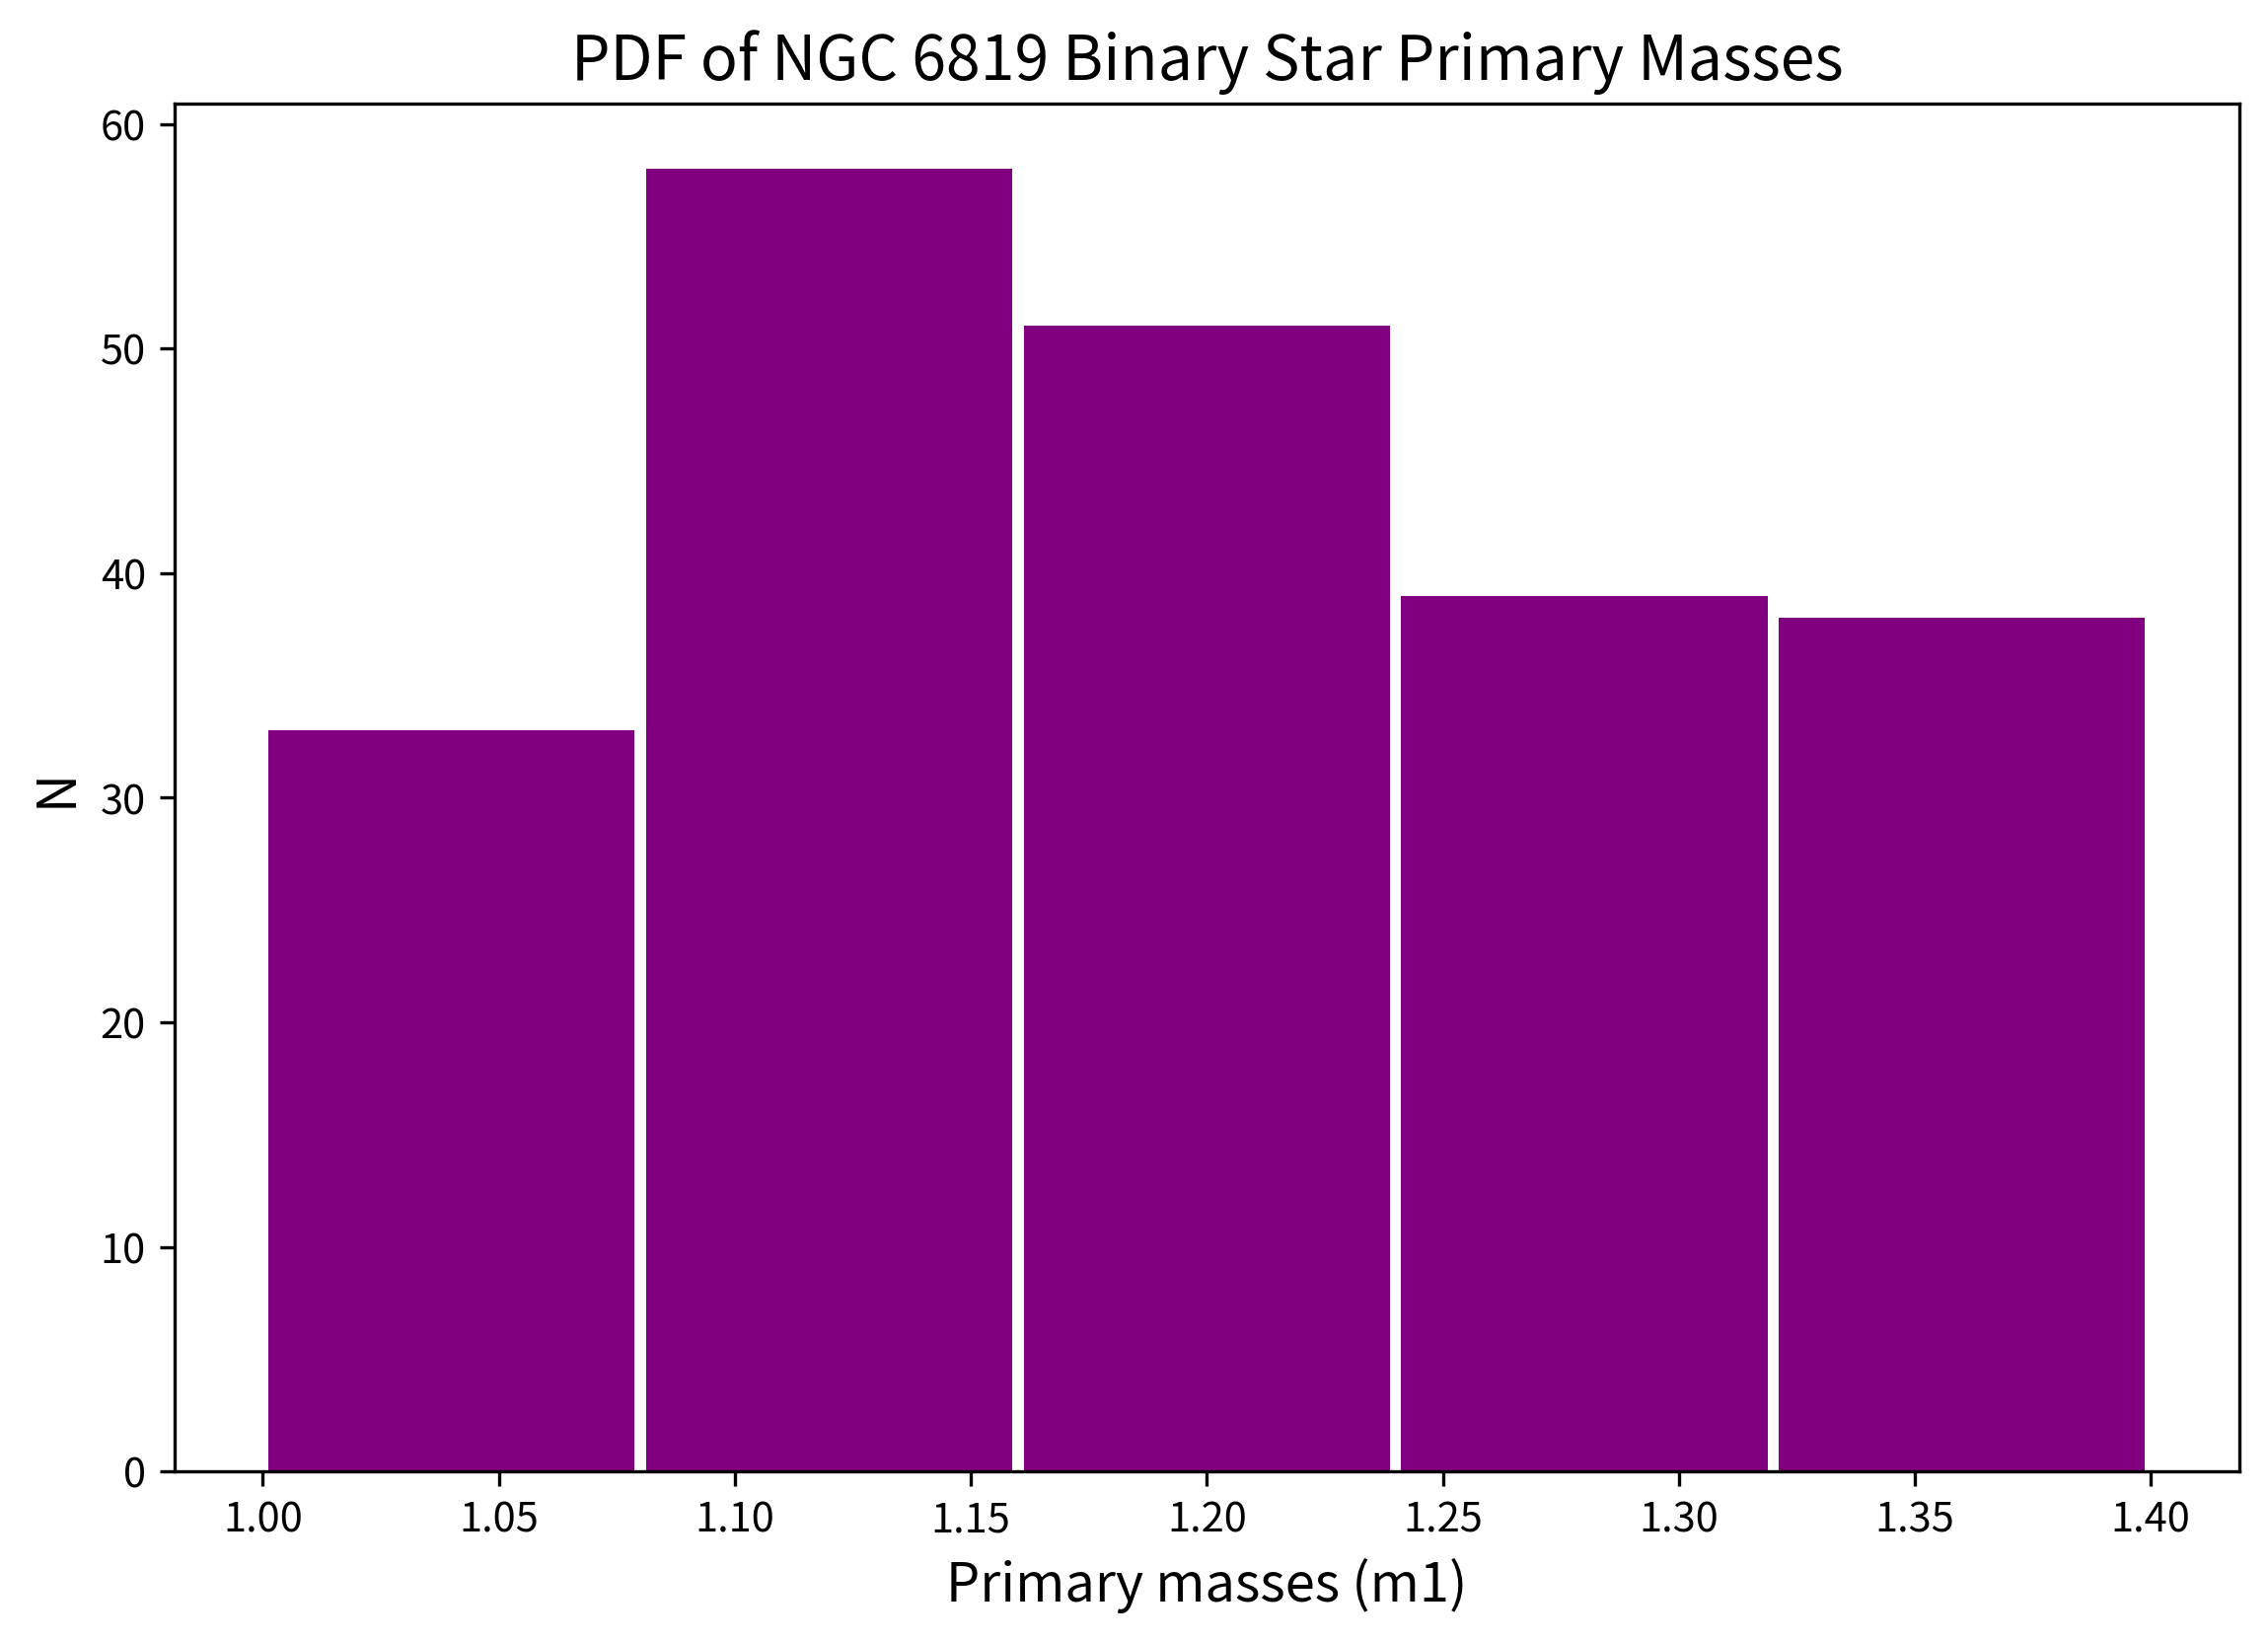

[33. 58. 51. 39. 38.] [1.   1.08 1.16 1.24 1.32 1.4 ]


In [342]:
f,ax = plt.subplots(figsize=(9,6), facecolor='w', dpi=300)
counts1, bins1, bars1 = plt.hist(binaryGaiaData['m1Mean'],Nbins, linewidth=2,color='purple',rwidth=0.97)
plt.ylabel('N',fontsize=13)
plt.xlabel('Primary masses (m1)',fontsize=13)
plt.title('PDF of NGC 6819 Binary Star Primary Masses', fontsize=15)
plt.show()
print(counts1, bins1)

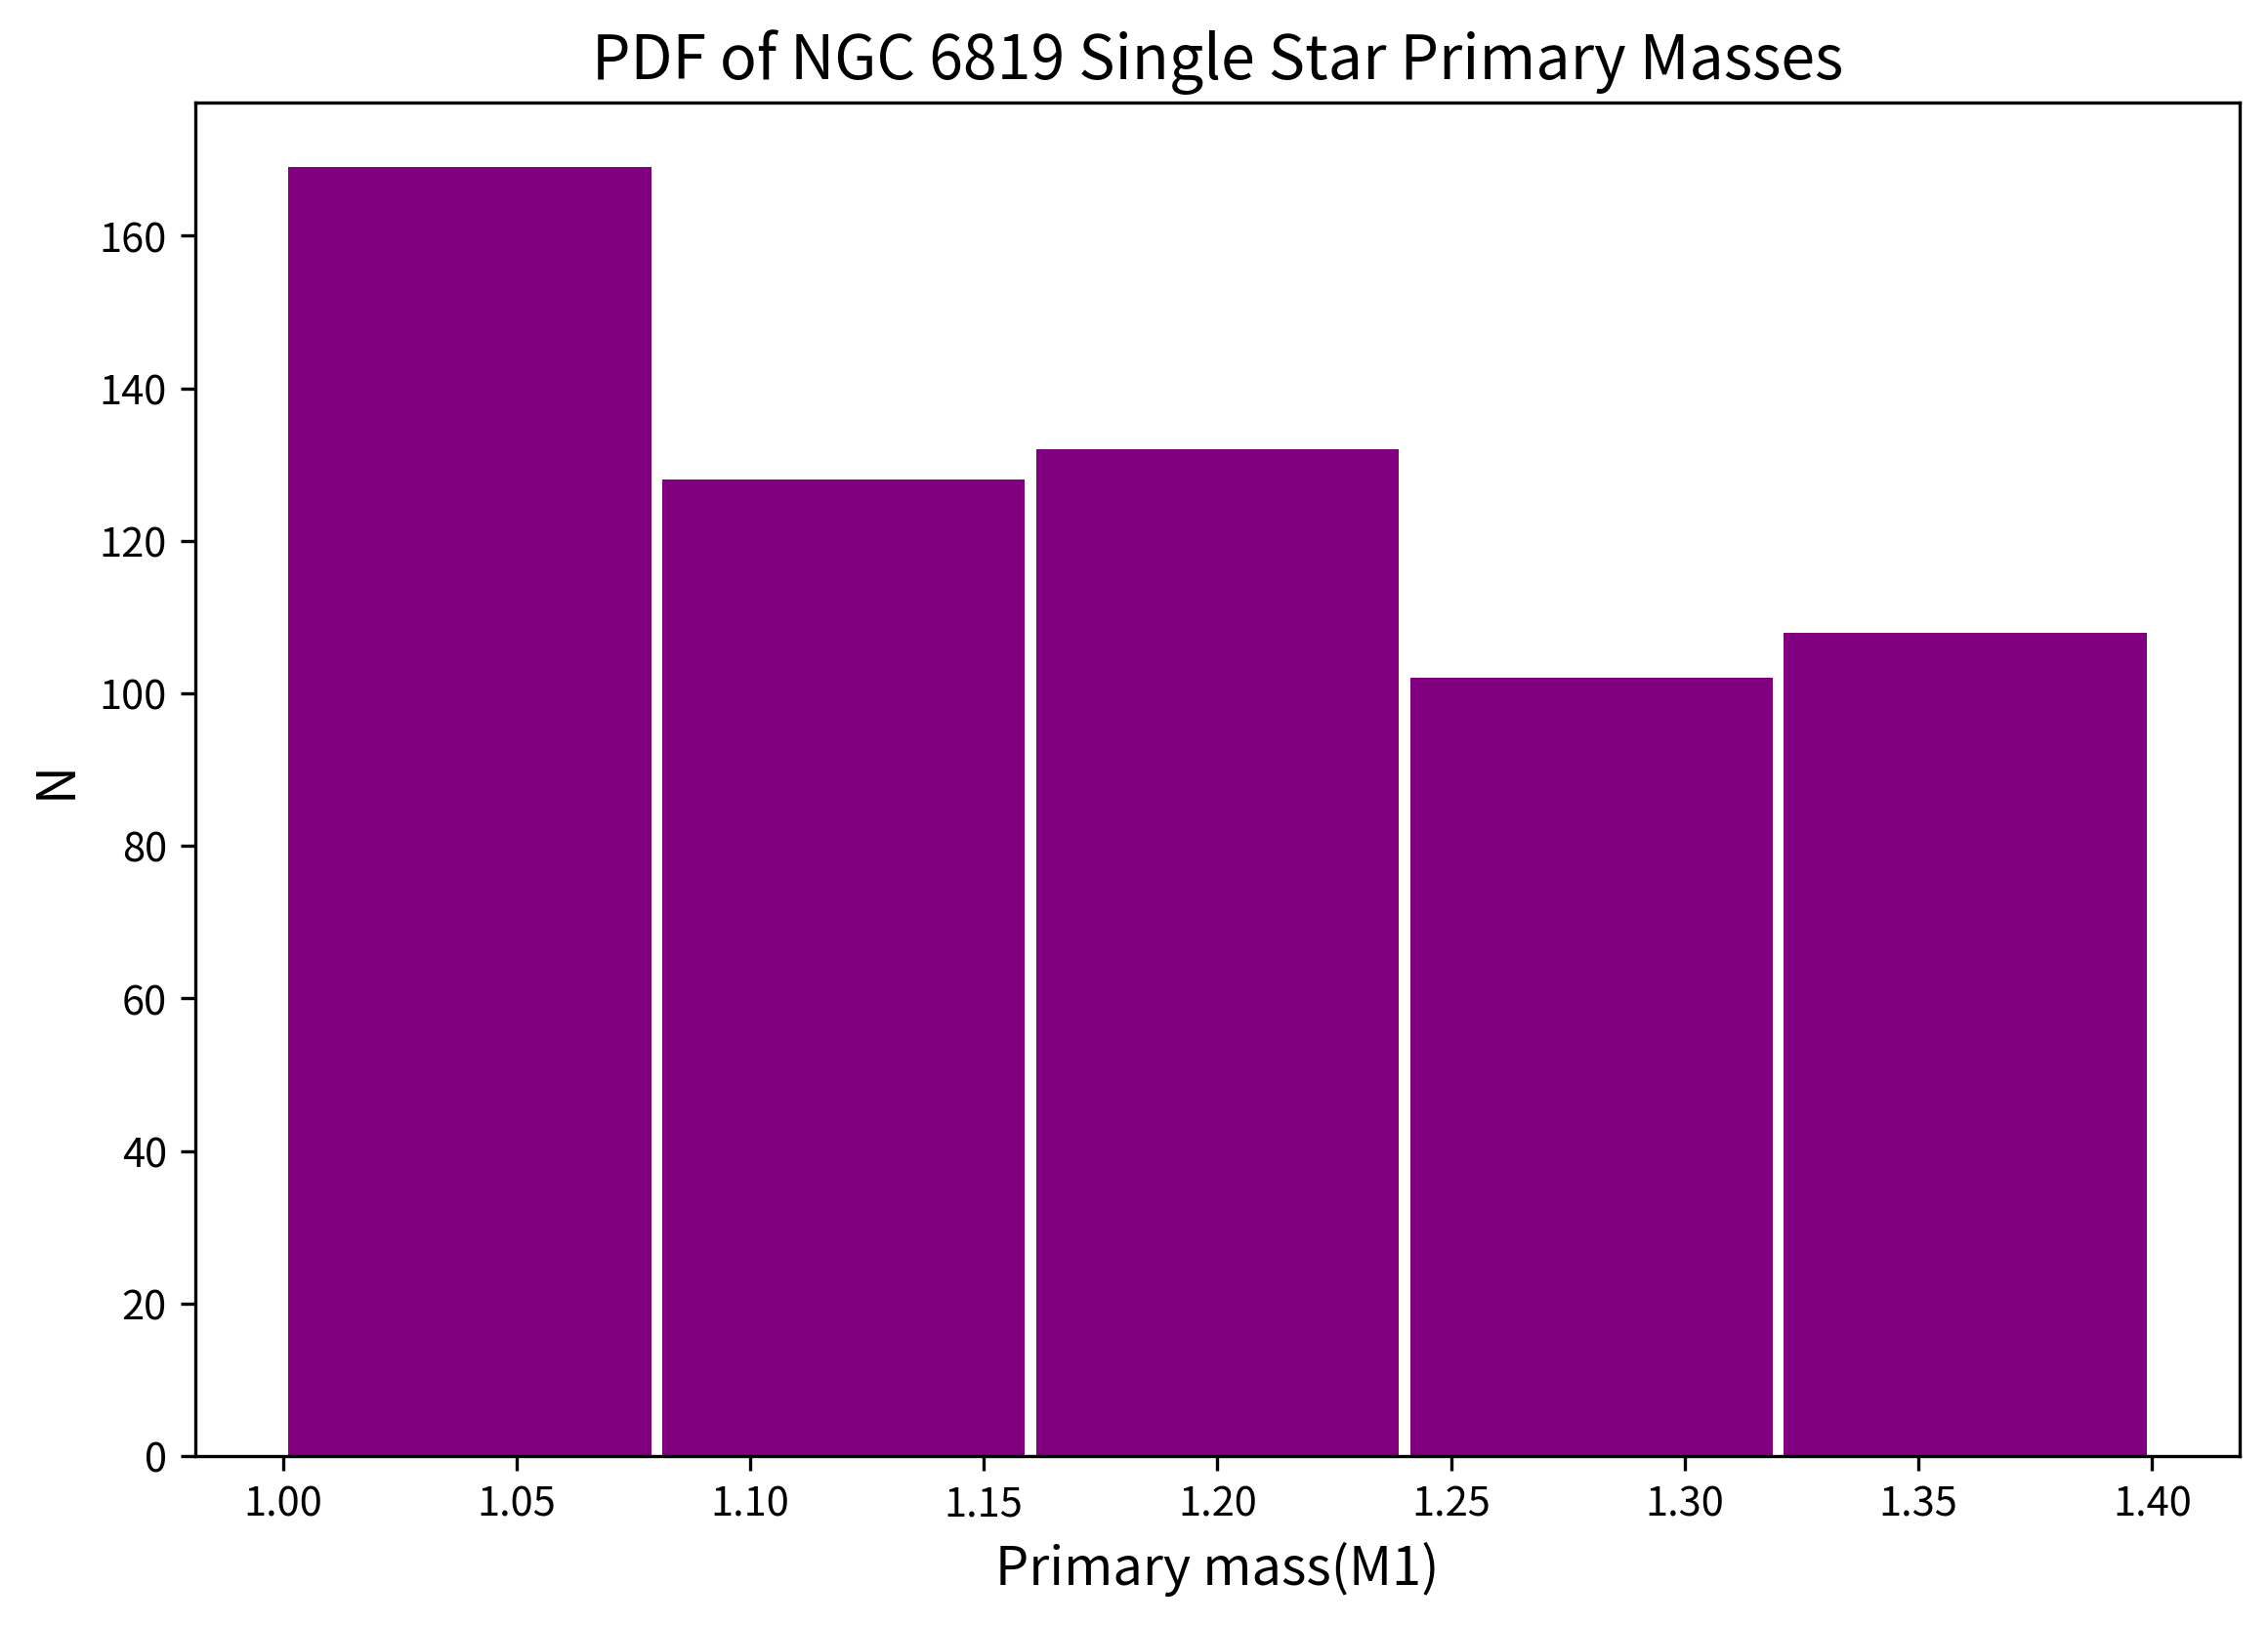

In [343]:
f,ax = plt.subplots(figsize=(9,6), facecolor='w', dpi=300)
counts2, bins2, bars2 = plt.hist(singleGaiaData['m1Mean'],Nbins, linewidth=2,color='purple',rwidth=0.97)
plt.ylabel('N',fontsize=13)
plt.xlabel('Primary mass(M1)',fontsize=13)
plt.title('PDF of NGC 6819 Single Star Primary Masses', fontsize=15)
plt.show()

In [344]:
errors_y3 = np.sqrt(counts1)/counts2
print(errors_y3)

[0.03399149 0.05949823 0.05410173 0.06122547 0.05707791]


In [345]:
print(bins1)
#find halfway point between first and second bin
print(bins1 + (bins1[1]-bins1[0])/2 )
print(bins1[1]-bins1[0],bins1[2]-bins1[1])

print(len(bins1), len(counts1/counts2))

[1.   1.08 1.16 1.24 1.32 1.4 ]
[1.04 1.12 1.2  1.28 1.36 1.44]
0.08000000000000007 0.07999999999999985
6 5


In [346]:
print(bins1[:-1] + (bins1[1]-bins1[0])/2)

[1.04 1.12 1.2  1.28 1.36]


[1.   1.08 1.16 1.24 1.32 1.4 ] [1.   1.08 1.16 1.24 1.32 1.4 ]


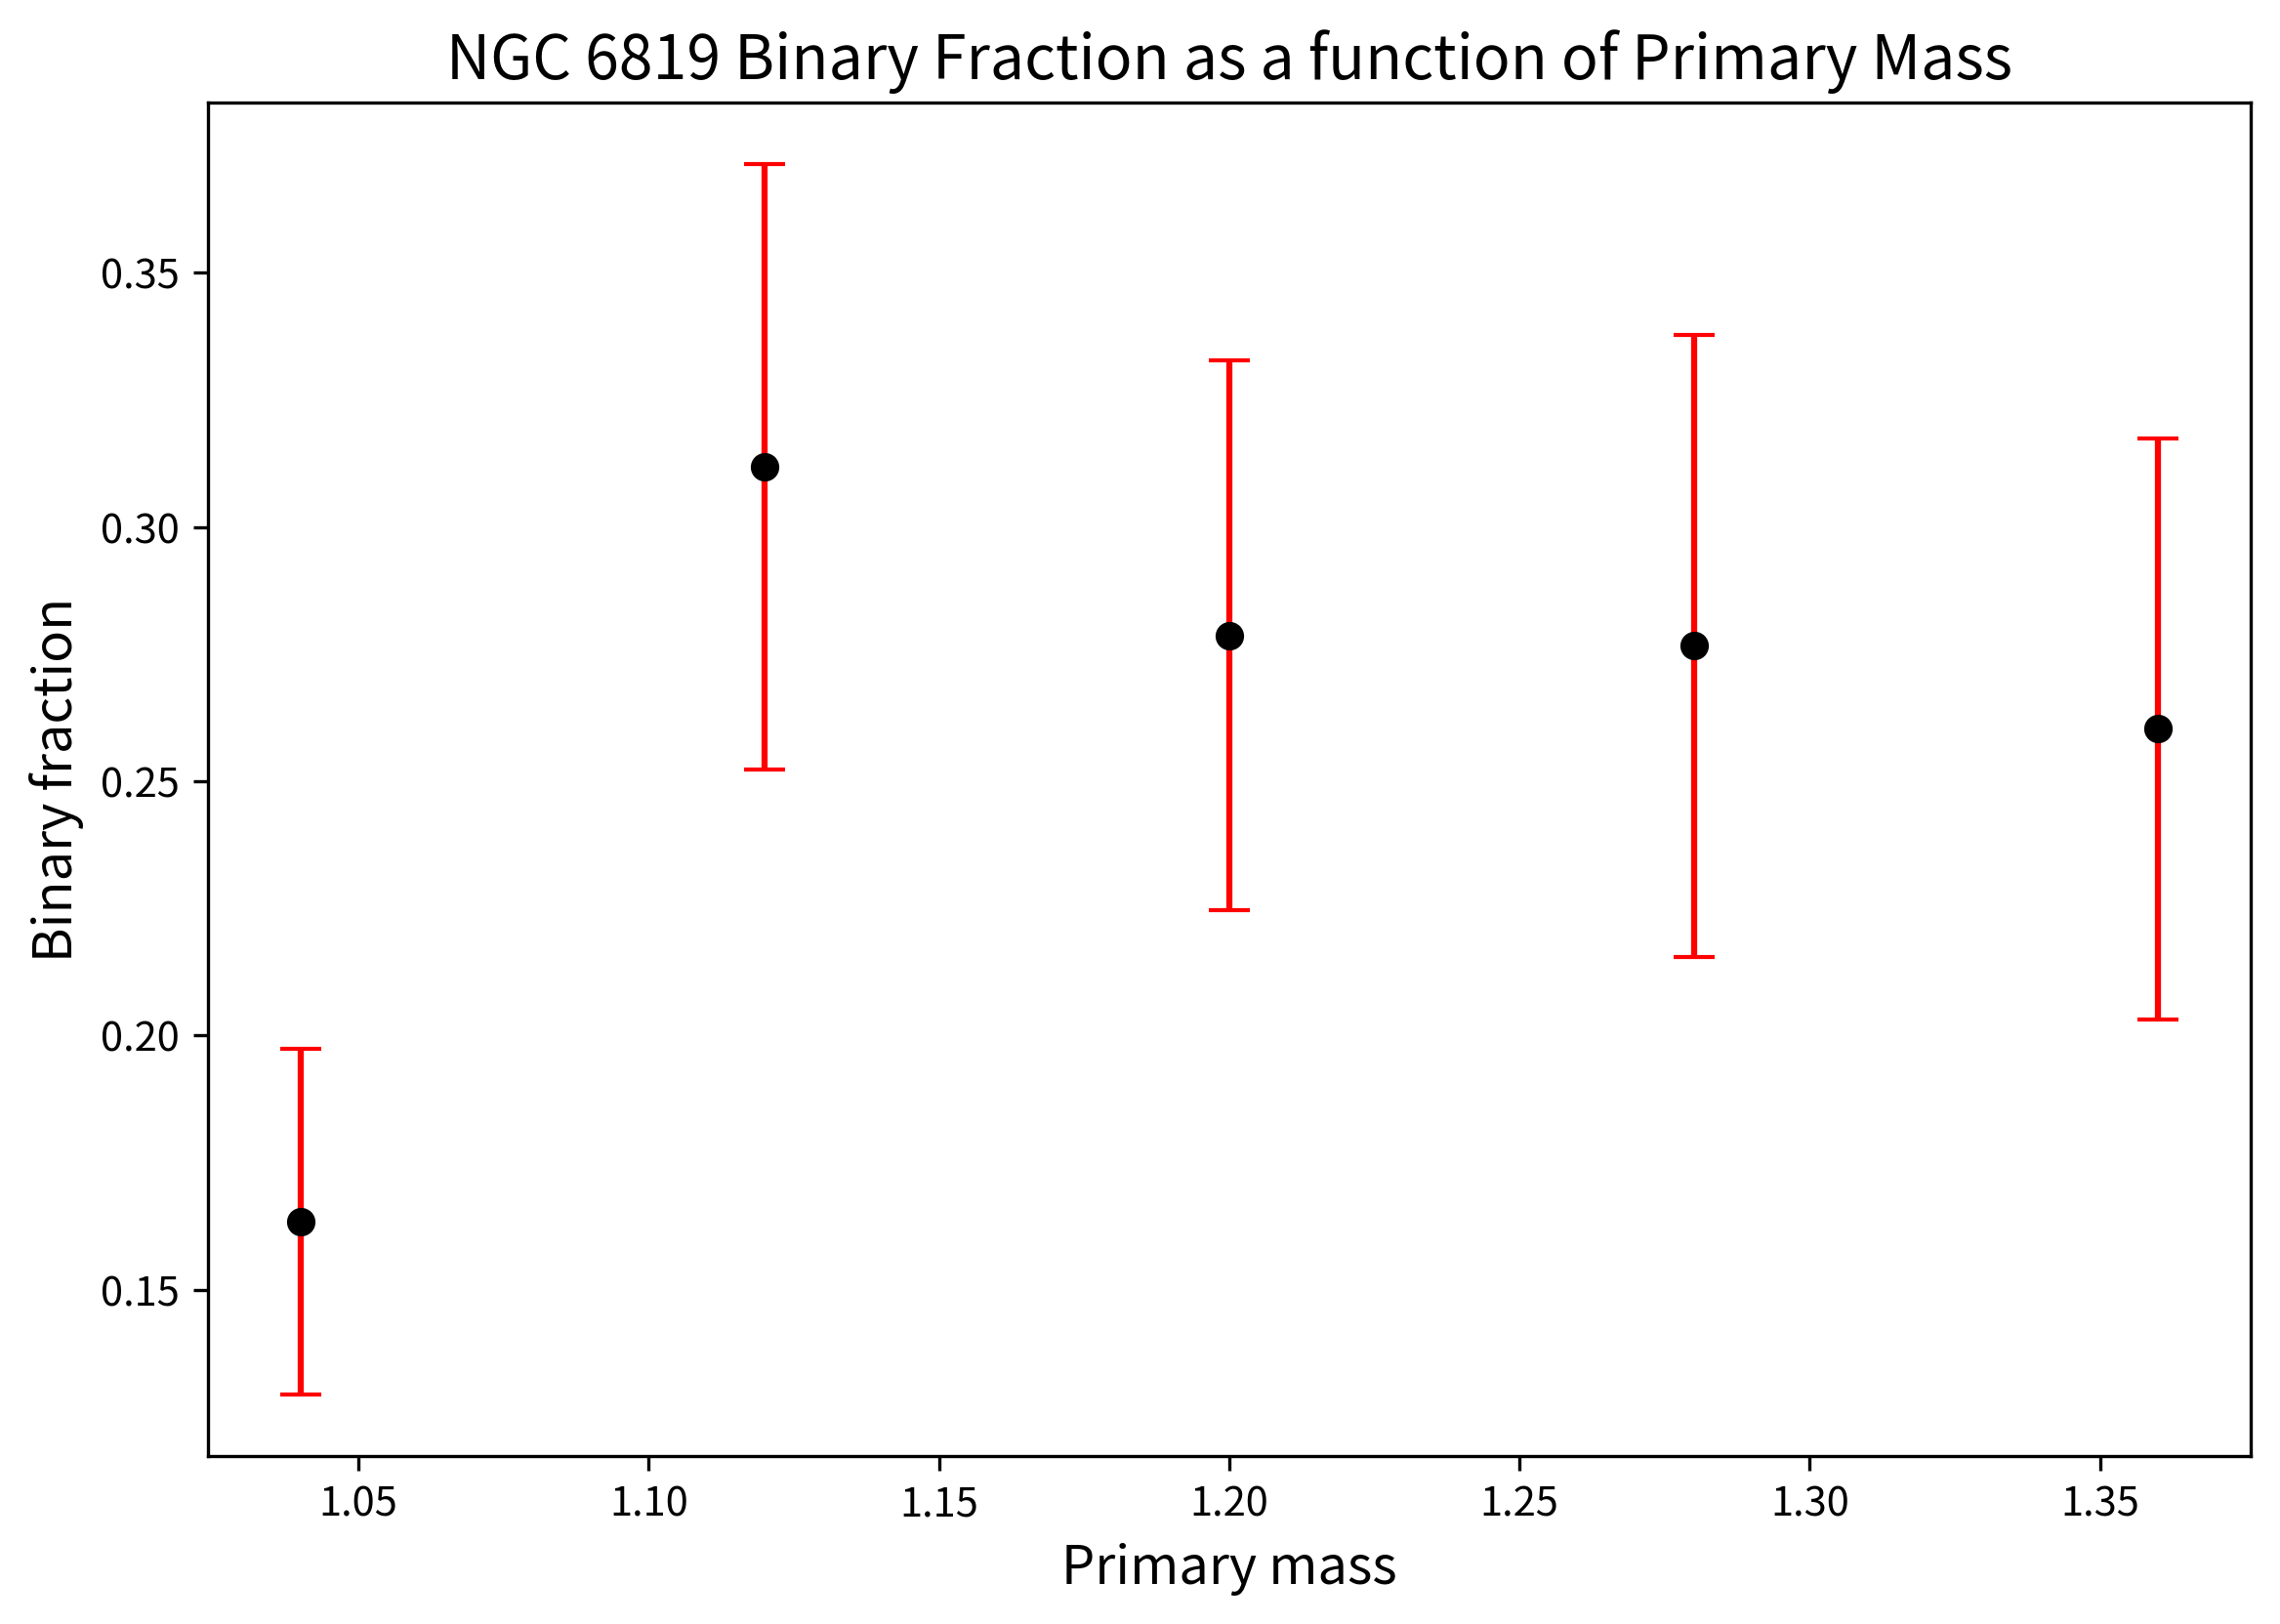

In [347]:
f,ax = plt.subplots(figsize=(9,6), facecolor='w', dpi=300)
print(bins1,bins2)
primarybins = bins1[:-1] + (bins1[1]-bins1[0])/2

plt.errorbar(primarybins, counts1/(counts1 +counts2), xerr=None, yerr=errors_y3, fmt='o',capsize=5, color='black', ecolor='red')
plt.ylabel('Binary fraction',fontsize=13)
plt.xlabel('Primary mass',fontsize=13)
plt.title('NGC 6819 Binary Fraction as a function of Primary Mass', fontsize=15)
plt.show()

In [348]:
counts2

array([169., 128., 132., 102., 108.])

In [349]:
twod_histbins = np.linspace(0.5,1,6)
print(twod_histbins)

[0.5 0.6 0.7 0.8 0.9 1. ]


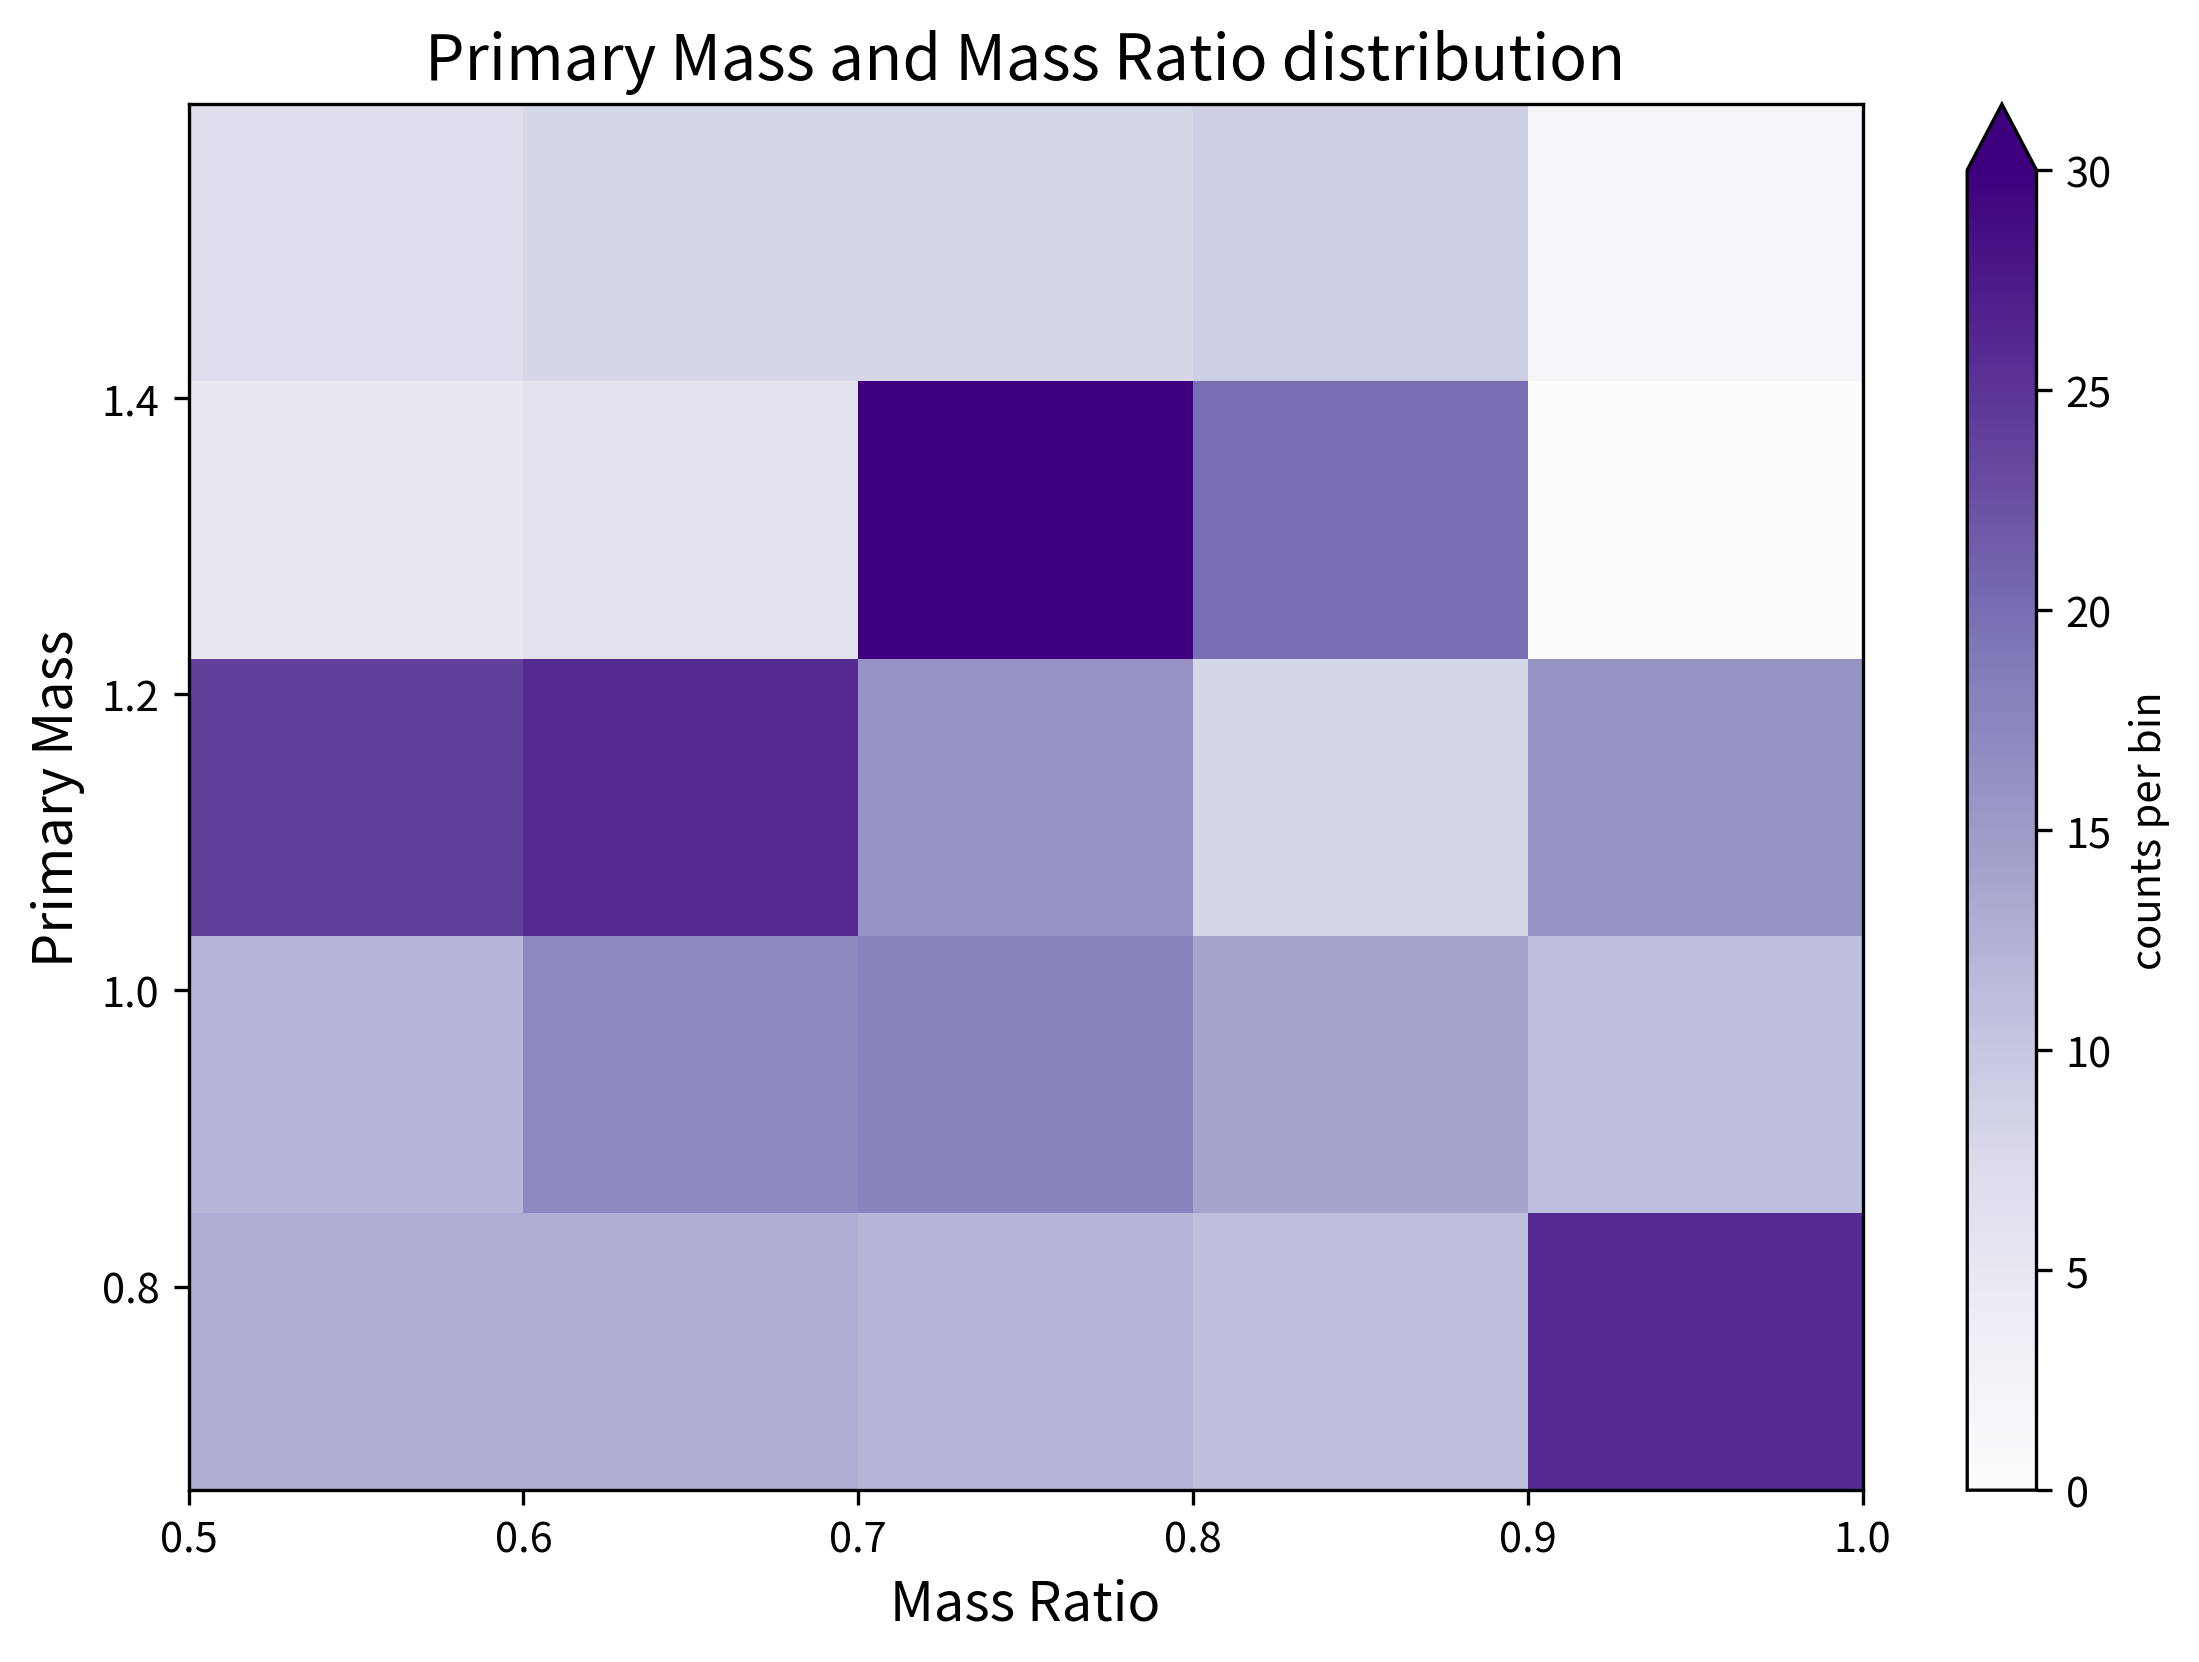

In [350]:
f,ax = plt.subplots(figsize=(9,6), facecolor='w', dpi=300)
plt.hist2d(binaryGaiaData['qMean'], binaryGaiaData['m1Mean'], bins=[twod_histbins,5], cmap='Purples', vmax=30)
cb = plt.colorbar(label='counts per bin', extend='max')
plt.xlabel('Mass Ratio',fontsize=13)
plt.ylabel('Primary Mass',fontsize=13)
plt.title("Primary Mass and Mass Ratio distribution", fontsize=15)
plt.show()

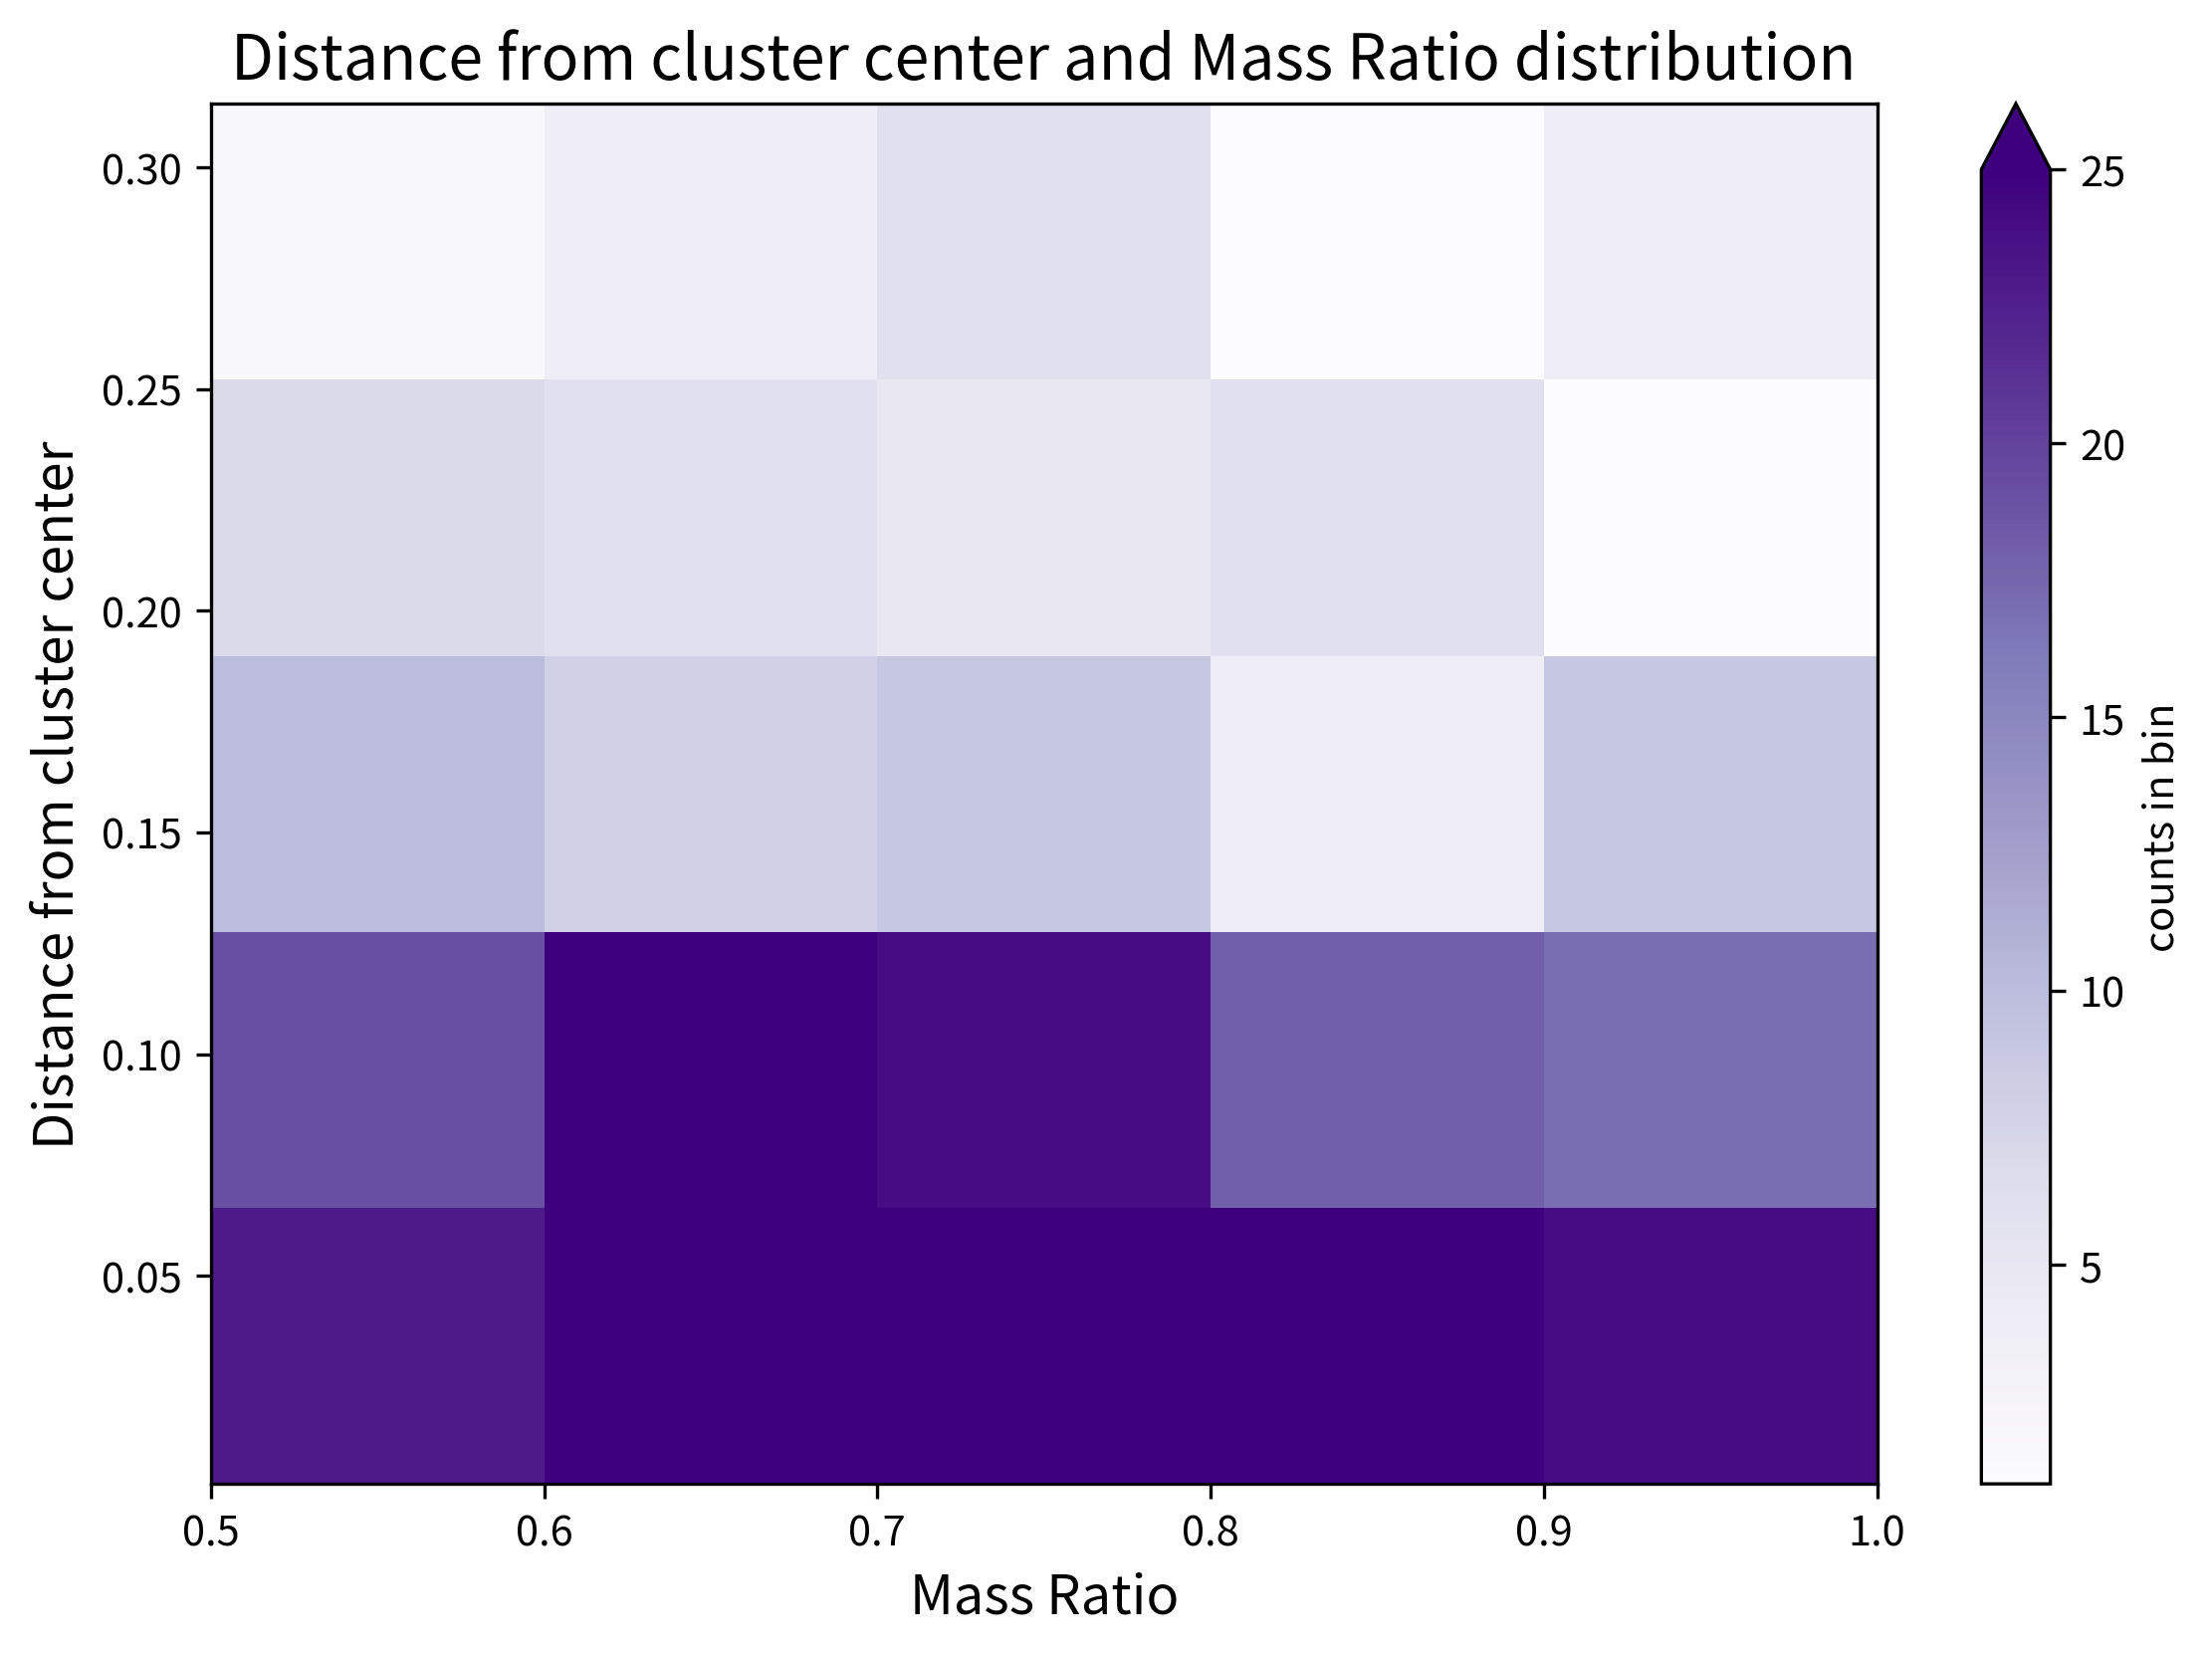

In [351]:
#qmean and distance
f,ax = plt.subplots(figsize=(9,6), facecolor='w', dpi=300)
plt.hist2d(binaryGaiaData['qMean'], binaryGaiaData['distance'], bins=[twod_histbins, 5], cmap='Purples', vmax=25)
cb = plt.colorbar(label='counts in bin', extend='max')
plt.xlabel('Mass Ratio',fontsize=13)
plt.ylabel('Distance from cluster center',fontsize=13)
plt.title("Distance from cluster center and Mass Ratio distribution", fontsize=15)
plt.show()

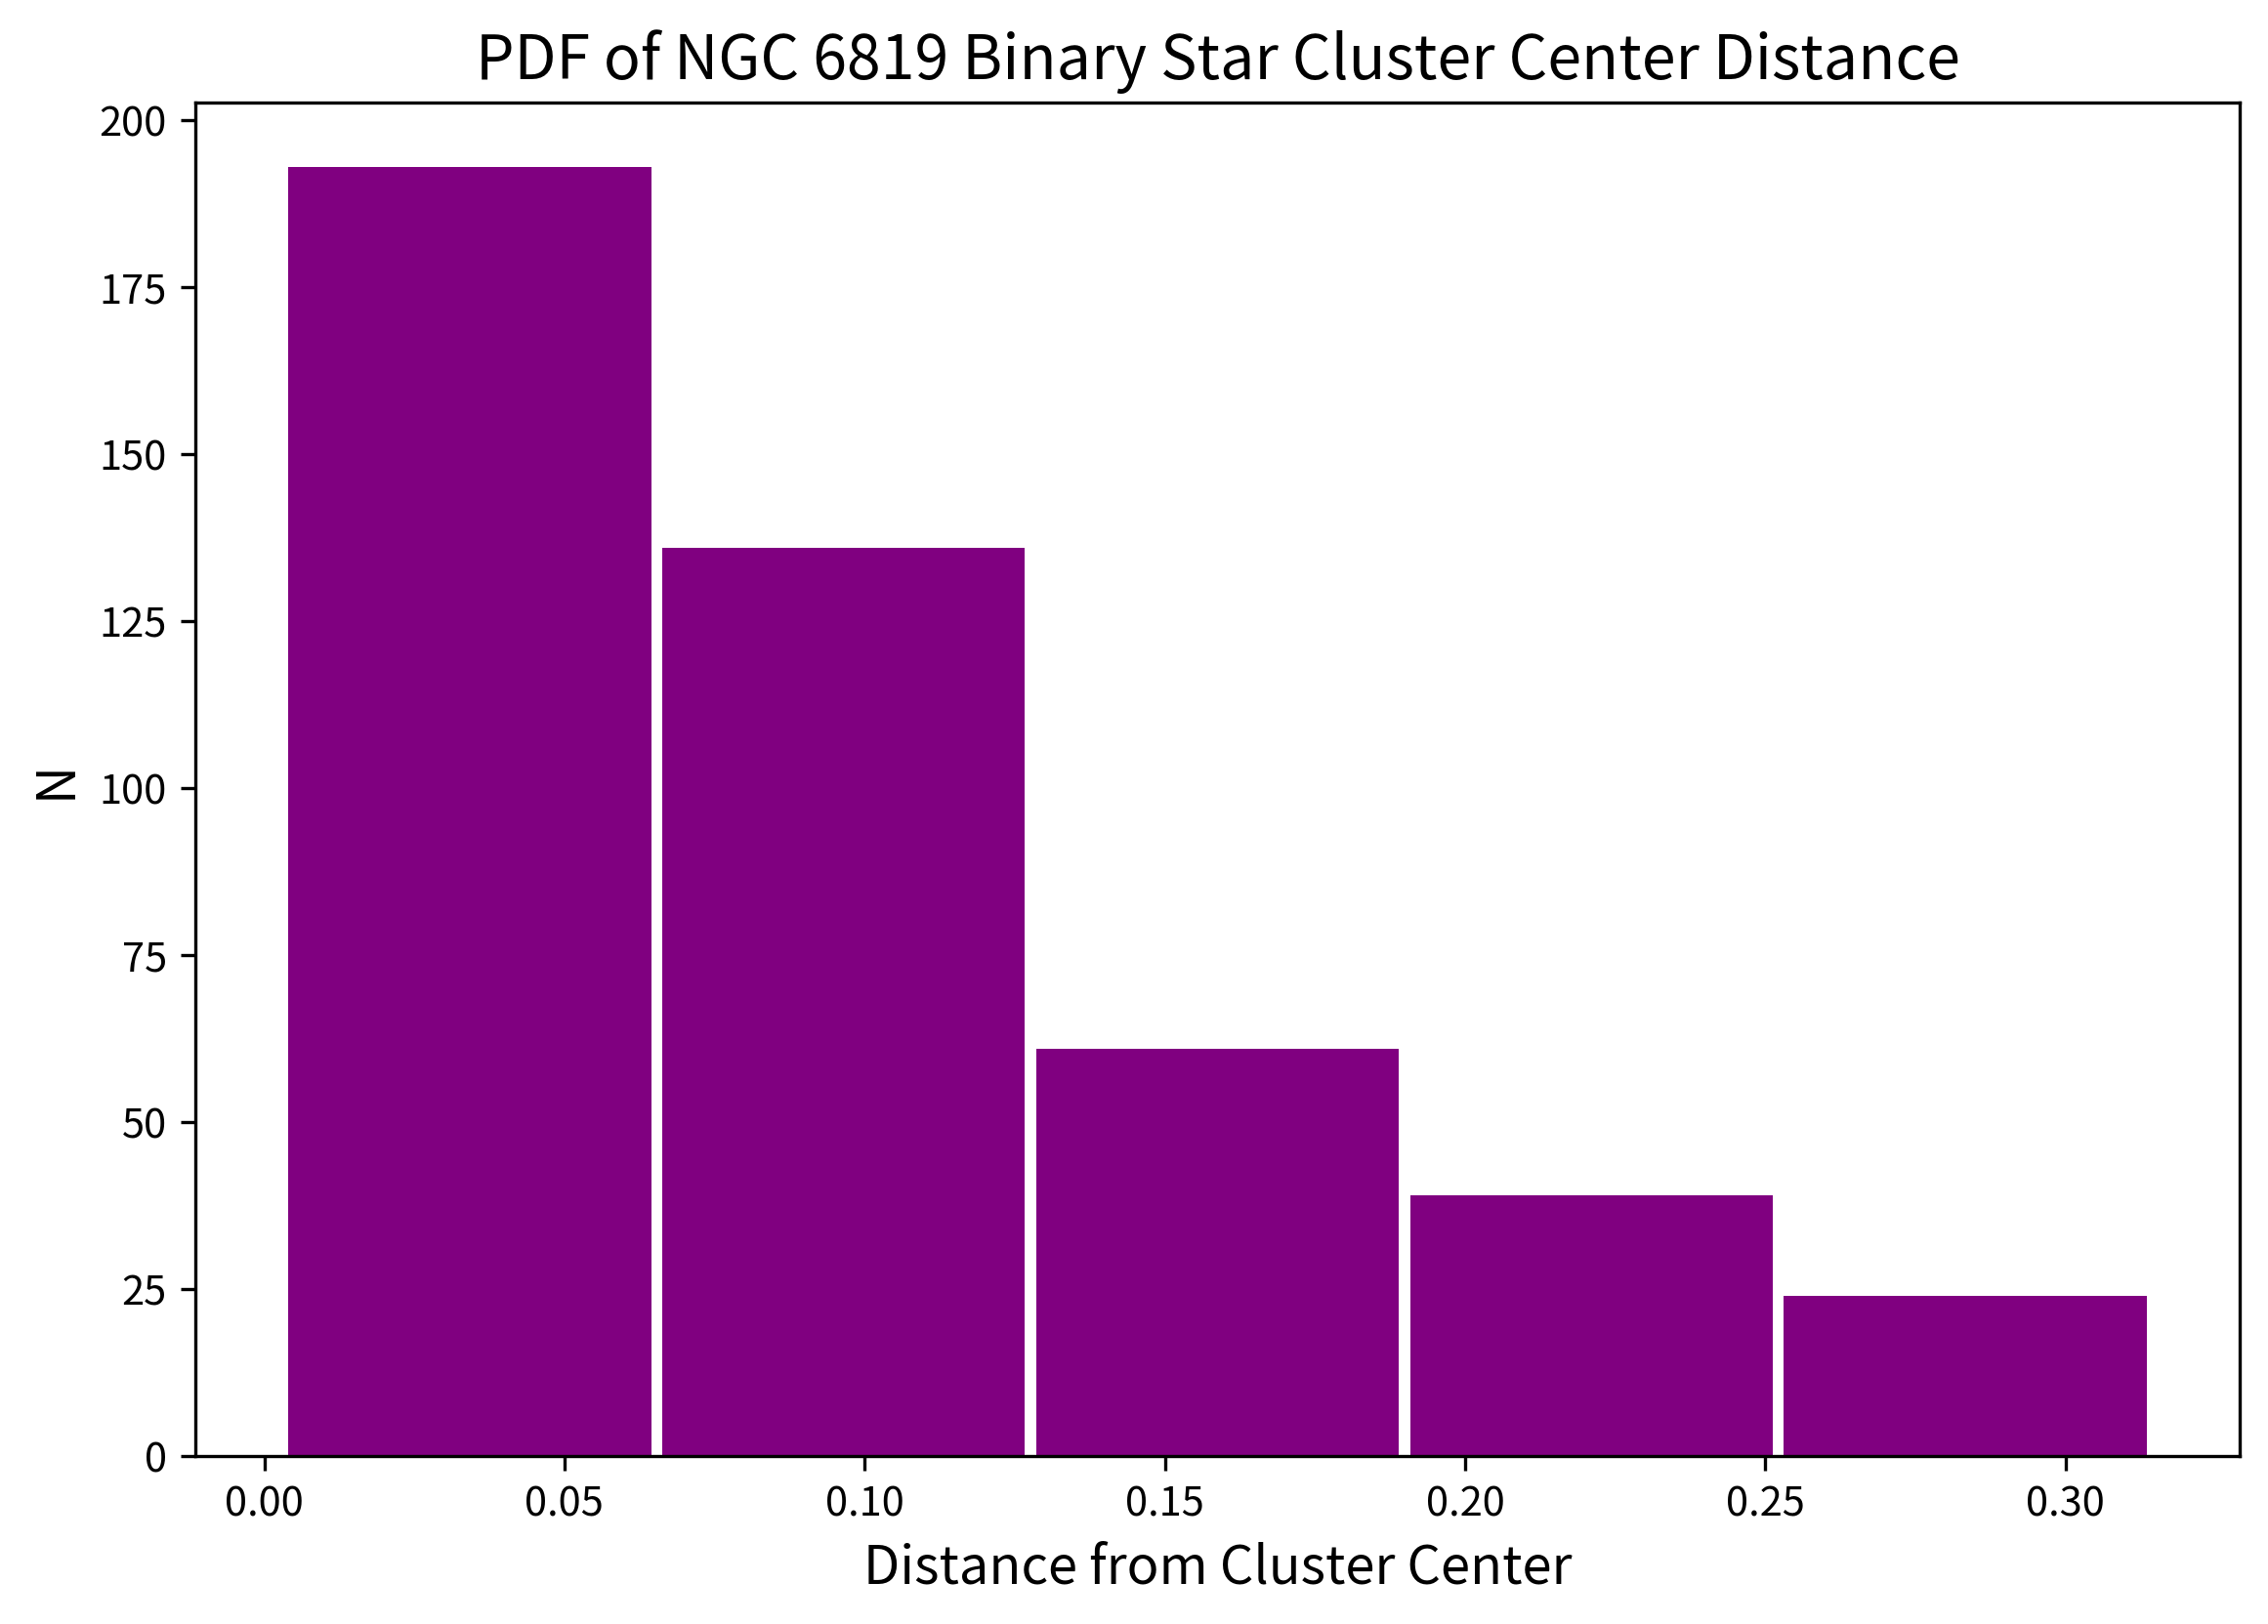

In [352]:
f,ax = plt.subplots(figsize=(9,6), facecolor='w', dpi=300)
counts, bins, bars =plt.hist(binaryGaiaData['distance'], bins=5,linewidth=2,color='purple',rwidth=0.97)
plt.xlabel('Distance from Cluster Center',fontsize=13)
plt.ylabel('N',fontsize=13)
plt.title("PDF of NGC 6819 Binary Star Cluster Center Distance", fontsize=15)
plt.show()

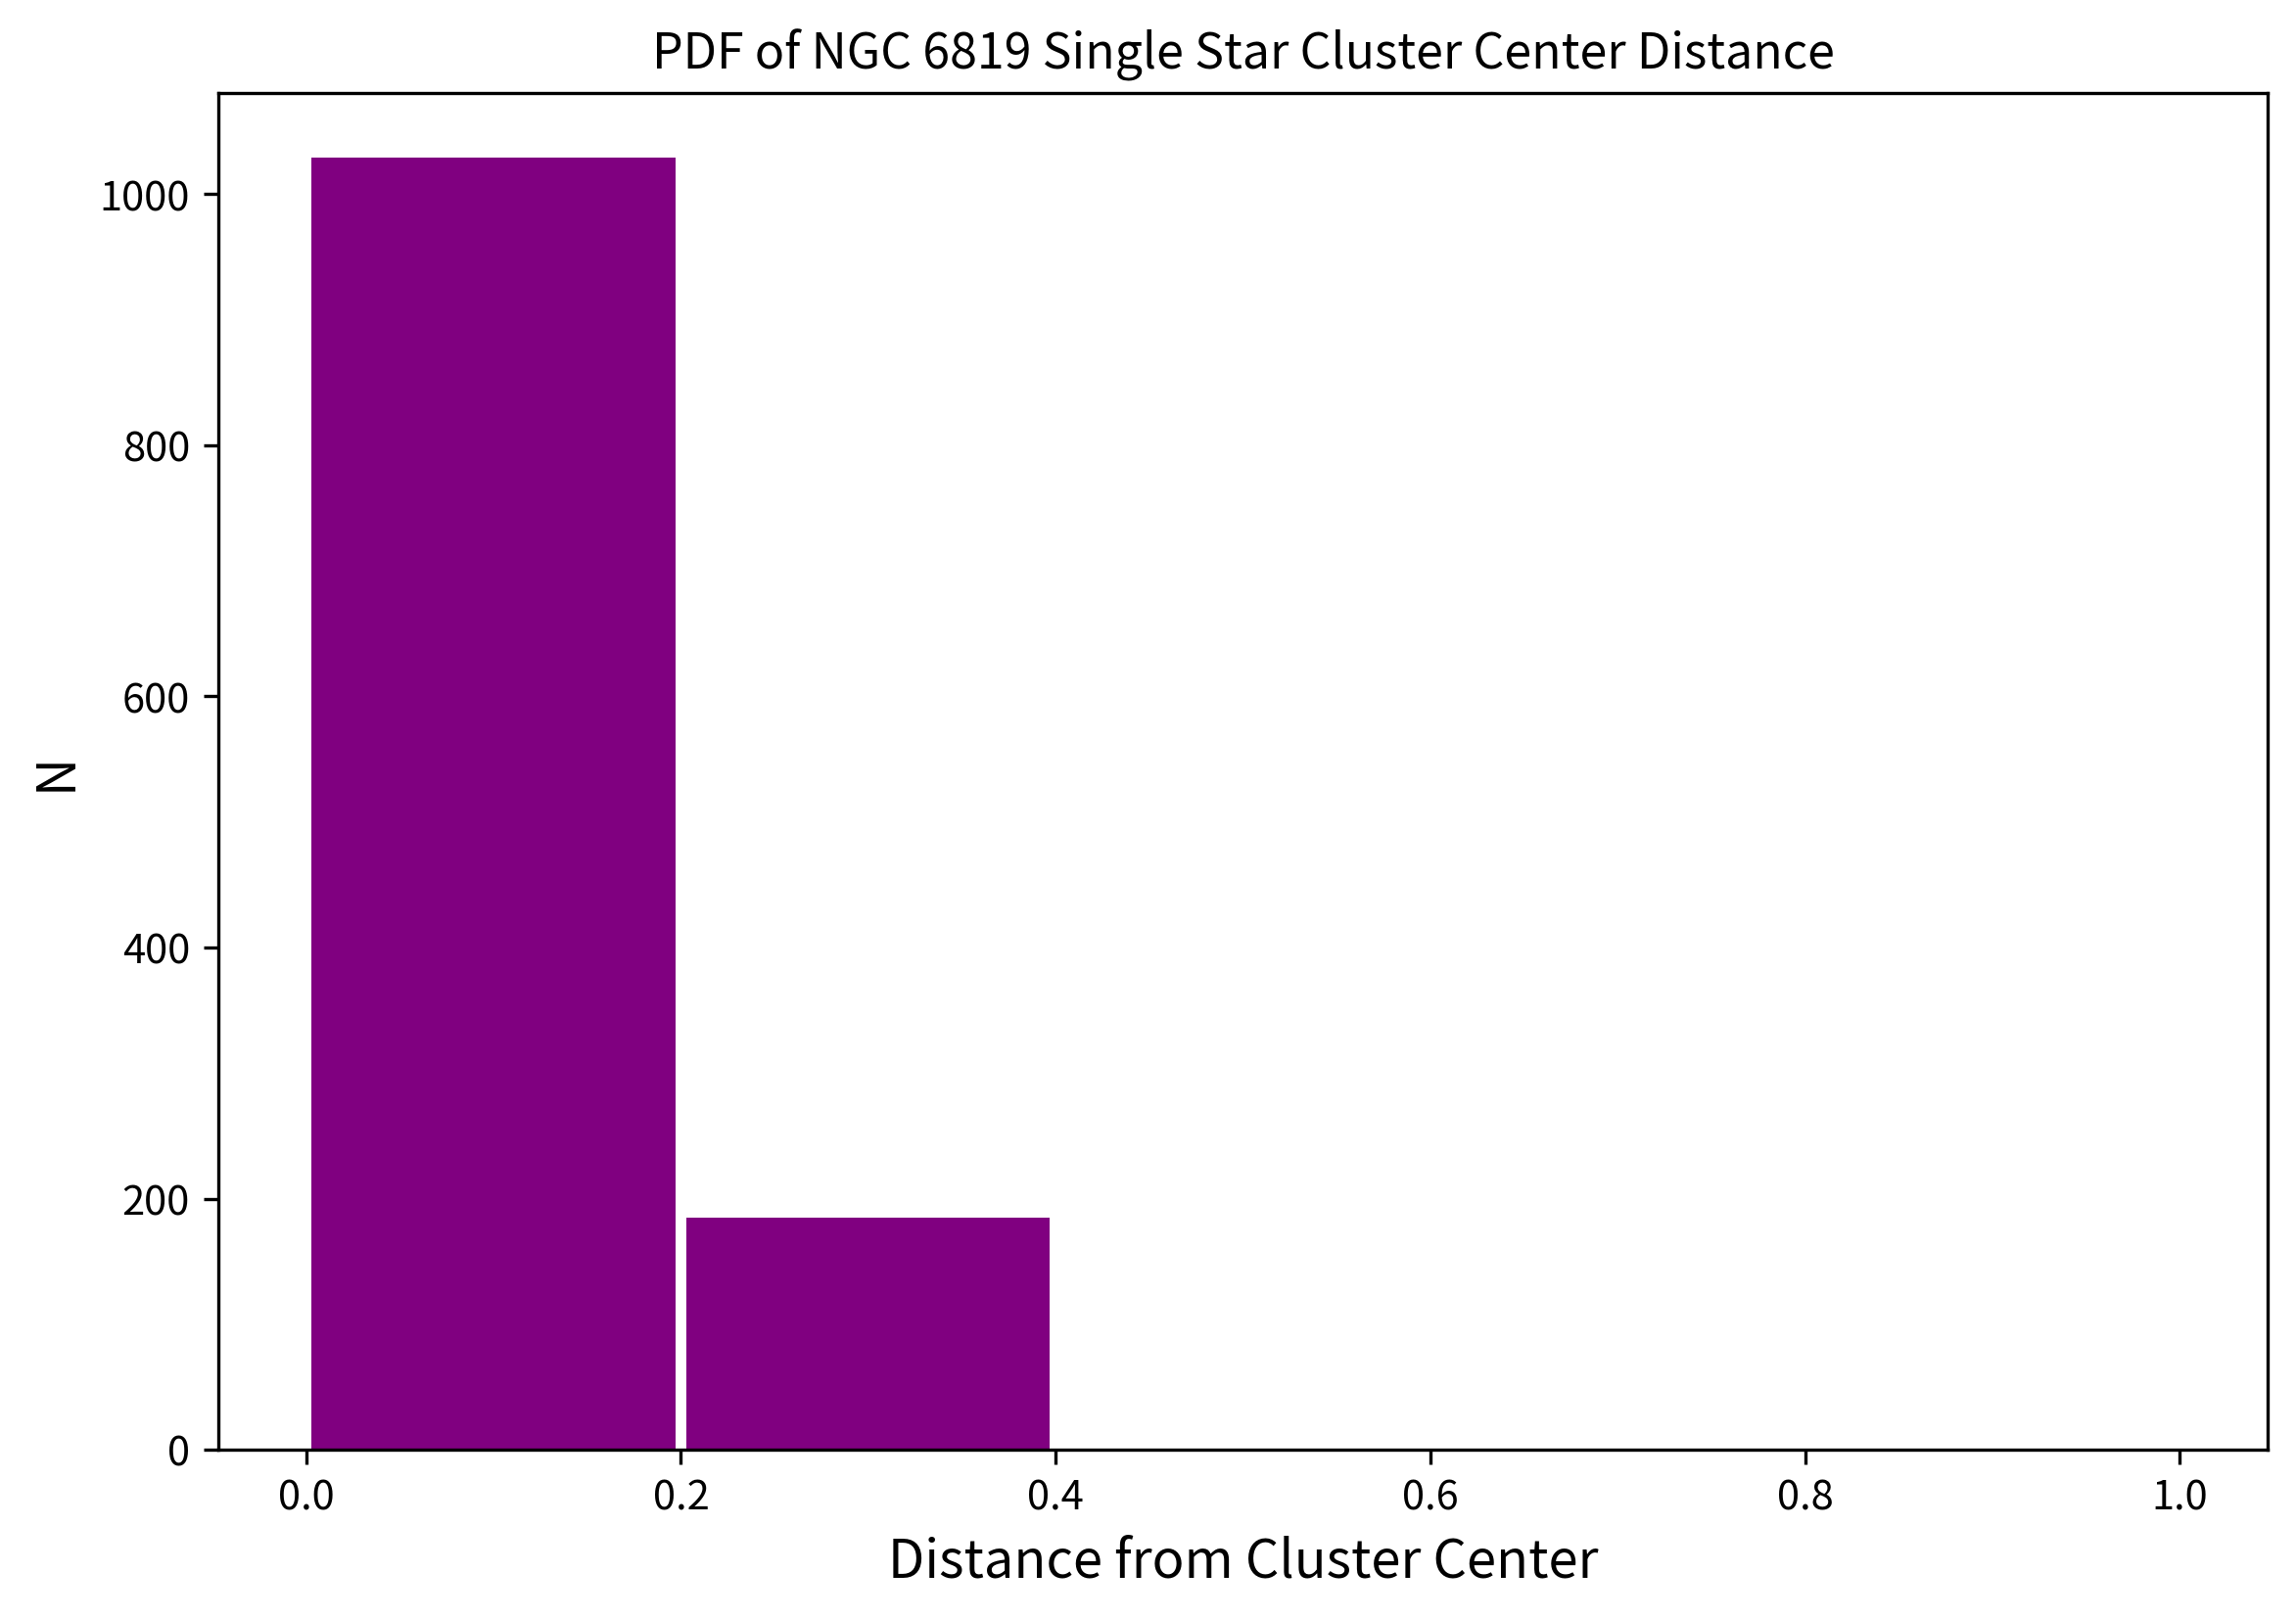

In [353]:
f,ax = plt.subplots(figsize=(9,6), facecolor='w', dpi=300)
counts2, bins2, bars2 = plt.hist(singleGaiaData['distance'], bins=5, range=[0,1],linewidth=2,color='purple',rwidth=0.97)
plt.xlabel('Distance from Cluster Center',fontsize=13)
plt.ylabel('N',fontsize=13)
plt.title('PDF of NGC 6819 Single Star Cluster Center Distance')
plt.show()

In [354]:
bins

array([0.00309573, 0.06535558, 0.12761543, 0.18987528, 0.25213514,
       0.31439499])

In [355]:
# is this the right way to do error? can we factor in the std of the values themselves?
errors_y = np.sqrt(counts)/counts2


/var/folders/_w/2tvx5cms23s29hpbx7ncw_cr0000gn/T/ipykernel_62860/847706480.py:2: RuntimeWarning: divide by zero encountered in divide
  errors_y = np.sqrt(counts)/counts2


/var/folders/_w/2tvx5cms23s29hpbx7ncw_cr0000gn/T/ipykernel_62860/3076053262.py:6: RuntimeWarning: divide by zero encountered in divide
  plt.scatter(bins3, counts/counts2, color='blue')


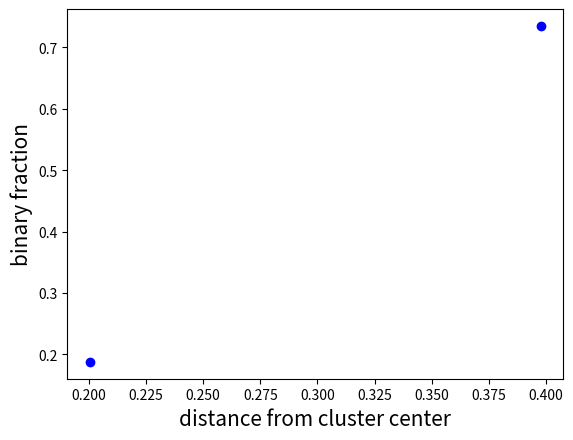

In [356]:
bins3 = [ 0.20038481, 0.39769111, 0.5949974 , 0.79230369,
       0.98960999 ]

plt.xlabel('distance from cluster center',fontsize=15)
plt.ylabel('binary fraction',fontsize=15)
plt.scatter(bins3, counts/counts2, color='blue')

/var/folders/_w/2tvx5cms23s29hpbx7ncw_cr0000gn/T/ipykernel_62860/1945227496.py:3: RuntimeWarning: divide by zero encountered in divide
  plt.errorbar(bins3, counts/counts2, xerr=None, yerr=errors_y, fmt='o',capsize=5, color='black', ecolor='red')
/Users/Claire/opt/anaconda3/envs/BASE9/lib/python3.10/site-packages/matplotlib/axes/_axes.py:3593: RuntimeWarning: invalid value encountered in add
  low, high = dep + np.row_stack([-(1 - lolims), 1 - uplims]) * err


<ErrorbarContainer object of 3 artists>

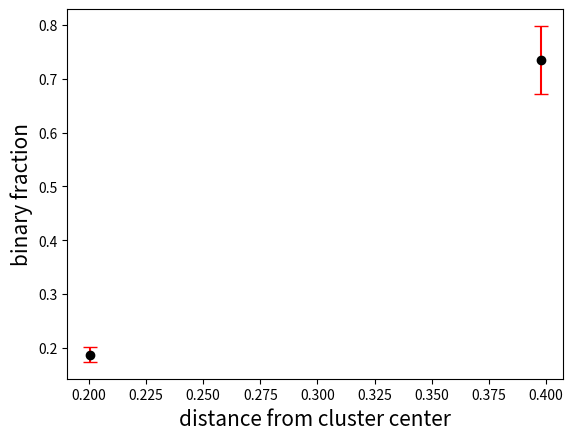

In [357]:
plt.xlabel('distance from cluster center',fontsize=15)
plt.ylabel('binary fraction',fontsize=15)
plt.errorbar(bins3, counts/counts2, xerr=None, yerr=errors_y, fmt='o',capsize=5, color='black', ecolor='red')

## plots of Only the center of CMD  13-17

Text(0.5, 0, 'Primary mass(M1) cut')

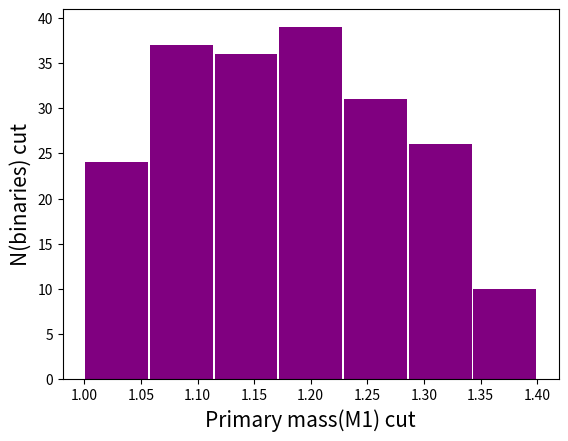

In [358]:
counts5, bins5, bars5 = plt.hist(cutBinaryGaiaData['m1Mean'],bins=np.linspace(1,1.4, 8), linewidth=2,color='purple',rwidth=0.97)
plt.ylabel('N(binaries) cut',fontsize=15)
plt.xlabel('Primary mass(M1) cut',fontsize=15)

In [359]:
bins5

array([1.        , 1.05714286, 1.11428571, 1.17142857, 1.22857143,
       1.28571429, 1.34285714, 1.4       ])

Text(0.5, 0, 'Primary mass(M1) cut')

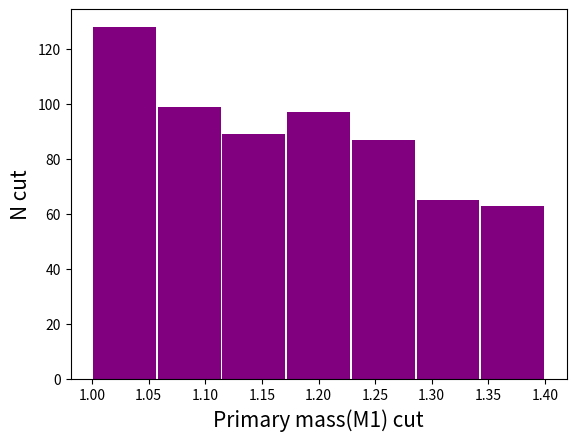

In [360]:
counts6, bins6, bars6 = plt.hist(cutSingleGaiaData['m1Mean'],bins=np.linspace(1,1.4, 8),linewidth=2,color='purple',rwidth=0.97)
plt.ylabel('N cut',fontsize=15)
plt.xlabel('Primary mass(M1) cut',fontsize=15)

In [361]:
bins6

array([1.        , 1.05714286, 1.11428571, 1.17142857, 1.22857143,
       1.28571429, 1.34285714, 1.4       ])

Text(0.5, 0, 'primary mass cut')

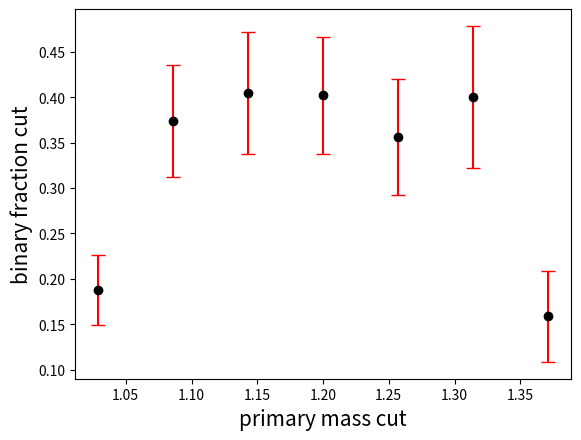

In [362]:
# the arrays arent the same size. should i be getting rid of the first bin value or last?
primarybins2 = bins5[:-1] + (bins5[1]-bins5[0])/2
errors_y4 = np.sqrt(counts5)/counts6
plt.errorbar(primarybins2, counts5/counts6, xerr=None, yerr=errors_y4, fmt='o',capsize=5, color='black', ecolor='red')
plt.ylabel('binary fraction cut',fontsize=15)
plt.xlabel('primary mass cut',fontsize=15)

Text(0, 0.5, 'primary mass cut')

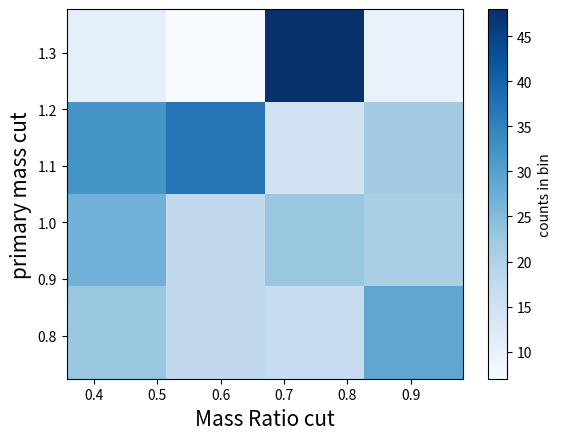

In [363]:
plt.hist2d(cutBinaryGaiaData['qMean'], cutBinaryGaiaData['m1Mean'], bins=4, cmap='Blues')
cb = plt.colorbar(label='counts in bin')
plt.xlabel('Mass Ratio cut',fontsize=15)
plt.ylabel('primary mass cut',fontsize=15)

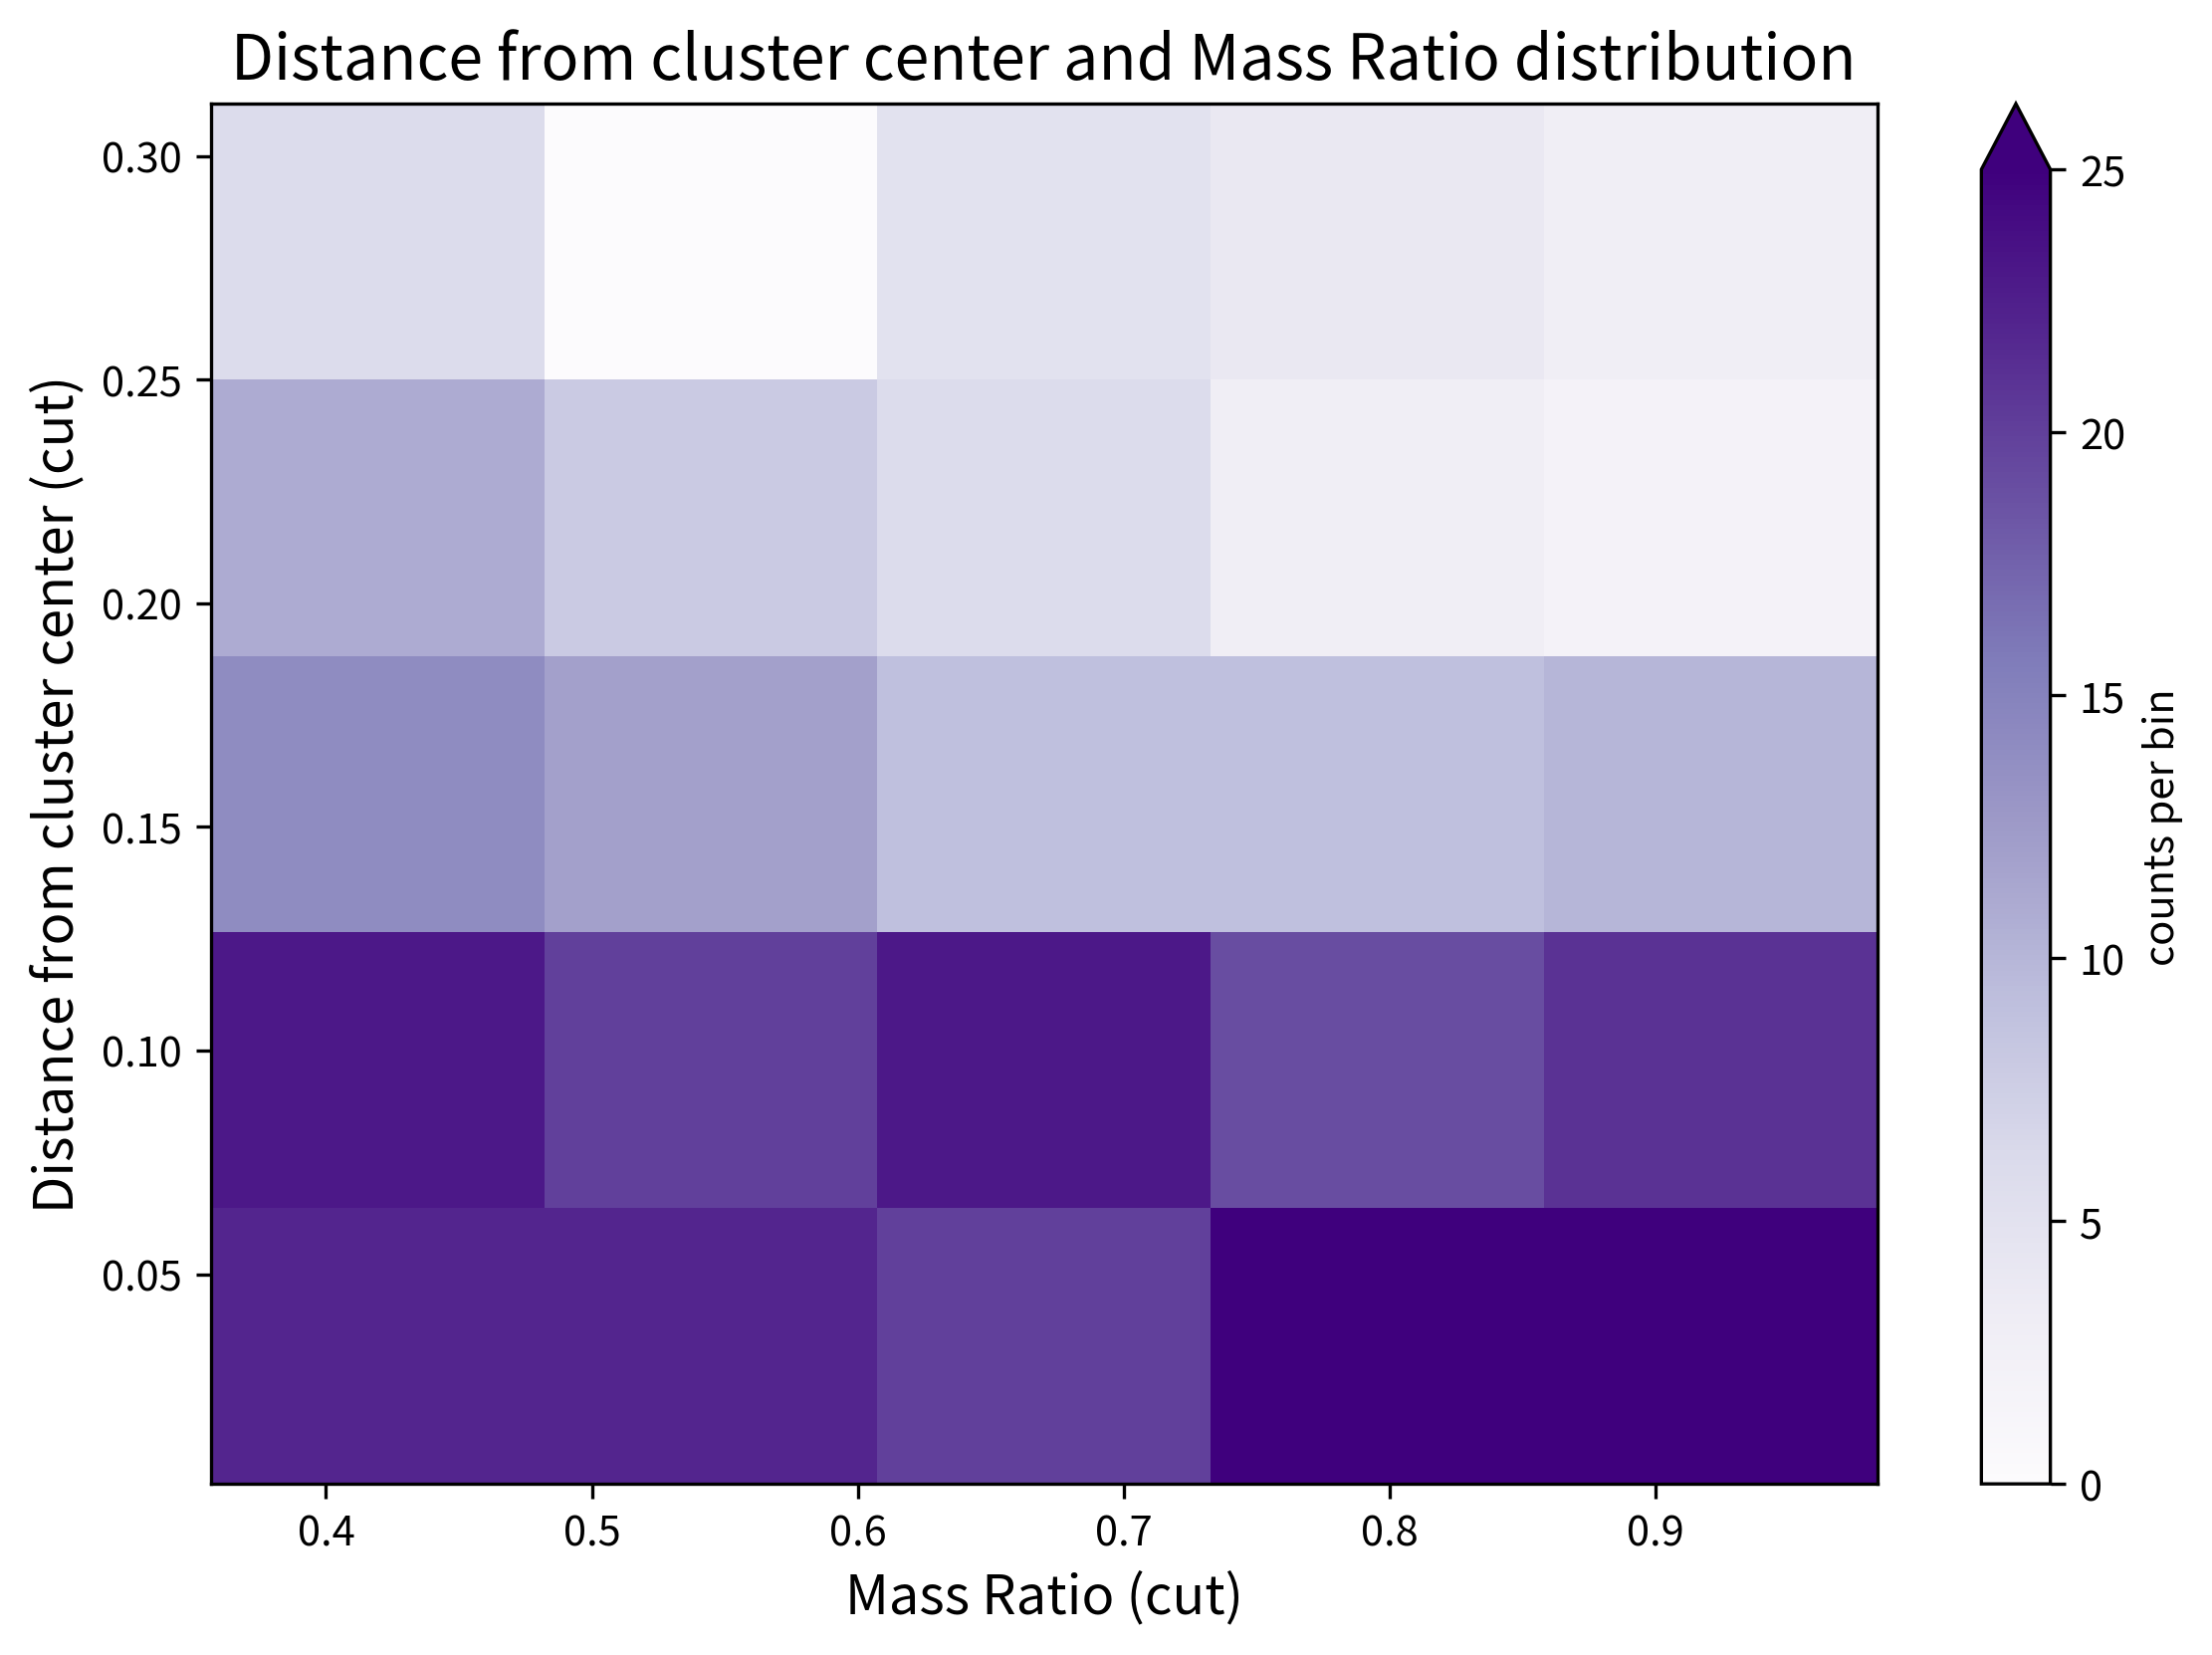

In [364]:
#qmean and distance
f,ax = plt.subplots(figsize=(9,6), facecolor='w', dpi=300)
plt.hist2d(cutBinaryGaiaData['qMean'], cutBinaryGaiaData['distance'], bins=5, cmap='Purples', vmax=25)
cb2 = plt.colorbar(extend="max",label='counts per bin')
plt.xlabel('Mass Ratio (cut)',fontsize=13)
plt.ylabel('Distance from cluster center (cut)',fontsize=13)
plt.title("Distance from cluster center and Mass Ratio distribution", fontsize=15)
plt.show()

Text(0, 0.5, 'N (binaries) cut')

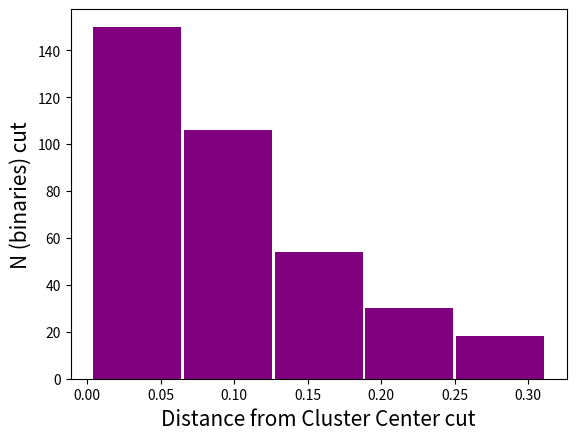

In [365]:
counts7, bins7, bars7 =plt.hist(cutBinaryGaiaData['distance'], bins=5,linewidth=2,color='purple',rwidth=0.97)
plt.xlabel('Distance from Cluster Center cut',fontsize=15)
plt.ylabel('N (binaries) cut',fontsize=15)

Text(0, 0.5, 'N cut')

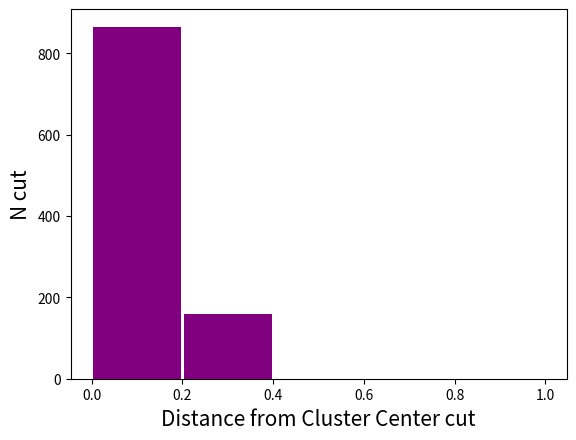

In [366]:
counts8, bins8, bars8 = plt.hist(cutSingleGaiaData['distance'], bins=5, range=[0,1],linewidth=2,color='purple',rwidth=0.97)
plt.xlabel('Distance from Cluster Center cut',fontsize=15)
plt.ylabel('N cut',fontsize=15)

In [367]:

bins7 = [0.2,0.4,0.6,0.8,1]
bins8 = [0,0.2,0.4,0.6,0.8,1]
bins7 

[0.2, 0.4, 0.6, 0.8, 1]

In [368]:
# is this the right way to do error? can we factor in the std of the values themselves?
errors_y2 = np.sqrt(counts7)/counts8


/var/folders/_w/2tvx5cms23s29hpbx7ncw_cr0000gn/T/ipykernel_62860/2702057577.py:2: RuntimeWarning: divide by zero encountered in divide
  errors_y2 = np.sqrt(counts7)/counts8


In [369]:
# plt.xlabel('distance from cluster center cut',fontsize=15)
# plt.ylabel('binary fraction cut',fontsize=15)
# print(len(bins8), len(errors_y2))
# plt.errorbar(bins8, counts7/counts8, xerr=None, yerr=errors_y2, fmt='o',capsize=5, color='black', ecolor='red')


In [370]:
cutBinaryGaiaData.columns

Index(['source_id', 'G', 'G_BP', 'G_RP_x', 'ra', 'dec', 'id', 'G_RP_y', 'g_ps',
       'r_ps', 'i_ps', 'z_ps', 'y_ps', 'J_2M', 'H_2M', 'Ks_2M', 'sigG',
       'sigG_BP', 'sigG_RP', 'sigg_ps', 'sigr_ps', 'sigi_ps', 'sigz_ps',
       'sigy_ps', 'sigJ_2M', 'sigH_2M', 'sigKs_2M', 'mass1', 'massRatio',
       'stage1', 'CMprior', 'useDBI', 'm1Mean', 'm1Std', 'm2Mean', 'm2Std',
       'qMean', 'qStd', 'memMean', 'memStd', 'member', 'binary', 'distance'],
      dtype='object')

(23.0, 12.0)

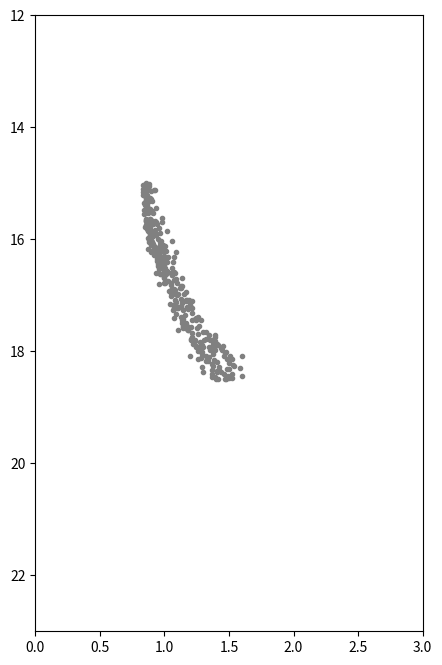

In [371]:
f, ax = plt.subplots(figsize=(5,8))
ax.plot(cutBinaryGaiaData['G_BP'] - cutBinaryGaiaData['G_RP_x'], cutBinaryGaiaData['G'],'.', color='gray')
ax.set_xlim(0, 3)
ax.set_ylim(23, 12)

(23.0, 12.0)

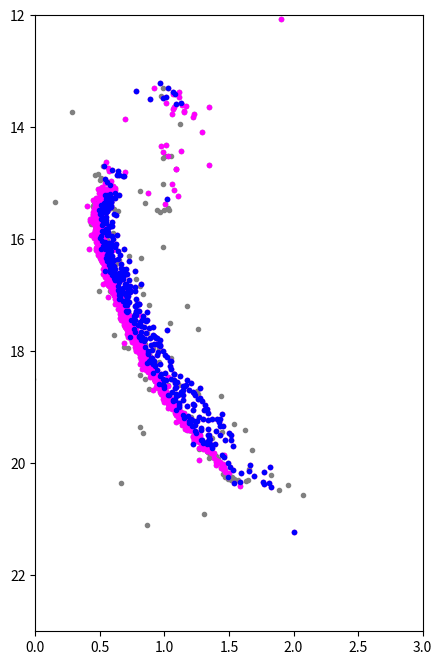

In [372]:
f, ax = plt.subplots(figsize=(5,8))
photMems = phot.loc[phot['member']]
photBinary = phot.loc[phot['binary']]
ax.plot(phot['g_ps'] - phot['i_ps'], phot['g_ps'],'.', color='gray')
ax.plot(photMems['g_ps'] - photMems['i_ps'], photMems['g_ps'],'.', color='magenta')
ax.plot(photBinary['g_ps'] - photBinary['i_ps'], photBinary['g_ps'],'.', color='blue')
ax.set_xlim(0, 3)
ax.set_ylim(23, 12)

In [373]:
photBinary

id        G     G_BP     G_RP     g_ps     r_ps     i_ps  \
18    10079200118  12.5085  13.0806  11.7925  99.9000  99.9000  99.9000   
19    10014000119  12.5173  13.1115  11.7863  13.3066  12.6870  12.2810   
20    10291800122  12.5621  13.1809  11.8130  13.3745  12.7150  12.3100   
21    10320700125  12.5894  13.1961  11.8481  13.3969  12.7100  12.3140   
22    10276600132  12.6390  13.2478  11.8866  13.3457  13.0830  12.5690   
...           ...      ...      ...      ...      ...      ...      ...   
1877  10588715865  19.2640  19.9550  18.4009  20.2450  19.1709  18.7523   
1879  11196416068  19.2877  99.9000  99.9000  99.9000  99.9000  99.9000   
1880  10006017074  19.4167  99.9000  99.9000  99.9000  99.9000  18.6213   
1883  11717518632  19.6066  99.9000  99.9000  99.9000  19.6921  18.1839   
1887  10845519896  19.7562  99.9000  99.9000  21.2210  19.8649  19.2195   

         z_ps     y_ps    J_2M  ...    m1Mean  m1Std    m2Mean  m2Std  \
18    99.9000  99.9000  10.843  ...  1.587656     -2  1.543199     -4   
19    12.0270  11.9090  10.790  ...  1.595815     -2  1.452335     -4   
20    12.0640  11.9320  10.804  ...  1.598595     -2  1.277282     -4   
21    12.0760  11.9540  10.844  ...  1.594874     -2  1.401906     -4   
22    12.2340  12.0017  10.867  ...  1.597176     -2  1.316464     -4   
...       ...      ...     ...  ...       ...    ...       ...    ...   
1877  99.9000  18.1414  99.900  ...  0.705049     -2  0.343375     -4   
1879  99.9000  99.9000  16.319  ...  0.641565     -2  0.624274     -4   
1880  99.9000  99.9000  99.900  ...  0.635973     -2  0.619667     -4   
1883  18.7557  18.6017  99.900  ...  0.655270     -2  0.448548     -4   
1887  18.8601  18.7397  99.900  ...  0.647034     -2  0.371122     -4   

         qMean      qStd   memMean        memStd  member  binary  
18    0.972027  0.052500  0.995932  6.365169e-02    True    True  
19    0.910220  0.182120  0.944925  2.280457e-01    True    True  
20    0.799065  0.166017  0.999998  3.616864e-05    True    True  
21    0.879090  0.047201  0.998533  3.405517e-02    True    True  
22    0.824260  0.047268  0.999882  2.579837e-03    True    True  
...        ...       ...       ...           ...     ...     ...  
1877  0.487273  0.092093  1.000000  0.000000e+00    True    True  
1879  0.973296  0.023495  0.998745  1.297811e-02    True    True  
1880  0.974574  0.021689  1.000000  0.000000e+00    True    True  
1883  0.686959  0.124208  1.000000  5.665158e-08    True    True  
1887  0.573841  0.065644  1.000000  0.000000e+00    True    True  

[471 rows x 38 columns]

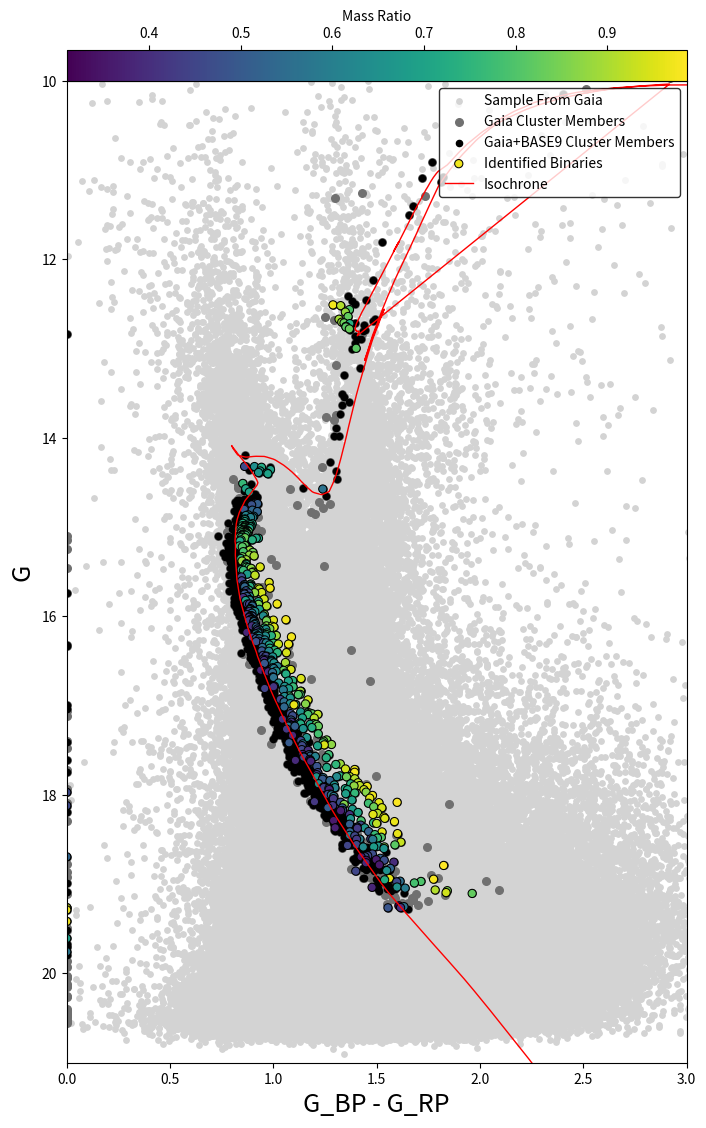

In [374]:
r = photBinary['qMean']
f, ax = plt.subplots(figsize=(8,15))

ax.set_xlabel('G_BP - G_RP',fontsize=18)
ax.set_ylabel('G',fontsize=18)
#plot phot and cluster members
plt.scatter(originalGaia['G_BP'] - originalGaia['G_RP'], originalGaia['G'],s=15, color='lightgray',label='Sample From Gaia')
plt.scatter(phot['G_BP'] - phot['G_RP'], phot['G'],s=30, color='#707070',label='Gaia Cluster Members')
plt.scatter(photMems['G_BP'] - photMems['G_RP'], photMems['G'],s=20, color='#000000',label='Gaia+BASE9 Cluster Members')
#plt.scatter(photBinary['g_ps'] - photBinary['i_ps'], photBinary['g_ps'], color='#000000')
ax.set_xlim(0, 3)
ax.set_ylim(21,10)


#plot colorbar
plt.scatter(photBinary['G_BP'] - photBinary['G_RP'], photBinary['G'], s=35, c=r, cmap=plt.cm.get_cmap("viridis"),edgecolors= "black",linewidth=0.75,label='Identified Binaries')

plt.colorbar(label="Mass Ratio", orientation="horizontal",pad=0,location='top')


#overplot isochrone
photfile = ph
cmdfile = r"/Users/Claire/Documents/Code/current/ANNACRNN/plotting/run21_int_19co_ov/NGC6819.ms"
mag       = 'G'
color     = 'G_BP-G_RP'.split('-')
header   = np.loadtxt(cmdfile,max_rows=1,dtype=str)
yplot     = np.where(header == mag)[0][0]
color1    = np.where(header == color[0])[0][0]
color2    = np.where(header == color[1])[0][0]
data = np.loadtxt(cmdfile,skiprows=1)
ymag    = data[:,yplot]
color   = data[:,color1] - data[:,color2]
plt.plot(color, ymag, color='red',linewidth=1,label='Isochrone')
plt.legend(loc="upper right",edgecolor='black')
#plt.show()
plt.savefig('MegaCMD1.png',dpi=300, bbox_inches="tight")
    


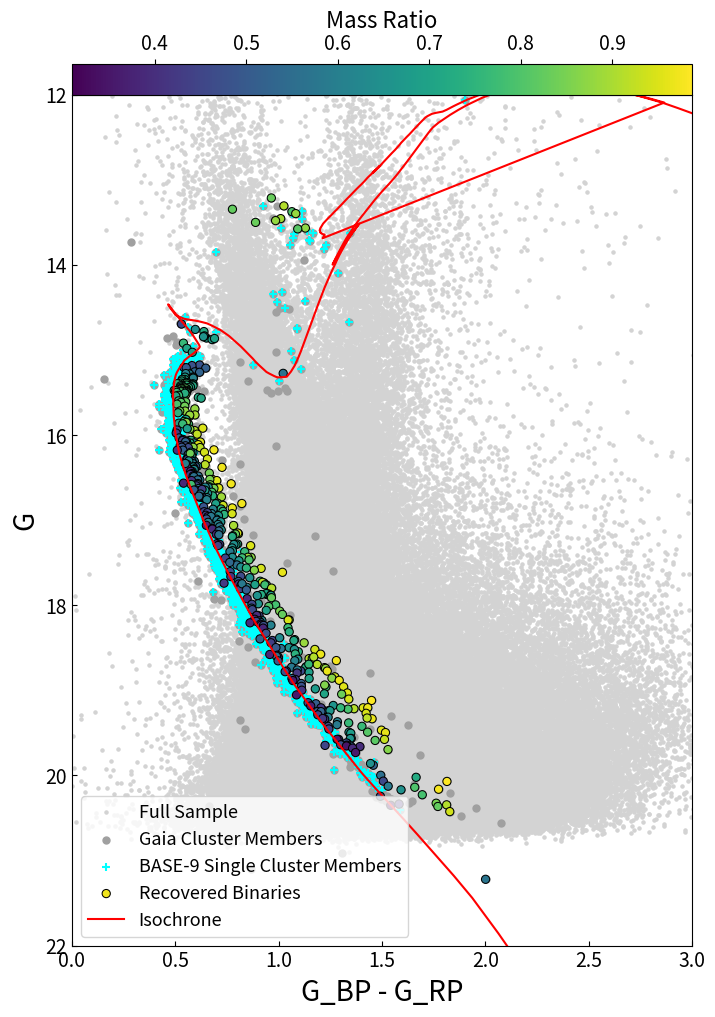

In [375]:
r = photBinary['qMean']
f, ax = plt.subplots(figsize=(8,13), facecolor='w')
ax.set_xlabel('G_BP - G_RP',fontsize=20)
ax.set_ylabel('G',fontsize=20)
#plot phot and cluster members
plt.scatter(originalGaia['G_BP'] - originalGaia["G_RP"], originalGaia["G"], s=5, color="#D3D3D3", label="Full Sample")
plt.scatter(phot['g_ps'] - phot['i_ps'], phot['g_ps'],s=25, color='#A0A0A0', label="Gaia Cluster Members")
plt.scatter(photMems['g_ps'] - photMems['i_ps'], photMems['g_ps'],s=35, color='cyan', marker="+", label="BASE-9 Single Cluster Members")
#plt.scatter(photBinary['g_ps'] - photBinary['i_ps'], photBinary['g_ps'], color='#000000')


ax.set_xlim(0, 3)
ax.set_ylim(22, 12)
#plot colorbar
plt.scatter(photBinary['g_ps'] - photBinary['i_ps'], photBinary['g_ps'], s=35, c=r, cmap=plt.cm.get_cmap("viridis"),edgecolors= "black",linewidth=0.75, label="Recovered Binaries")
cbar = plt.colorbar(orientation="horizontal",pad=0,location='top')
cbar.set_label("Mass Ratio", fontsize=16)
tick_font_size = 14
cbar.ax.tick_params(labelsize=tick_font_size)

cmdfile =r"/Users/Claire/Documents/Code/current/ANNACRNN/plotting/run21_int_19co_ov/NGC6819.ms"
mag     = "g_ps"
color     = "g_ps-i_ps".split('-')

header = np.loadtxt(cmdfile,max_rows=1,dtype=str)
yplot     = np.where(header == mag)[0][0]
color1    = np.where(header == color[0])[0][0]
color2    = np.where(header == color[1])[0][0]
data = np.loadtxt(cmdfile,skiprows=1)
ymag    = data[:,yplot]
color   = data[:,color1] - data[:,color2]
plt.plot(color, ymag, color='red', label="Isochrone")
ax.legend(fontsize=13,loc="lower left")
ax.tick_params(which = 'major', direction = 'in', labelsize = 14)
plt.savefig('cmdWithMassRatio.png', dpi=300)

plt.show()

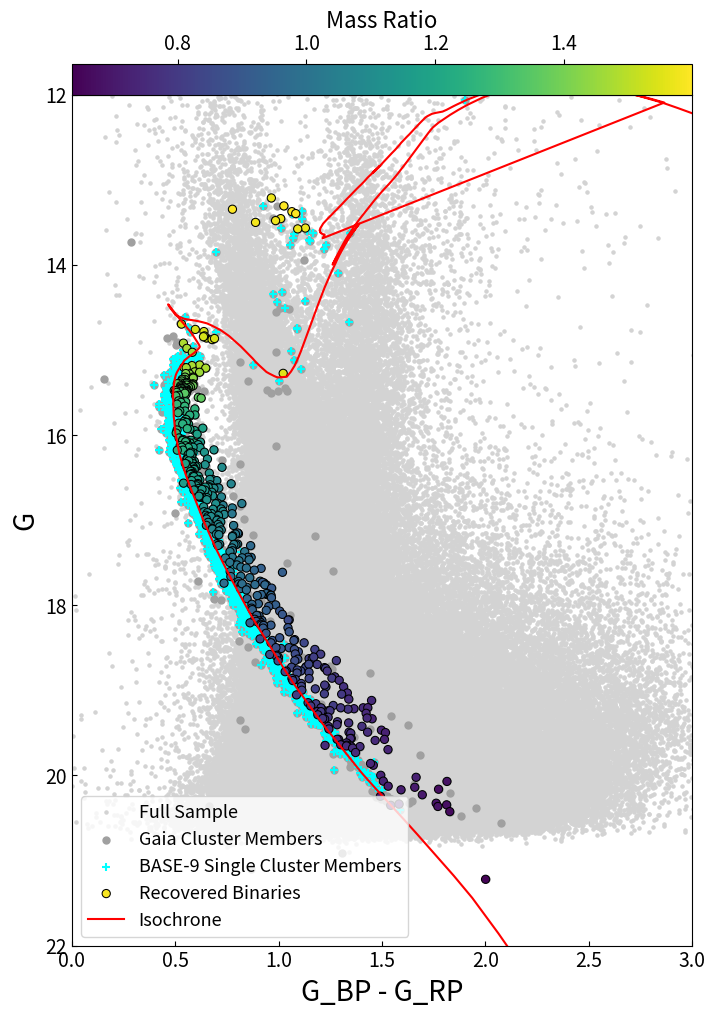

In [376]:
r = photBinary['m1Mean']
f, ax = plt.subplots(figsize=(8,13), facecolor='w')
ax.set_xlabel('G_BP - G_RP',fontsize=20)
ax.set_ylabel('G',fontsize=20)
#plot phot and cluster members
plt.scatter(originalGaia['G_BP'] - originalGaia["G_RP"], originalGaia["G"], s=5, color="#D3D3D3", label="Full Sample")
plt.scatter(phot['g_ps'] - phot['i_ps'], phot['g_ps'],s=25, color='#A0A0A0', label="Gaia Cluster Members")
plt.scatter(photMems['g_ps'] - photMems['i_ps'], photMems['g_ps'],s=35, color='cyan', marker="+", label="BASE-9 Single Cluster Members")
#plt.scatter(photBinary['g_ps'] - photBinary['i_ps'], photBinary['g_ps'], color='#000000')


ax.set_xlim(0, 3)
ax.set_ylim(22, 12)
#plot colorbar
plt.scatter(photBinary['g_ps'] - photBinary['i_ps'], photBinary['g_ps'], s=35, c=r, cmap=plt.cm.get_cmap("viridis"),edgecolors= "black",linewidth=0.75, label="Recovered Binaries")
cbar = plt.colorbar(orientation="horizontal",pad=0,location='top')
cbar.set_label("Mass Ratio", fontsize=16)
tick_font_size = 14
cbar.ax.tick_params(labelsize=tick_font_size)

cmdfile =r"/Users/Claire/Documents/Code/current/ANNACRNN/plotting/run21_int_19co_ov/NGC6819.ms"
mag     = "g_ps"
color     = "g_ps-i_ps".split('-')

header = np.loadtxt(cmdfile,max_rows=1,dtype=str)
yplot     = np.where(header == mag)[0][0]
color1    = np.where(header == color[0])[0][0]
color2    = np.where(header == color[1])[0][0]
data = np.loadtxt(cmdfile,skiprows=1)
ymag    = data[:,yplot]
color   = data[:,color1] - data[:,color2]
plt.plot(color, ymag, color='red', label="Isochrone")
ax.legend(fontsize=13,loc="lower left")
ax.tick_params(which = 'major', direction = 'in', labelsize = 14)
plt.savefig('cmdWithMassRatio.png', dpi=300)

plt.show()

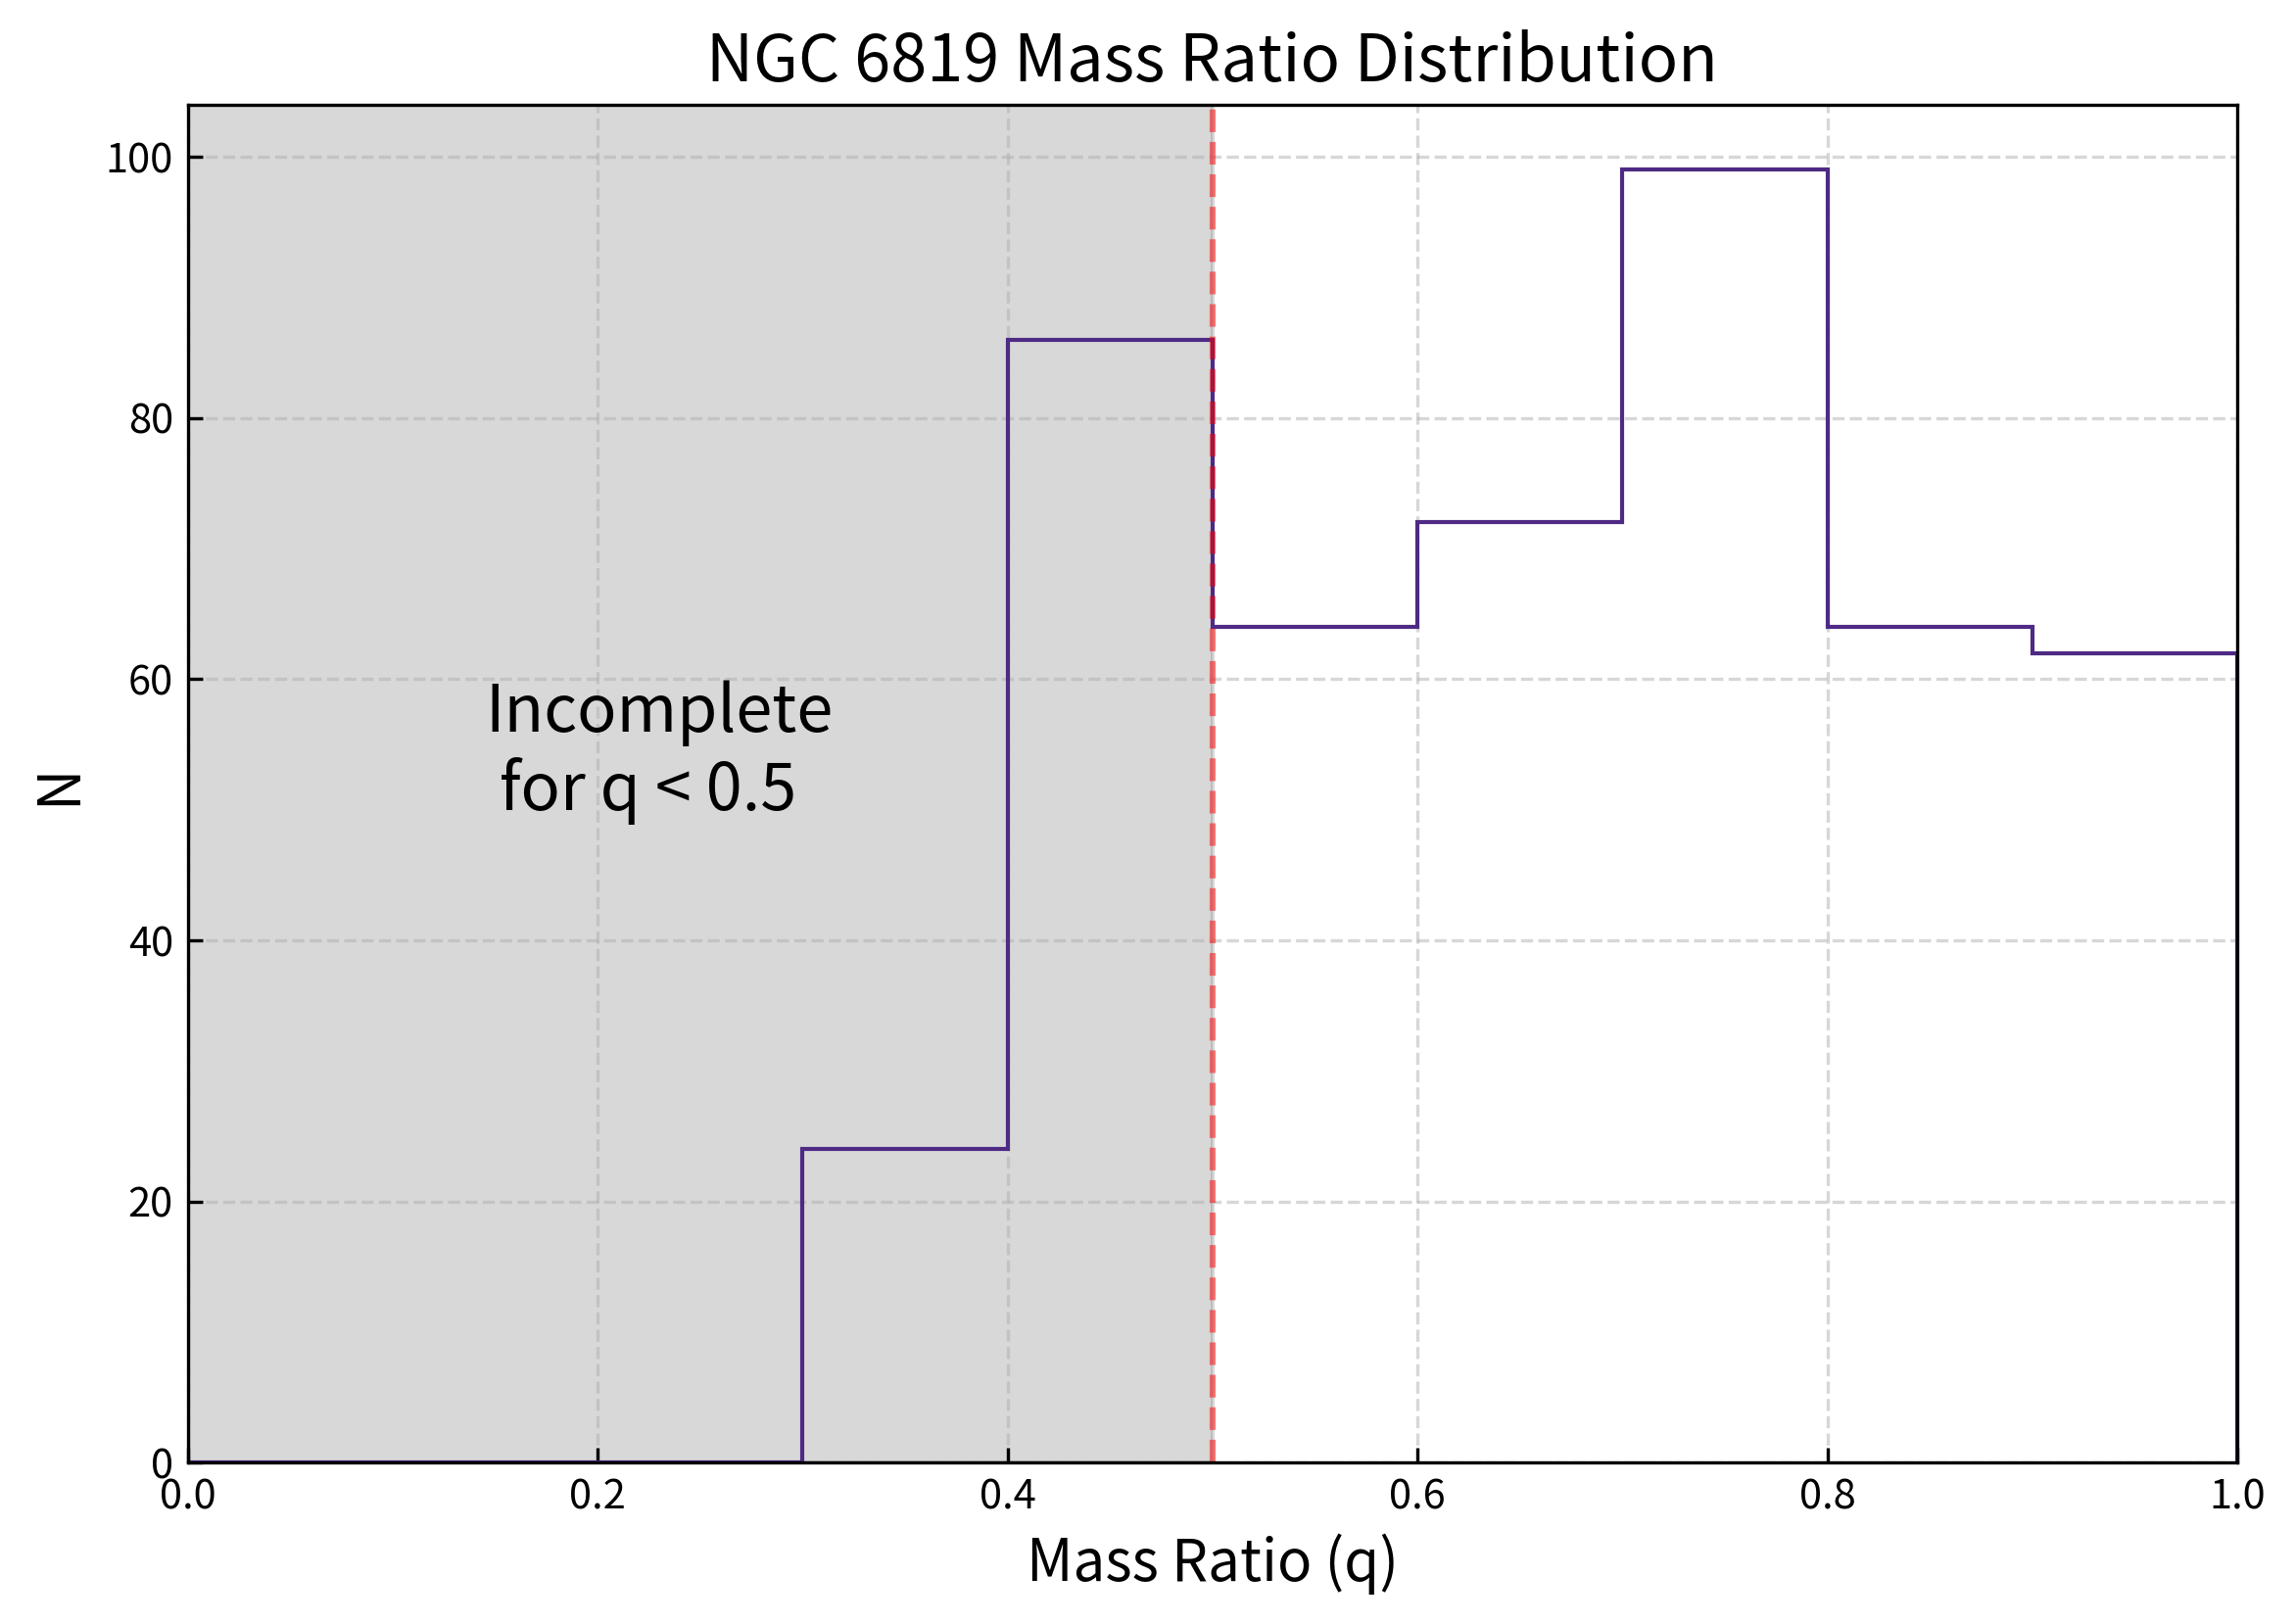

In [377]:
f, ax = plt.subplots(figsize=(9,6), facecolor='w', dpi=300)
photBinary = phot.loc[phot['binary']]
_ = ax.hist(photBinary['qMean'], histtype='step', color="#4e2a84" ,bins=10, range=[0,1])
ax.set_xlabel("Mass Ratio (q)", fontsize=14)
ax.set_ylabel("N", fontsize=14)
ax.annotate(text='Incomplete\n for q < 0.5', xy=(.145,50), xytext=(.145,50), fontsize=16)
ax.axvline(x=0.5, color='red', linestyle='--', alpha=0.5)
ax.axvspan(0,0.5, color='gray', alpha=0.3)
ax.set_title("NGC 6819 Mass Ratio Distribution", fontsize=16)
plt.grid(linestyle='--', alpha=0.5)
ax.tick_params(which='both', direction="in")
ax.set_xlim(0,1)
plt.savefig("massratio.png", dpi=300)

Text(0, 0.5, 'N')

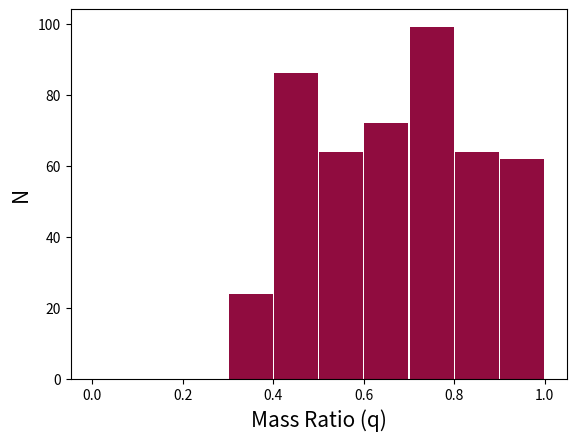

In [378]:
f, ax = plt.subplots()
photBinary = phot.loc[phot['binary']]
_ = ax.hist(photBinary['qMean'], bins=10, range=[0,1],linewidth=2,color='#900C3F',rwidth=0.97)
ax.set_xlabel('Mass Ratio (q)',fontsize=15)
ax.set_ylabel('N',fontsize=15)
#plt.savefig('M67qhist1.png',dpi=300, bbox_inches="tight")

In [379]:
# f, ax = plt.subplots(figsize=(6,10))

# ax.set_xlabel('G_BP - G_RP',fontsize=20)
# ax.set_ylabel('G',fontsize=20)
# #plot phot and cluster members
# plt.scatter(M67.data['phot_bp_mean_mag'] - M67.data['phot_rp_mean_mag'], M67.data['phot_g_mean_mag'],s=15, color='lightgray',label='Sample From Gaia')
# plt.scatter(phot['G_BP'] - phot['G_RP'], phot['G'],s=30, color='Deeppink',label='Gaia Cluster Members', edgecolors= "black",linewidth=0.2)
# ax.set_xlim(0, 3)
# ax.set_ylim(21,10)
# #plt.savefig('M67cmd.png', bbox='tight',dpi=300)